# Selection of a dataset

In [1]:
import time
import math
import pandas as pd
from chembl_webresource_client.new_client import new_client # to download a molecule dataset from ChEMBL

## Download a dataset from ChEMBL

In [2]:
def download_targetid_chembl(taget_name):
    target = new_client.target

    cyp = target.filter(pref_name__iexact=taget_name).only(
    ['target_chembl_id', 'target_organism', 'target_pref_name'])
    
    return cyp

Select molecules whose activities have been measured 'IC50', 'EC50', 'Ki', 'Kd' and have standart units 'mM', 'nm', 'nM', 'uM'

In [3]:
def download_mols_chembl(t):
    activity = new_client.activity
    
    mols = activity.filter(target_chembl_id=t['target_chembl_id'], 
                           standard_type__in=['IC50', 'EC50', 'Ki', 'Kd'],
                           standard_units__in=['mM', 'nm', 'nM', 'uM']
                          ).only(
    [
        'molecule_chembl_id', 
        'standard_type', 'standard_relation', 'standard_value', 'standard_units', 
        'canonical_smiles',
        'assay_description', 
        'document_journal', 'document_year'
    ])
    
    return mols

Let's download a set of molecules with known activity to the Cytochrome P450 3A4 enzyme, sourced from the ChEMBL database

In [4]:
trg_cyp = download_targetid_chembl('Cytochrome P450 3A4')
for el in trg_cyp:
    print(el)

{'organism': 'Homo sapiens', 'pref_name': 'Cytochrome P450 3A4', 'target_chembl_id': 'CHEMBL340'}


In [5]:
mols_cyp = download_mols_chembl(trg_cyp[0])
len(mols_cyp)

10290

In [6]:
mols_cyp[0]

{'assay_description': 'Inhibition of cytochrome P450 3A4 of isolated guinea pig heart',
 'canonical_smiles': 'Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccccc5)c4)CC3)ccc2s1',
 'document_journal': 'Bioorg. Med. Chem. Lett.',
 'document_year': 2004,
 'molecule_chembl_id': 'CHEMBL152968',
 'relation': '=',
 'standard_relation': '=',
 'standard_type': 'IC50',
 'standard_units': 'nM',
 'standard_value': '37000.0',
 'type': 'IC50',
 'units': 'uM',
 'value': '37.0'}

Convert from the QuerySet format to a Pandas dataframe

In [7]:
def queryset2df(mols):
    i = 0
    j = 10000
    df = pd.DataFrame()
    mols = list(mols)
    while j <= len(mols):
        dft = pd.DataFrame(mols[i:j])
        df = pd.concat([df, dft])
        i = j
        j = j + 10000

    dft = pd.DataFrame(mols[i:])
    df = pd.concat([df, dft], sort=False)
    return df

In [8]:
# start = time.time()

# df_cyp = pd.DataFrame(mols_cyp)

# print('Work time:', round(time.time() - start, 3))

In [9]:
start = time.time()

df_cyp = queryset2df(mols_cyp)

print('Work time using queryset2df():', round(time.time() - start, 3), 'c')

Work time using queryset2df(): 0.738 c


In [10]:
# To save time you can read the database from hard disk
# df_cyp = pd.read_csv('Cytochrome_P450_3A4-chembl31.csv', sep='\t')

## Analyse the data

In [11]:
# Let's take a look at the structure of the dataset
df_cyp.head(3)

,assay_description,canonical_smiles,document_journal,document_year,molecule_chembl_id,relation,standard_relation,standard_type,standard_units,standard_value,type,units,value
0,Inhibition of cytochrome P450 3A4 of isolated ...,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccc...,Bioorg. Med. Chem. Lett.,2004.0,CHEMBL152968,=,=,IC50,nM,37000.0,IC50,uM,37.0
1,Inhibition of human cytochrome P450 3A4 as tot...,COc1ccc(NS(=O)(=O)c2ccc(Br)cc2)cc1N1CCN(C)CC1,J. Med. Chem.,1999.0,CHEMBL292759,=,=,IC50,nM,6000.0,IC50,uM,6.0
2,Inhibition of cytochrome P450 3A4 of isolated ...,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4ccc(-c5cccc...,Bioorg. Med. Chem. Lett.,2004.0,CHEMBL153741,=,=,IC50,nM,7900.0,IC50,uM,7.9


In [12]:
# The size of the dataset
df_cyp.shape

(10290, 13)

In [13]:
# Statistics of the years when the analysis was carried out
df_cyp['document_year'].describe()

count    10055.000000
mean      2013.067429
std          4.324263
min       1992.000000
25%       2010.000000
50%       2013.000000
75%       2016.000000
max       2021.000000
Name: document_year, dtype: float64

In [14]:
# Number of missed cells in each column
df_cyp.isnull().sum()

assay_description        0
canonical_smiles         0
document_journal      1298
document_year          235
molecule_chembl_id       0
relation                25
standard_relation       25
standard_type            0
standard_units           0
standard_value          35
type                     0
units                  188
value                   35
dtype: int64

In [15]:
# The number of duplicates
df_cyp['canonical_smiles'].duplicated().sum()

1909

In [16]:
# Print duplicates only
# df_cyp[df_cyp['canonical_smiles'].duplicated()].sort_values(by=['canonical_smiles'], axis=0)

In [17]:
# The number of mixtures
df_cyp['canonical_smiles'].str.contains('.').sum()

10290

In [18]:
# Type of measures of a drug's efficacy
set(df_cyp['standard_type'])

{'EC50', 'IC50', 'Kd', 'Ki'}

In [19]:
# Units of measurement
set(df_cyp['standard_units'])

{'nM'}

In [20]:
set(df_cyp['standard_relation'])

{'<', '<=', '=', '>', '>=', None}

## Data preprocessing

In [21]:
# Delete unnecessary columns
df_cyp = df_cyp.drop(['relation', 'type', 'units', 'value'], axis=1)

# Covert `standard_value` column containing strings and NaN values to floats 
# and leave molecules whose activity is greater than 0
df_cyp['standard_value'] = df_cyp['standard_value'].astype(float)
df_cyp = df_cyp[df_cyp['standard_value'] > 0]

# Delete rows with missing data in the `canonical_smiles` columns
df_cyp = df_cyp.dropna(subset=['canonical_smiles']).reset_index(drop=True)
print('Number of molecules:', df_cyp.shape[0])

Number of molecules: 10254


In [22]:
df_cyp.loc[0]

assay_description     Inhibition of cytochrome P450 3A4 of isolated ...
canonical_smiles      Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccc...
document_journal                               Bioorg. Med. Chem. Lett.
document_year                                                    2004.0
molecule_chembl_id                                         CHEMBL152968
standard_relation                                                     =
standard_type                                                      IC50
standard_units                                                       nM
standard_value                                                  37000.0
Name: 0, dtype: object

In [23]:
df_cyp['pval'] = df_cyp.apply(lambda x: 
               round(3 - math.log10(x['standard_value']), 3) if x['standard_units'] == 'mM' 
          else round(6 - math.log10(x['standard_value']), 3) if x['standard_units'] == 'uM' 
          else round(9 - math.log10(x['standard_value']), 3) if x['standard_units'] == 'nm' or x['standard_units'] == 'nM' 
          else None, 
                              axis=1)

count    10254.000000
mean         5.138817
std          0.886428
min          1.110000
25%          4.538000
50%          5.000000
75%          5.509000
max         10.658000
Name: pval, dtype: float64


<AxesSubplot:>

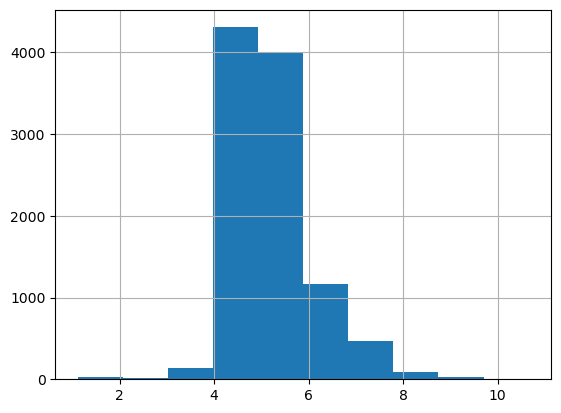

In [24]:
print(df_cyp['pval'].describe())
df_cyp['pval'].hist()

Let's calculate pValue of the measured molecules' activity and process the duplicates

In [25]:
df_val = df_cyp.groupby('canonical_smiles')['pval'].agg(['mean', 'max', 'min'])

In [26]:
df_val[(df_val['max'] > 6) & (df_val['min'] <= 6)]

,mean,max,min
canonical_smiles,,,
C/C(=C\COc1c2ccoc2cc2oc(=O)ccc12)CC[C@@H](O)C(C)(C)O,5.946500,6.092,5.801
C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC)C(=O)N(C)CC(=O)N(C)[C@@H](CC(C)C)C(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](CC(C)C)C(=O)N[C@@H](C)C(=O)N[C@H](C)C(=O)N(C)[C@@H](CC(C)C)C(=O)N(C)[C@@H](CC(C)C)C(=O)N(C)[C@@H](C(C)C)C(=O)N1C,5.573125,6.523,5.000
C=CC[C@@H]1/C=C(\C)C[C@H](C)C[C@H](OC)[C@H]2O[C@@](O)(C(=O)C(=O)N3CCCC[C@H]3C(=O)O[C@H](/C(C)=C/[C@@H]3CC[C@@H](O)[C@H](OC)C3)[C@H](C)[C@@H](O)CC1=O)[C@H](C)C[C@@H]2OC,6.176000,6.921,5.575
C=CC[C@H]1N(C(=O)c2cnccc2C(F)(F)F)CCC[C@@]1(Oc1ccc(C(F)(F)F)cc1)C(=O)N1CCN(c2ccccc2OCCOC)CC1.Cl,6.100500,6.523,5.678
CC(=O)N1CCN(c2ccc(OCC3COC(Cn4ccnc4)(c4ccc(Cl)cc4Cl)O3)cc2)CC1,7.113667,9.000,4.097
...,...,...,...
O=C(Nc1ccc(S(=O)(=O)c2ccccc2)cc1)[C@@H]1C[C@H]1c1cccnc1,6.440000,6.959,5.921
O=C(Nc1cccnc1)N1CCC(=Cc2cccc(Oc3ccc(C(F)(F)F)cn3)c2)CC1,5.732000,6.097,5.367
O=C1OC[C@H](Cc2ccc3c(c2)OCO3)[C@H]1Cc1ccc2c(c1)OCO2,5.762500,6.428,5.097


In [27]:
distrust_mols = df_val[(df_val['max'] > 6.01) & (df_val['min'] <= 6)].index.tolist()
df_val = df_val[~df_val.index.isin(distrust_mols)]

In [28]:
df_cyp = df_cyp.merge(df_val, left_on='canonical_smiles', right_index=True, how='inner')
df_cyp = df_cyp.drop_duplicates('canonical_smiles').reset_index(drop=True)

In [29]:
# If molecules have relation '=' or '>' and mean pActivity >= 6, then the molecules considered active and get status 1
# if molecules have relation '=' or '<' and mean pActivity < 6, then the molecules considered active and get status 0
# otherwise molecules get status None and will be deleted 
df_cyp['status'] = [1 if standard_relation in ['=', '>'] and pvalue >= 6 else 0
                      if standard_relation in ['=','<'] and pvalue < 6 else None
                     for standard_relation, pvalue in zip(df_cyp['standard_relation'], df_cyp['mean'])]

In [30]:
df_cyp = df_cyp.dropna(subset=['status']).reset_index(drop=True)

<AxesSubplot:>

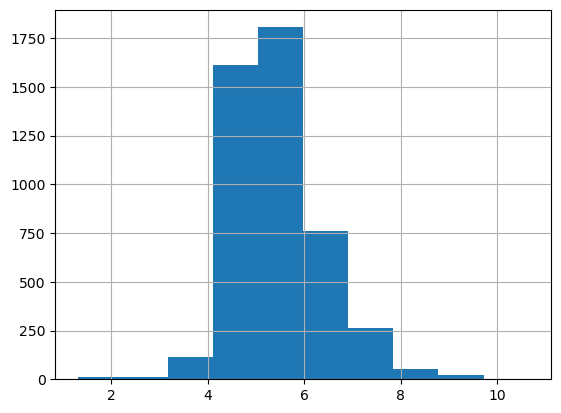

In [31]:
df_cyp['mean'].hist()

<AxesSubplot:title={'center':'Number of active and inactive molecules'}, ylabel='None'>

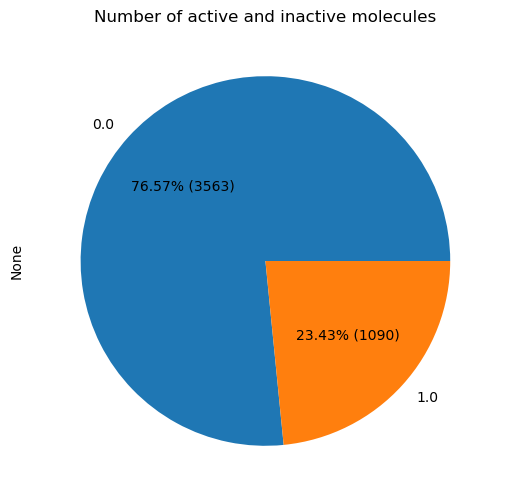

In [32]:
s = df_cyp.groupby(['status']).size()
s.plot(kind='pie', title='Number of active and inactive molecules', figsize=[6,6], 
       autopct=lambda p:f'{p:.2f}% ({p*sum(s.tolist())/100:.0f})')

## SMILES Standartization and Normalization

The standardization(of the molecule)/normalization(of functional groups) pipeline for ML proposed by [JP Ebejer](https://bitsilla.com/blog/2021/06/standardizing-a-molecule-using-rdkit/)

In [33]:
from IPython.display import SVG 

import rdkit
from rdkit import Chem
from rdkit.Chem import rdDepictor  
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.MolStandardize import rdMolStandardize

In [34]:
def draw_mol_with_SVG(mol, molSize=(450,150)):
    """Use SVG to draw an RDKit molecule, mol."""
    mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():        
        rdDepictor.Compute2DCoords(mc) # Compute 2D coordinates
    # Initialize the drawer with the size
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc) # Draw the molcule
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText() # Get the SVG string
    display(SVG(svg.replace('svg:',''))) # Fix the SVG string and display

In [35]:
def standardize_mol(mol, verbose=False):    
    clean_mol = rdMolStandardize.Cleanup(mol) 
    if verbose:
        print('Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:')
        draw_mol_with_SVG(clean_mol)
        
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
    if verbose:
        print('Select the "parent" fragment:')
        draw_mol_with_SVG(parent_clean_mol)
        
    uncharger = rdMolStandardize.Uncharger()
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
    if verbose:
        print('Neutralize the molecule:')
        draw_mol_with_SVG(uncharged_parent_clean_mol)

    te = rdMolStandardize.TautomerEnumerator()
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
    if verbose:
        print('Enumerate tautomers:')
        draw_mol_with_SVG(taut_uncharged_parent_clean_mol)
    assert taut_uncharged_parent_clean_mol != None
    
    return taut_uncharged_parent_clean_mol


def standardize_smiles(smiles, verbose=False):
    if verbose: print(smiles)
    std_mol = standardize_mol(Chem.MolFromSmiles(smiles), verbose)
    return Chem.MolToSmiles(std_mol)

COc1ccc(NS(=O)(=O)c2sc3ccc(Cl)cc3c2C)cc1N1CCNCC1.Cl
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:


[09:45:06] Initializing MetalDisconnector
[09:45:06] Running MetalDisconnector
[09:45:06] Initializing Normalizer
[09:45:06] Running Normalizer


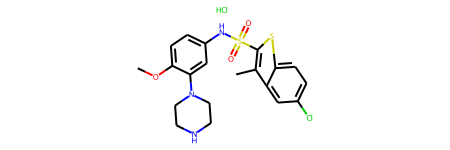

Select the "parent" fragment:


[09:45:06] Initializing MetalDisconnector
[09:45:06] Running MetalDisconnector
[09:45:06] Initializing Normalizer
[09:45:06] Running Normalizer
[09:45:06] Running LargestFragmentChooser
[09:45:06] Fragment: COc1ccc(NS(=O)(=O)c2sc3ccc(Cl)cc3c2C)cc1N1CCNCC1
[09:45:06] New largest fragment: COc1ccc(NS(=O)(=O)c2sc3ccc(Cl)cc3c2C)cc1N1CCNCC1 (51)
[09:45:06] Fragment: Cl


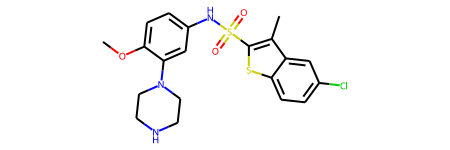

Neutralize the molecule:


[09:45:06] Running Uncharger


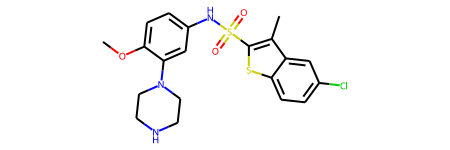

Enumerate tautomers:


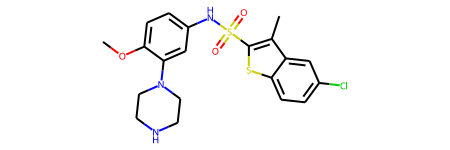

'COc1ccc(NS(=O)(=O)c2sc3ccc(Cl)cc3c2C)cc1N1CCNCC1'

In [36]:
standardize_smiles(df_cyp.loc[4, 'canonical_smiles'], verbose=True)

In [37]:
df_cyp['smiles'] = df_cyp['canonical_smiles'].apply(lambda x: standardize_smiles(x))

[09:45:06] Initializing MetalDisconnector
[09:45:06] Running MetalDisconnector
[09:45:06] Initializing Normalizer
[09:45:06] Running Normalizer
[09:45:06] Initializing MetalDisconnector
[09:45:06] Running MetalDisconnector
[09:45:06] Initializing Normalizer
[09:45:06] Running Normalizer
[09:45:06] Running LargestFragmentChooser
[09:45:06] Fragment: Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccccc5)c4)CC3)ccc2s1
[09:45:06] New largest fragment: Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccccc5)c4)CC3)ccc2s1 (69)
[09:45:06] Running Uncharger
[09:45:06] Initializing MetalDisconnector
[09:45:06] Running MetalDisconnector
[09:45:06] Initializing Normalizer
[09:45:06] Running Normalizer
[09:45:06] Initializing MetalDisconnector
[09:45:06] Running MetalDisconnector
[09:45:06] Initializing Normalizer
[09:45:06] Running Normalizer
[09:45:06] Running LargestFragmentChooser
[09:45:06] Fragment: COc1ccc(NS(=O)(=O)c2ccc(Br)cc2)cc1N1CCN(C)CC1
[09:45:06] New largest fragment: COc1ccc(NS(=O)(=O)c2ccc(

[09:45:06] Initializing MetalDisconnector
[09:45:06] Running MetalDisconnector
[09:45:06] Initializing Normalizer
[09:45:06] Running Normalizer
[09:45:06] Initializing MetalDisconnector
[09:45:06] Running MetalDisconnector
[09:45:06] Initializing Normalizer
[09:45:06] Running Normalizer
[09:45:06] Running LargestFragmentChooser
[09:45:06] Fragment: Cc1cc(C)cc(-c2[nH]c3ccc(C(C)(C)C(=O)N4C5CCC4CC5)cc3c2[C@H](C)CNCCc2ccc3ncoc3c2)c1
[09:45:06] New largest fragment: Cc1cc(C)cc(-c2[nH]c3ccc(C(C)(C)C(=O)N4C5CCC4CC5)cc3c2[C@H](C)CNCCc2ccc3ncoc3c2)c1 (88)
[09:45:06] Running Uncharger
[09:45:06] Initializing MetalDisconnector
[09:45:06] Running MetalDisconnector
[09:45:06] Initializing Normalizer
[09:45:06] Running Normalizer
[09:45:06] Initializing MetalDisconnector
[09:45:06] Running MetalDisconnector
[09:45:06] Initializing Normalizer
[09:45:06] Running Normalizer
[09:45:06] Running LargestFragmentChooser
[09:45:06] Fragment: O=C(NCC(F)(F)F)[C@@H]1CN(Cc2ccc(-c3ccncc3)o2)CCN1C[C@@H](O)C[C@@H](

[09:45:06] Running MetalDisconnector
[09:45:06] Initializing Normalizer
[09:45:06] Running Normalizer
[09:45:06] Initializing MetalDisconnector
[09:45:06] Running MetalDisconnector
[09:45:06] Initializing Normalizer
[09:45:06] Running Normalizer
[09:45:06] Running LargestFragmentChooser
[09:45:06] Fragment: Cn1c2ccnc(N3CCOCC3)c2c2ncnc(N3CCN(CCc4ccc(F)c(F)c4)CC3)c21
[09:45:06] New largest fragment: Cn1c2ccnc(N3CCOCC3)c2c2ncnc(N3CCN(CCc4ccc(F)c(F)c4)CC3)c21 (65)
[09:45:06] Running Uncharger
[09:45:06] Initializing MetalDisconnector
[09:45:06] Running MetalDisconnector
[09:45:06] Initializing Normalizer
[09:45:06] Running Normalizer
[09:45:06] Initializing MetalDisconnector
[09:45:06] Running MetalDisconnector
[09:45:06] Initializing Normalizer
[09:45:06] Running Normalizer
[09:45:06] Running LargestFragmentChooser
[09:45:06] Fragment: Cn1c2nccc(C(N)=O)c2c2ncnc(N3CCN(CCc4ccc(F)c(F)c4)CC3)c21
[09:45:06] New largest fragment: Cn1c2nccc(C(N)=O)c2c2ncnc(N3CCN(CCc4ccc(F)c(F)c4)CC3)c21 (56)
[09

[09:45:07] Initializing MetalDisconnector
[09:45:07] Running MetalDisconnector
[09:45:07] Initializing Normalizer
[09:45:07] Running Normalizer
[09:45:07] Initializing MetalDisconnector
[09:45:07] Running MetalDisconnector
[09:45:07] Initializing Normalizer
[09:45:07] Running Normalizer
[09:45:07] Running LargestFragmentChooser
[09:45:07] Fragment: CCCCOc1ccc(-c2cnco2)cc1
[09:45:07] New largest fragment: CCCCOc1ccc(-c2cnco2)cc1 (31)
[09:45:07] Running Uncharger
[09:45:07] Initializing MetalDisconnector
[09:45:07] Running MetalDisconnector
[09:45:07] Initializing Normalizer
[09:45:07] Running Normalizer
[09:45:07] Initializing MetalDisconnector
[09:45:07] Running MetalDisconnector
[09:45:07] Initializing Normalizer
[09:45:07] Running Normalizer
[09:45:07] Running LargestFragmentChooser
[09:45:07] Fragment: O=C(NCC(F)(F)F)[C@@H]1CN(Cc2ccn(-c3ccc(Cl)cc3)c2)CCN1C[C@@H](O)C[C@@H](Cc1cccnc1)C(=O)N[C@H]1c2ccccc2OC[C@H]1O
[09:45:07] New largest fragment: O=C(NCC(F)(F)F)[C@@H]1CN(Cc2ccn(-c3ccc(

[09:45:08] Initializing MetalDisconnector
[09:45:08] Running MetalDisconnector
[09:45:08] Initializing Normalizer
[09:45:08] Running Normalizer
[09:45:08] Initializing MetalDisconnector
[09:45:08] Running MetalDisconnector
[09:45:08] Initializing Normalizer
[09:45:08] Running Normalizer
[09:45:08] Running LargestFragmentChooser
[09:45:08] Fragment: CC(C)c1nc(COC(=O)N[C@H](C(=O)N[C@@H](Cc2ccccc2)[C@H](O)CN2CCN(Cc3cccc4c3COC4)C[C@H]2C(=O)NC(C)(C)C)C(C)C)cs1
[09:45:08] New largest fragment: CC(C)c1nc(COC(=O)N[C@H](C(=O)N[C@@H](Cc2ccccc2)[C@H](O)CN2CCN(Cc3cccc4c3COC4)C[C@H]2C(=O)NC(C)(C)C)C(C)C)cs1 (112)
[09:45:08] Running Uncharger
[09:45:08] Initializing MetalDisconnector
[09:45:08] Running MetalDisconnector
[09:45:08] Initializing Normalizer
[09:45:08] Running Normalizer
[09:45:08] Initializing MetalDisconnector
[09:45:08] Running MetalDisconnector
[09:45:08] Initializing Normalizer
[09:45:08] Running Normalizer
[09:45:08] Running LargestFragmentChooser
[09:45:08] Fragment: CN(C)CCCN(Cc

[09:45:08] Running MetalDisconnector
[09:45:08] Initializing Normalizer
[09:45:08] Running Normalizer
[09:45:08] Initializing MetalDisconnector
[09:45:08] Running MetalDisconnector
[09:45:08] Initializing Normalizer
[09:45:08] Running Normalizer
[09:45:08] Running LargestFragmentChooser
[09:45:08] Fragment: CCCCc1ccc(N/C=N/O)cc1
[09:45:08] New largest fragment: CCCCc1ccc(N/C=N/O)cc1 (30)
[09:45:08] Running Uncharger
[09:45:08] Initializing MetalDisconnector
[09:45:08] Running MetalDisconnector
[09:45:08] Initializing Normalizer
[09:45:08] Running Normalizer
[09:45:08] Initializing MetalDisconnector
[09:45:08] Running MetalDisconnector
[09:45:08] Initializing Normalizer
[09:45:08] Running Normalizer
[09:45:08] Running LargestFragmentChooser
[09:45:08] Fragment: CCCCc1ccccc1/N=C/NO
[09:45:08] New largest fragment: CCCCc1ccccc1/N=C/NO (30)
[09:45:08] Running Uncharger
[09:45:08] Initializing MetalDisconnector
[09:45:08] Running MetalDisconnector
[09:45:08] Initializing Normalizer
[09:45:0

[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Running LargestFragmentChooser
[09:45:09] Fragment: O=C(NCC(F)(F)F)[C@@H]1CN(Cc2cc3ccccc3o2)CCN1C[C@@H](O)C[C@@H](Cc1ccncc1)C(=O)N[C@H]1c2ccccc2OC[C@H]1O
[09:45:09] New largest fragment: O=C(NCC(F)(F)F)[C@@H]1CN(Cc2cc3ccccc3o2)CCN1C[C@@H](O)C[C@@H](Cc1ccncc1)C(=O)N[C@H]1c2ccccc2OC[C@H]1O (90)
[09:45:09] Running Uncharger
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Running LargestFragmentChooser
[09:45:09] Fragment: O=C(NCC(F)(F)F)[C@@H]1CN(CC

[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Running LargestFragmentChooser
[09:45:09] Fragment: CO[C@H]1C[C@H](O[C@@H]2[C@@H](C)C(=O)O[C@H](C)[C@H](C)[C@H](OC(C)=O)[C@@H](C)C(=O)[C@]3(CO3)C[C@H](C)[C@H](O[C@@H]3O[C@H](C)C[C@H](N(C)C)[C@H]3OC(C)=O)[C@H]2C)O[C@@H](C)[C@@H]1OC(C)=O
[09:45:09] New largest fragment: CO[C@H]1C[C@H](O[C@@H]2[C@@H](C)C(=O)O[C@H](C)[C@H](C)[C@H](OC(C)=O)[C@@H](C)C(=O)[C@]3(CO3)C[C@H](C)[C@H](O[C@@H]3O[C@H](C)C[C@H](N(C)C)[C@H]3OC(C)=O)[C@H]2C)O[C@@H](C)[C@@H]1OC(C)=O (124)
[09:45:09] Running Uncharger
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normaliz

[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Running LargestFragmentChooser
[09:45:09] Fragment: COC(=O)c1ccc(COc2ccc3cc(C(C(C)N(C)C)n4ccnc4)ccc3c2)cc1
[09:45:09] New largest fragment: COC(=O)c1ccc(COc2ccc3cc(C(C(C)N(C)C)n4ccnc4)ccc3c2)cc1 (62)
[09:45:09] Running Uncharger
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Running LargestFragmentChooser
[09:45:09] Fragment: CC(C(c1ccc2cc(OCc3ccc(C#N)cc3)ccc2c1)n1ccnc1)N(C)C
[09:45:09] New largest fragment: CC(C(c1ccc2cc(OCc3ccc(C#N)cc3)ccc2c1)n1ccnc1)N(C)C (57)
[09:45:09] Running Unch

[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Running LargestFragmentChooser
[09:45:09] Fragment: N#C[C@@H]1C[C@@H]2C[C@@H]2N1C(=O)[C@@H](N)C12CC3CC(CC(O)(C3)C1)C2
[09:45:09] New largest fragment: N#C[C@@H]1C[C@@H]2C[C@@H]2N1C(=O)[C@@H](N)C12CC3CC(CC(O)(C3)C1)C2 (48)
[09:45:09] Running Uncharger
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Running LargestFragmentChooser
[09:45:09] Fragment: CCN1c2ncc(CCOc3ccc(C(=O)O)cc3C)cc2C(=O)N(C)c2cccnc21
[09:45:09] New largest fragment: CCN1c2ncc(CCOc3ccc(C(=O)O)cc3C)cc2C(=O)N(C)c2cccnc21 (5

[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Running LargestFragmentChooser
[09:45:09] Fragment: CC1(C)CC(Oc2ccc(-c3ccc(C4(C(=O)O)CC4)cc3F)cc2)CC(C)(C)C1
[09:45:09] New largest fragment: CC1(C)CC(Oc2ccc(-c3ccc(C4(C(=O)O)CC4)cc3F)cc2)CC(C)(C)C1 (61)
[09:45:09] Running Uncharger
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Running LargestFragmentChooser
[09:45:09] Fragment: O=C(CN(c1ccc(Cl)cc1)S(=O)(=O)c1ccc(NCCN2CCOCC2)cc1)N/N=C1\C(=O)Nc2ccccc21
[09:45:09] New largest fragment: O=C(CN(c1ccc(Cl)cc1)S(=O)(=O)c1ccc(NCCN2CCOCC2)cc1)N

[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Running LargestFragmentChooser
[09:45:09] Fragment: COc1ccccc1COCCCOc1ccc(N2C(=O)CNC[C@@H]2COc2ccc3c(c2)N(CC(=O)O)C(=O)CO3)cc1
[09:45:09] New largest fragment: COc1ccccc1COCCCOc1ccc(N2C(=O)CNC[C@@H]2COc2ccc3c(c2)N(CC(=O)O)C(=O)CO3)cc1 (79)
[09:45:09] Running Uncharger
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Initializing MetalDisconnector
[09:45:09] Running MetalDisconnector
[09:45:09] Initializing Normalizer
[09:45:09] Running Normalizer
[09:45:09] Running LargestFragmentChooser
[09:45:09] Fragment: COCCCN1C(=O)COc2ccc(SC[C@H]3CNCC(=O)N3c3ccc(OCCCOCc4ccccc4OC)cc3)cc21
[09:45:09] 

[09:45:10] Running MetalDisconnector
[09:45:10] Initializing Normalizer
[09:45:10] Running Normalizer
[09:45:10] Initializing MetalDisconnector
[09:45:10] Running MetalDisconnector
[09:45:10] Initializing Normalizer
[09:45:10] Running Normalizer
[09:45:10] Running LargestFragmentChooser
[09:45:10] Fragment: CC(C)C[C@@H]1C(=O)N[C@H](C2Cc3ccccc3C2)C(=O)N1[C@@H](C(=O)NC(C)C)c1ccc2occc2c1
[09:45:10] New largest fragment: CC(C)C[C@@H]1C(=O)N[C@H](C2Cc3ccccc3C2)C(=O)N1[C@@H](C(=O)NC(C)C)c1ccc2occc2c1 (72)
[09:45:10] Running Uncharger
[09:45:10] Initializing MetalDisconnector
[09:45:10] Running MetalDisconnector
[09:45:10] Initializing Normalizer
[09:45:10] Running Normalizer
[09:45:10] Initializing MetalDisconnector
[09:45:10] Running MetalDisconnector
[09:45:10] Initializing Normalizer
[09:45:10] Running Normalizer
[09:45:10] Running LargestFragmentChooser
[09:45:10] Fragment: CC(C)C[C@@H]1C(=O)N[C@H](C2Cc3ccccc3C2)C(=O)N1[C@@H](C(=O)N(C)C)c1ccc(F)cc1F
[09:45:10] New largest fragment: CC(C)

[09:45:10] Running MetalDisconnector
[09:45:10] Initializing Normalizer
[09:45:10] Running Normalizer
[09:45:10] Initializing MetalDisconnector
[09:45:10] Running MetalDisconnector
[09:45:10] Initializing Normalizer
[09:45:10] Running Normalizer
[09:45:10] Running LargestFragmentChooser
[09:45:10] Fragment: O=C(OCc1ccccc1)N1CCC(CNc2cccnc2)CC1
[09:45:10] New largest fragment: O=C(OCc1ccccc1)N1CCC(CNc2cccnc2)CC1 (47)
[09:45:10] Running Uncharger
[09:45:10] Initializing MetalDisconnector
[09:45:10] Running MetalDisconnector
[09:45:10] Initializing Normalizer
[09:45:10] Running Normalizer
[09:45:10] Initializing MetalDisconnector
[09:45:10] Running MetalDisconnector
[09:45:10] Initializing Normalizer
[09:45:10] Running Normalizer
[09:45:10] Running LargestFragmentChooser
[09:45:10] Fragment: CCc1cc2c(c(C(F)(F)F)c1)C(=O)N1CCNC[C@@H]21
[09:45:10] New largest fragment: CCc1cc2c(c(C(F)(F)F)c1)C(=O)N1CCNC[C@@H]21 (35)
[09:45:10] Running Uncharger
[09:45:10] Initializing MetalDisconnector
[09:45

[09:45:10] Initializing MetalDisconnector
[09:45:10] Running MetalDisconnector
[09:45:10] Initializing Normalizer
[09:45:10] Running Normalizer
[09:45:10] Initializing MetalDisconnector
[09:45:10] Running MetalDisconnector
[09:45:10] Initializing Normalizer
[09:45:10] Running Normalizer
[09:45:10] Running LargestFragmentChooser
[09:45:10] Fragment: CCCCc1ccc(S(=O)(=O)Nc2ccc3c(c2)CCN(C)CC3)cc1
[09:45:10] New largest fragment: CCCCc1ccc(S(=O)(=O)Nc2ccc3c(c2)CCN(C)CC3)cc1 (54)
[09:45:10] Running Uncharger
[09:45:10] Initializing MetalDisconnector
[09:45:10] Running MetalDisconnector
[09:45:10] Initializing Normalizer
[09:45:10] Running Normalizer
[09:45:10] Initializing MetalDisconnector
[09:45:10] Running MetalDisconnector
[09:45:10] Initializing Normalizer
[09:45:10] Running Normalizer
[09:45:10] Running LargestFragmentChooser
[09:45:10] Fragment: CN1CCc2ccc(NS(=O)(=O)c3ccc(-c4ccc(Cl)cc4)cc3)cc2CC1
[09:45:10] New largest fragment: CN1CCc2ccc(NS(=O)(=O)c3ccc(-c4ccc(Cl)cc4)cc3)cc2CC1 (52)

[09:45:11] Initializing MetalDisconnector
[09:45:11] Running MetalDisconnector
[09:45:11] Initializing Normalizer
[09:45:11] Running Normalizer
[09:45:11] Initializing MetalDisconnector
[09:45:11] Running MetalDisconnector
[09:45:11] Initializing Normalizer
[09:45:11] Running Normalizer
[09:45:11] Running LargestFragmentChooser
[09:45:11] Fragment: Cc1cc(C2=NC(C)CN2)cc2[nH]c(-c3c(NCC(O)c4cccc(Cl)c4)cc[nH]c3=O)nc12
[09:45:11] New largest fragment: Cc1cc(C2=NC(C)CN2)cc2[nH]c(-c3c(NCC(O)c4cccc(Cl)c4)cc[nH]c3=O)nc12 (59)
[09:45:11] Running Uncharger
[09:45:11] Initializing MetalDisconnector
[09:45:11] Running MetalDisconnector
[09:45:11] Initializing Normalizer
[09:45:11] Running Normalizer
[09:45:11] Initializing MetalDisconnector
[09:45:11] Running MetalDisconnector
[09:45:11] Initializing Normalizer
[09:45:11] Running Normalizer
[09:45:11] Running LargestFragmentChooser
[09:45:11] Fragment: Cc1cc(C2=NCCN2C)cc2[nH]c(-c3c(NCC(O)c4cccc(Cl)c4)cc[nH]c3=O)nc12
[09:45:11] New largest fragment:

[09:45:13] Initializing MetalDisconnector
[09:45:13] Running MetalDisconnector
[09:45:13] Initializing Normalizer
[09:45:13] Running Normalizer
[09:45:13] Initializing MetalDisconnector
[09:45:13] Running MetalDisconnector
[09:45:13] Initializing Normalizer
[09:45:13] Running Normalizer
[09:45:13] Running LargestFragmentChooser
[09:45:13] Fragment: CCN1CCN(c2ccc(C(C)(C)NC(=O)c3cc4[nH]c5ccccc5c(=O)c4cc3F)cn2)CC1
[09:45:13] New largest fragment: CCN1CCN(c2ccc(C(C)(C)NC(=O)c3cc4[nH]c5ccccc5c(=O)c4cc3F)cn2)CC1 (66)
[09:45:13] Running Uncharger
[09:45:13] Initializing MetalDisconnector
[09:45:13] Running MetalDisconnector
[09:45:13] Initializing Normalizer
[09:45:13] Running Normalizer
[09:45:13] Initializing MetalDisconnector
[09:45:13] Running MetalDisconnector
[09:45:13] Initializing Normalizer
[09:45:13] Running Normalizer
[09:45:13] Running LargestFragmentChooser
[09:45:13] Fragment: O=C1O[C@@H](Cn2ccnn2)CN1c1ccc(-c2cccnc2)c(F)c1
[09:45:13] New largest fragment: O=C1O[C@@H](Cn2ccnn2)CN

[09:45:13] Initializing MetalDisconnector
[09:45:13] Running MetalDisconnector
[09:45:13] Initializing Normalizer
[09:45:13] Running Normalizer
[09:45:13] Initializing MetalDisconnector
[09:45:13] Running MetalDisconnector
[09:45:13] Initializing Normalizer
[09:45:13] Running Normalizer
[09:45:13] Running LargestFragmentChooser
[09:45:13] Fragment: CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(=O)OC)C(=O)C(C)(c1cc(F)cc(F)c1)O2
[09:45:13] New largest fragment: CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNC(=O)OC)C(=O)C(C)(c1cc(F)cc(F)c1)O2 (63)
[09:45:13] Running Uncharger
[09:45:13] Initializing MetalDisconnector
[09:45:13] Running MetalDisconnector
[09:45:13] Initializing Normalizer
[09:45:13] Running Normalizer
[09:45:13] Initializing MetalDisconnector
[09:45:13] Running MetalDisconnector
[09:45:13] Initializing Normalizer
[09:45:13] Running Normalizer
[09:45:13] Running LargestFragmentChooser
[09:45:13] Fragment: CCc1nc(N)nc(N)c1-c1ccc2c(c1)N(CCNS(C)(=O)=O)C(=O)C(C)(c1cc(F)cc(F)c1)O2
[09:45:13] New larges

[09:45:15] Initializing MetalDisconnector
[09:45:15] Running MetalDisconnector
[09:45:15] Initializing Normalizer
[09:45:15] Running Normalizer
[09:45:15] Initializing MetalDisconnector
[09:45:15] Running MetalDisconnector
[09:45:15] Initializing Normalizer
[09:45:15] Running Normalizer
[09:45:15] Running LargestFragmentChooser
[09:45:15] Fragment: CNCCC(=O)N[C@@H](CC(C)C)c1cc(C)ccc1N1CCN(C(=O)[C@@H](Cc2ccc(Cl)cc2Cl)N2CCCC2=O)CC1
[09:45:15] New largest fragment: CNCCC(=O)N[C@@H](CC(C)C)c1cc(C)ccc1N1CCN(C(=O)[C@@H](Cc2ccc(Cl)cc2Cl)N2CCCC2=O)CC1 (88)
[09:45:15] Running Uncharger
[09:45:15] Initializing MetalDisconnector
[09:45:15] Running MetalDisconnector
[09:45:15] Initializing Normalizer
[09:45:15] Running Normalizer
[09:45:15] Initializing MetalDisconnector
[09:45:15] Running MetalDisconnector
[09:45:15] Initializing Normalizer
[09:45:15] Running Normalizer
[09:45:15] Running LargestFragmentChooser
[09:45:15] Fragment: CNCCC(=O)N[C@@H](CC(C)C)c1ccccc1N1CCN(C(=O)[C@@H](Cc2ccc(Cl)cc2Cl

[09:45:15] Running MetalDisconnector
[09:45:15] Initializing Normalizer
[09:45:15] Running Normalizer
[09:45:15] Initializing MetalDisconnector
[09:45:15] Running MetalDisconnector
[09:45:15] Initializing Normalizer
[09:45:15] Running Normalizer
[09:45:15] Running LargestFragmentChooser
[09:45:15] Fragment: CC(C)C[C@@H](c1cccc(F)c1N1CCN(C(=O)[C@@H](Cc2ccc(Cl)cc2Cl)N2CCCC2=O)CC1)N(C)CCN
[09:45:15] New largest fragment: CC(C)C[C@@H](c1cccc(F)c1N1CCN(C(=O)[C@@H](Cc2ccc(Cl)cc2Cl)N2CCCC2=O)CC1)N(C)CCN (83)
[09:45:15] Running Uncharger
[09:45:15] Initializing MetalDisconnector
[09:45:15] Running MetalDisconnector
[09:45:15] Initializing Normalizer
[09:45:15] Running Normalizer
[09:45:15] Initializing MetalDisconnector
[09:45:15] Running MetalDisconnector
[09:45:15] Initializing Normalizer
[09:45:15] Running Normalizer
[09:45:15] Running LargestFragmentChooser
[09:45:15] Fragment: CC(C)C[C@H](NCCN)c1cc(C(F)(F)F)ccc1N1CCN(C(=O)[C@@H](Cc2ccc(Cl)cc2Cl)N2CCCC2=O)CC1
[09:45:15] New largest fragmen

[09:45:15] Initializing MetalDisconnector
[09:45:15] Running MetalDisconnector
[09:45:15] Initializing Normalizer
[09:45:15] Running Normalizer
[09:45:15] Initializing MetalDisconnector
[09:45:15] Running MetalDisconnector
[09:45:15] Initializing Normalizer
[09:45:15] Running Normalizer
[09:45:15] Running LargestFragmentChooser
[09:45:15] Fragment: CSc1ccccc1CNc1ncc([N+](=O)[O-])c(NCC2CCC(CN)CC2)n1
[09:45:15] New largest fragment: CSc1ccccc1CNc1ncc([N+](=O)[O-])c(NCC2CCC(CN)CC2)n1 (57)
[09:45:15] Running Uncharger
[09:45:15] Initializing MetalDisconnector
[09:45:15] Running MetalDisconnector
[09:45:15] Initializing Normalizer
[09:45:15] Running Normalizer
[09:45:15] Initializing MetalDisconnector
[09:45:15] Running MetalDisconnector
[09:45:15] Initializing Normalizer
[09:45:15] Running Normalizer
[09:45:15] Running LargestFragmentChooser
[09:45:15] Fragment: CCc1ccccc1N(CC(=O)NCc1ccc(Cl)cc1)S(=O)(=O)c1ccc(C)cc1
[09:45:15] New largest fragment: CCc1ccccc1N(CC(=O)NCc1ccc(Cl)cc1)S(=O)(=O)

[09:45:15] Running MetalDisconnector
[09:45:15] Initializing Normalizer
[09:45:15] Running Normalizer
[09:45:15] Initializing MetalDisconnector
[09:45:15] Running MetalDisconnector
[09:45:15] Initializing Normalizer
[09:45:15] Running Normalizer
[09:45:15] Running LargestFragmentChooser
[09:45:15] Fragment: Cc1ccc2c(OCCN3CCN(Cc4ccc5c(c4)N(Cc4ccccc4)C(=O)CO5)CC3)cccc2n1
[09:45:15] New largest fragment: Cc1ccc2c(OCCN3CCN(Cc4ccc5c(c4)N(Cc4ccccc4)C(=O)CO5)CC3)cccc2n1 (73)
[09:45:15] Running Uncharger
[09:45:15] Initializing MetalDisconnector
[09:45:15] Running MetalDisconnector
[09:45:15] Initializing Normalizer
[09:45:15] Running Normalizer
[09:45:15] Initializing MetalDisconnector
[09:45:15] Running MetalDisconnector
[09:45:15] Initializing Normalizer
[09:45:15] Running Normalizer
[09:45:15] Running LargestFragmentChooser
[09:45:15] Fragment: O=C(C1CCN(c2ccncc2)CC1)N1CC[C@@H](CNS(=O)(=O)/C=C/c2ccc(-c3ccc(Cl)s3)s2)C1
[09:45:15] New largest fragment: O=C(C1CCN(c2ccncc2)CC1)N1CC[C@@H](CNS(=

[09:45:16] Running MetalDisconnector
[09:45:16] Initializing Normalizer
[09:45:16] Running Normalizer
[09:45:16] Initializing MetalDisconnector
[09:45:16] Running MetalDisconnector
[09:45:16] Initializing Normalizer
[09:45:16] Running Normalizer
[09:45:16] Running LargestFragmentChooser
[09:45:16] Fragment: CC[C@@H]1CCC[C@H](C2(CC(=O)N3CC4CCC(C3)N4C)CC2)N1S(=O)(=O)c1ccc(Cl)cc1
[09:45:16] New largest fragment: CC[C@@H]1CCC[C@H](C2(CC(=O)N3CC4CCC(C3)N4C)CC2)N1S(=O)(=O)c1ccc(Cl)cc1 (69)
[09:45:16] Running Uncharger
[09:45:16] Initializing MetalDisconnector
[09:45:16] Running MetalDisconnector
[09:45:16] Initializing Normalizer
[09:45:16] Running Normalizer
[09:45:16] Initializing MetalDisconnector
[09:45:16] Running MetalDisconnector
[09:45:16] Initializing Normalizer
[09:45:16] Running Normalizer
[09:45:16] Running LargestFragmentChooser
[09:45:16] Fragment: CC[C@@H]1CCC[C@H](C2(CC(=O)N3CCNCC3)CC2)N1S(=O)(=O)c1ccc(Cl)cc1
[09:45:16] New largest fragment: CC[C@@H]1CCC[C@H](C2(CC(=O)N3CCNCC

[09:45:16] Initializing MetalDisconnector
[09:45:16] Running MetalDisconnector
[09:45:16] Initializing Normalizer
[09:45:16] Running Normalizer
[09:45:16] Initializing MetalDisconnector
[09:45:16] Running MetalDisconnector
[09:45:16] Initializing Normalizer
[09:45:16] Running Normalizer
[09:45:16] Running LargestFragmentChooser
[09:45:16] Fragment: O=C(NCc1nc2cccnc2n1C1(c2ccccc2)CC1)[C@@H](Cc1ccccc1C(F)(F)F)NC(=O)C1(C(F)(F)F)CC1
[09:45:16] New largest fragment: O=C(NCc1nc2cccnc2n1C1(c2ccccc2)CC1)[C@@H](Cc1ccccc1C(F)(F)F)NC(=O)C1(C(F)(F)F)CC1 (71)
[09:45:16] Running Uncharger
[09:45:16] Initializing MetalDisconnector
[09:45:16] Running MetalDisconnector
[09:45:16] Initializing Normalizer
[09:45:16] Running Normalizer
[09:45:16] Initializing MetalDisconnector
[09:45:16] Running MetalDisconnector
[09:45:16] Initializing Normalizer
[09:45:16] Running Normalizer
[09:45:16] Running LargestFragmentChooser
[09:45:16] Fragment: CC(C)(C)OC(=O)N[C@H](Cc1ccccc1C(F)(F)F)C(=O)NCc1nc2cccnc2n1C1(c2ccc

[09:45:16] Running MetalDisconnector
[09:45:16] Initializing Normalizer
[09:45:16] Running Normalizer
[09:45:16] Initializing MetalDisconnector
[09:45:16] Running MetalDisconnector
[09:45:16] Initializing Normalizer
[09:45:16] Running Normalizer
[09:45:16] Running LargestFragmentChooser
[09:45:16] Fragment: CC(C)c1c(-c2nnc(NCCO)o2)cn2ncnc(Nc3cc(C(=O)NC4CC4)c(F)cc3F)c12
[09:45:16] New largest fragment: CC(C)c1c(-c2nnc(NCCO)o2)cn2ncnc(Nc3cc(C(=O)NC4CC4)c(F)cc3F)c12 (60)
[09:45:16] Running Uncharger
[09:45:16] Initializing MetalDisconnector
[09:45:16] Running MetalDisconnector
[09:45:16] Initializing Normalizer
[09:45:16] Running Normalizer
[09:45:16] Initializing MetalDisconnector
[09:45:16] Running MetalDisconnector
[09:45:16] Initializing Normalizer
[09:45:16] Running Normalizer
[09:45:16] Running LargestFragmentChooser
[09:45:16] Fragment: CC(C)Nc1nnc(-c2cn3ncnc(Nc4cc(C(=O)NC5CC5)c(F)cc4F)c3c2C(C)C)o1
[09:45:16] New largest fragment: CC(C)Nc1nnc(-c2cn3ncnc(Nc4cc(C(=O)NC5CC5)c(F)cc4F)c

[09:45:17] Running MetalDisconnector
[09:45:17] Initializing Normalizer
[09:45:17] Running Normalizer
[09:45:17] Initializing MetalDisconnector
[09:45:17] Running MetalDisconnector
[09:45:17] Initializing Normalizer
[09:45:17] Running Normalizer
[09:45:17] Running LargestFragmentChooser
[09:45:17] Fragment: Clc1ccc(OC(Cn2ccnc2)c2ccc(Cl)cc2Cl)c(Cl)c1
[09:45:17] New largest fragment: Clc1ccc(OC(Cn2ccnc2)c2ccc(Cl)cc2Cl)c(Cl)c1 (36)
[09:45:17] Running Uncharger
[09:45:17] Initializing MetalDisconnector
[09:45:17] Running MetalDisconnector
[09:45:17] Initializing Normalizer
[09:45:17] Running Normalizer
[09:45:17] Initializing MetalDisconnector
[09:45:17] Running MetalDisconnector
[09:45:17] Initializing Normalizer
[09:45:17] Running Normalizer
[09:45:17] Running LargestFragmentChooser
[09:45:17] Fragment: O[C@](Cn1cccn1)(c1ccc(F)cc1F)n1cncn1
[09:45:17] New largest fragment: O[C@](Cn1cccn1)(c1ccc(F)cc1F)n1cncn1 (32)
[09:45:17] Running Uncharger
[09:45:17] Initializing MetalDisconnector
[09:

[09:45:17] Initializing MetalDisconnector
[09:45:17] Running MetalDisconnector
[09:45:17] Initializing Normalizer
[09:45:17] Running Normalizer
[09:45:17] Initializing MetalDisconnector
[09:45:17] Running MetalDisconnector
[09:45:17] Initializing Normalizer
[09:45:17] Running Normalizer
[09:45:17] Running LargestFragmentChooser
[09:45:17] Fragment: O=C1CC(c2cccc(-n3ccnn3)c2)=Nc2ccc(-c3ccccc3F)cc2N1
[09:45:17] New largest fragment: O=C1CC(c2cccc(-n3ccnn3)c2)=Nc2ccc(-c3ccccc3F)cc2N1 (46)
[09:45:17] Running Uncharger
[09:45:17] Initializing MetalDisconnector
[09:45:17] Running MetalDisconnector
[09:45:17] Initializing Normalizer
[09:45:17] Running Normalizer
[09:45:17] Initializing MetalDisconnector
[09:45:17] Running MetalDisconnector
[09:45:17] Initializing Normalizer
[09:45:17] Running Normalizer
[09:45:17] Running LargestFragmentChooser
[09:45:17] Fragment: O=C1CC(c2cccc(-n3ccnc3)c2)=Nc2cc(O)c(-c3ccccc3F)cc2N1
[09:45:17] New largest fragment: O=C1CC(c2cccc(-n3ccnc3)c2)=Nc2cc(O)c(-c3cc

[09:45:18] Initializing MetalDisconnector
[09:45:18] Running MetalDisconnector
[09:45:18] Initializing Normalizer
[09:45:18] Running Normalizer
[09:45:18] Initializing MetalDisconnector
[09:45:18] Running MetalDisconnector
[09:45:18] Initializing Normalizer
[09:45:18] Running Normalizer
[09:45:18] Running LargestFragmentChooser
[09:45:18] Fragment: O=C(Nc1ccc2c(c1)NC(=O)C(CCO)O2)C1CCN(c2cc(F)c(F)c(F)c2)CC1
[09:45:18] New largest fragment: O=C(Nc1ccc2c(c1)NC(=O)C(CCO)O2)C1CCN(c2cc(F)c(F)c(F)c2)CC1 (54)
[09:45:18] Running Uncharger
[09:45:18] Initializing MetalDisconnector
[09:45:18] Running MetalDisconnector
[09:45:18] Initializing Normalizer
[09:45:18] Running Normalizer
[09:45:18] Initializing MetalDisconnector
[09:45:18] Running MetalDisconnector
[09:45:18] Initializing Normalizer
[09:45:18] Running Normalizer
[09:45:18] Running LargestFragmentChooser
[09:45:18] Fragment: N[C@@H](Cn1c(=O)c(-c2cccc(OCCCCC(=O)O)c2F)cn(Cc2c(F)cccc2C(F)(F)F)c1=O)c1ccccc1
[09:45:18] New largest fragment: 

[09:45:18] Initializing MetalDisconnector
[09:45:18] Running MetalDisconnector
[09:45:18] Initializing Normalizer
[09:45:18] Running Normalizer
[09:45:18] Initializing MetalDisconnector
[09:45:18] Running MetalDisconnector
[09:45:18] Initializing Normalizer
[09:45:18] Running Normalizer
[09:45:18] Running LargestFragmentChooser
[09:45:18] Fragment: Cc1cc(C[C@@H](NC(=O)N2CCC(N3Cc4ccccc4NC3=O)CC2)C(=O)N2CCC(N3CCCCC3)CC2)cc2cn[nH]c12
[09:45:18] New largest fragment: Cc1cc(C[C@@H](NC(=O)N2CCC(N3Cc4ccccc4NC3=O)CC2)C(=O)N2CCC(N3CCCCC3)CC2)cc2cn[nH]c12 (92)
[09:45:18] Running Uncharger
[09:45:18] Initializing MetalDisconnector
[09:45:18] Running MetalDisconnector
[09:45:18] Initializing Normalizer
[09:45:18] Running Normalizer
[09:45:18] Initializing MetalDisconnector
[09:45:18] Running MetalDisconnector
[09:45:18] Initializing Normalizer
[09:45:18] Running Normalizer
[09:45:18] Running LargestFragmentChooser
[09:45:18] Fragment: O=C1/C(=C/c2ccc(O)cc2)CC/C1=C\c1ccc(O)cc1
[09:45:18] New larges

[09:45:19] Tautomer enumeration stopped at 326 tautomers: max transforms reached
[09:45:19] Initializing MetalDisconnector
[09:45:19] Running MetalDisconnector
[09:45:19] Initializing Normalizer
[09:45:19] Running Normalizer
[09:45:19] Initializing MetalDisconnector
[09:45:19] Running MetalDisconnector
[09:45:19] Initializing Normalizer
[09:45:19] Running Normalizer
[09:45:19] Running LargestFragmentChooser
[09:45:19] Fragment: CC(=O)O[C@H]1[C@H](C)O[C@@H](Oc2c(-c3ccc(O)cc3)oc3cc(O)cc(O)c3c2=O)[C@H](O)[C@@H]1OC(C)=O
[09:45:19] New largest fragment: CC(=O)O[C@H]1[C@H](C)O[C@@H](Oc2c(-c3ccc(O)cc3)oc3cc(O)cc(O)c3c2=O)[C@H](O)[C@@H]1OC(C)=O (61)
[09:45:19] Running Uncharger
[09:45:19] Tautomer enumeration stopped at 226 tautomers: max transforms reached
[09:45:19] Initializing MetalDisconnector
[09:45:19] Running MetalDisconnector
[09:45:19] Initializing Normalizer
[09:45:19] Running Normalizer
[09:45:19] Initializing MetalDisconnector
[09:45:19] Running MetalDisconnector
[09:45:19] Initia

[09:45:21] Running MetalDisconnector
[09:45:21] Initializing Normalizer
[09:45:21] Running Normalizer
[09:45:21] Initializing MetalDisconnector
[09:45:21] Running MetalDisconnector
[09:45:21] Initializing Normalizer
[09:45:21] Running Normalizer
[09:45:21] Running LargestFragmentChooser
[09:45:21] Fragment: N[C@@H](Cn1c(=O)c(-c2ccc(CO)cc2)cn(Cc2c(F)cccc2C(F)(F)F)c1=O)c1ccccc1
[09:45:21] New largest fragment: N[C@@H](Cn1c(=O)c(-c2ccc(CO)cc2)cn(Cc2c(F)cccc2C(F)(F)F)c1=O)c1ccccc1 (60)
[09:45:21] Running Uncharger
[09:45:21] Initializing MetalDisconnector
[09:45:21] Running MetalDisconnector
[09:45:21] Initializing Normalizer
[09:45:21] Running Normalizer
[09:45:21] Initializing MetalDisconnector
[09:45:21] Running MetalDisconnector
[09:45:21] Initializing Normalizer
[09:45:21] Running Normalizer
[09:45:21] Running LargestFragmentChooser
[09:45:21] Fragment: N[C@@H](Cn1c(=O)c(-c2ccccc2)cn(Cc2c(F)cccc2C(F)(F)F)c1=O)c1ccccc1
[09:45:21] New largest fragment: N[C@@H](Cn1c(=O)c(-c2ccccc2)cn(Cc2

[09:45:21] Initializing MetalDisconnector
[09:45:21] Running MetalDisconnector
[09:45:21] Initializing Normalizer
[09:45:21] Running Normalizer
[09:45:21] Initializing MetalDisconnector
[09:45:21] Running MetalDisconnector
[09:45:21] Initializing Normalizer
[09:45:21] Running Normalizer
[09:45:21] Running LargestFragmentChooser
[09:45:21] Fragment: Cc1cc(C2CCN(C)CC2)cc2[nH]c(-c3c(NC[C@@H](O)c4cccc(Cl)c4)cc[nH]c3=O)nc12
[09:45:21] New largest fragment: Cc1cc(C2CCN(C)CC2)cc2[nH]c(-c3c(NC[C@@H](O)c4cccc(Cl)c4)cc[nH]c3=O)nc12 (65)
[09:45:21] Running Uncharger
[09:45:21] Initializing MetalDisconnector
[09:45:21] Running MetalDisconnector
[09:45:21] Initializing Normalizer
[09:45:21] Running Normalizer
[09:45:21] Initializing MetalDisconnector
[09:45:21] Running MetalDisconnector
[09:45:21] Initializing Normalizer
[09:45:21] Running Normalizer
[09:45:21] Running LargestFragmentChooser
[09:45:21] Fragment: Cc1ccccc1-c1nncc2cc(-c3c(C)ccc4c(NC5CC5)noc34)ccc12
[09:45:21] New largest fragment: Cc

[09:45:21] Running MetalDisconnector
[09:45:21] Initializing Normalizer
[09:45:21] Running Normalizer
[09:45:21] Initializing MetalDisconnector
[09:45:21] Running MetalDisconnector
[09:45:21] Initializing Normalizer
[09:45:21] Running Normalizer
[09:45:21] Running LargestFragmentChooser
[09:45:21] Fragment: C[C@@H]1CN(Cc2ccc(CC(=O)N3CCC(Nc4cccc(F)c4)CC3)cc2)CCN1
[09:45:21] New largest fragment: C[C@@H]1CN(Cc2ccc(CC(=O)N3CCC(Nc4cccc(F)c4)CC3)cc2)CCN1 (64)
[09:45:21] Running Uncharger
[09:45:21] Initializing MetalDisconnector
[09:45:21] Running MetalDisconnector
[09:45:21] Initializing Normalizer
[09:45:21] Running Normalizer
[09:45:21] Initializing MetalDisconnector
[09:45:21] Running MetalDisconnector
[09:45:21] Initializing Normalizer
[09:45:21] Running Normalizer
[09:45:21] Running LargestFragmentChooser
[09:45:21] Fragment: CC(C(=O)N1CCC(Nc2ccc(F)cc2)CC1)c1ccc(CN2C[C@H](C)N[C@H](C)C2)cc1
[09:45:21] New largest fragment: CC(C(=O)N1CCC(Nc2ccc(F)cc2)CC1)c1ccc(CN2C[C@H](C)N[C@H](C)C2)cc

[09:45:22] Running MetalDisconnector
[09:45:22] Initializing Normalizer
[09:45:22] Running Normalizer
[09:45:22] Initializing MetalDisconnector
[09:45:22] Running MetalDisconnector
[09:45:22] Initializing Normalizer
[09:45:22] Running Normalizer
[09:45:22] Running LargestFragmentChooser
[09:45:22] Fragment: CC(=O)Nc1cc(-c2cccc(N(C)C)n2)nc(-n2nc(C)cc2C)n1
[09:45:22] New largest fragment: CC(=O)Nc1cc(-c2cccc(N(C)C)n2)nc(-n2nc(C)cc2C)n1 (47)
[09:45:22] Running Uncharger
[09:45:22] Initializing MetalDisconnector
[09:45:22] Running MetalDisconnector
[09:45:22] Initializing Normalizer
[09:45:22] Running Normalizer
[09:45:22] Initializing MetalDisconnector
[09:45:22] Running MetalDisconnector
[09:45:22] Initializing Normalizer
[09:45:22] Running Normalizer
[09:45:22] Running LargestFragmentChooser
[09:45:22] Fragment: CC(=O)Nc1cc(-c2ccccc2)nc(-n2nc(C)cc2C)n1
[09:45:22] New largest fragment: CC(=O)Nc1cc(-c2ccccc2)nc(-n2nc(C)cc2C)n1 (40)
[09:45:22] Running Uncharger
[09:45:22] Initializing Meta

[09:45:23] Initializing MetalDisconnector
[09:45:23] Running MetalDisconnector
[09:45:23] Initializing Normalizer
[09:45:23] Running Normalizer
[09:45:23] Initializing MetalDisconnector
[09:45:23] Running MetalDisconnector
[09:45:23] Initializing Normalizer
[09:45:23] Running Normalizer
[09:45:23] Running LargestFragmentChooser
[09:45:23] Fragment: COCCOC(=O)N1CCN(C2CCN(c3cc(C)c4nc(-c5c(NC[C@@H](O)c6cccc(Cl)c6)cc[nH]c5=O)[nH]c4c3)CC2)CC1
[09:45:23] New largest fragment: COCCOC(=O)N1CCN(C2CCN(c3cc(C)c4nc(-c5c(NC[C@@H](O)c6cccc(Cl)c6)cc[nH]c5=O)[nH]c4c3)CC2)CC1 (89)
[09:45:23] Running Uncharger
[09:45:23] Initializing MetalDisconnector
[09:45:23] Running MetalDisconnector
[09:45:23] Initializing Normalizer
[09:45:23] Running Normalizer
[09:45:23] Initializing MetalDisconnector
[09:45:23] Running MetalDisconnector
[09:45:23] Initializing Normalizer
[09:45:23] Running Normalizer
[09:45:23] Running LargestFragmentChooser
[09:45:23] Fragment: Cc1cc(N2CCC(N3CCN(C(=O)C4CC4)CC3)CC2)cc2[nH]c(-c3

[09:45:24] Running MetalDisconnector
[09:45:24] Initializing Normalizer
[09:45:24] Running Normalizer
[09:45:24] Initializing MetalDisconnector
[09:45:24] Running MetalDisconnector
[09:45:24] Initializing Normalizer
[09:45:24] Running Normalizer
[09:45:24] Running LargestFragmentChooser
[09:45:24] Fragment: Cc1cc(N2CCC(OCCO)CC2)cc2[nH]c(-c3c(NC[C@@H](O)c4cccc(Cl)c4)cc[nH]c3=O)nc12
[09:45:24] New largest fragment: Cc1cc(N2CCC(OCCO)CC2)cc2[nH]c(-c3c(NC[C@@H](O)c4cccc(Cl)c4)cc[nH]c3=O)nc12 (70)
[09:45:24] Running Uncharger
[09:45:24] Initializing MetalDisconnector
[09:45:24] Running MetalDisconnector
[09:45:24] Initializing Normalizer
[09:45:24] Running Normalizer
[09:45:24] Initializing MetalDisconnector
[09:45:24] Running MetalDisconnector
[09:45:24] Initializing Normalizer
[09:45:24] Running Normalizer
[09:45:24] Running LargestFragmentChooser
[09:45:24] Fragment: COCCOC1CCN(c2cc(C)c3nc(-c4c(NC[C@@H](O)c5cccc(Cl)c5)cc[nH]c4=O)[nH]c3c2)CC1
[09:45:24] New largest fragment: COCCOC1CCN(c2c

[09:45:25] Initializing MetalDisconnector
[09:45:25] Running MetalDisconnector
[09:45:25] Initializing Normalizer
[09:45:25] Running Normalizer
[09:45:25] Initializing MetalDisconnector
[09:45:25] Running MetalDisconnector
[09:45:25] Initializing Normalizer
[09:45:25] Running Normalizer
[09:45:25] Running LargestFragmentChooser
[09:45:25] Fragment: COc1ccc(C2=NC(c3ccc(Cl)cc3F)C(C(=O)Nc3ccc4[nH]ncc4c3)=C(C)N2)cn1
[09:45:25] New largest fragment: COc1ccc(C2=NC(c3ccc(Cl)cc3F)C(C(=O)Nc3ccc4[nH]ncc4c3)=C(C)N2)cn1 (55)
[09:45:25] Running Uncharger
[09:45:25] Initializing MetalDisconnector
[09:45:25] Running MetalDisconnector
[09:45:25] Initializing Normalizer
[09:45:25] Running Normalizer
[09:45:25] Initializing MetalDisconnector
[09:45:25] Running MetalDisconnector
[09:45:25] Initializing Normalizer
[09:45:25] Running Normalizer
[09:45:25] Running LargestFragmentChooser
[09:45:25] Fragment: COc1cc(C2=NC(c3ccc(Cl)cc3F)C(C(=O)Nc3ccc4[nH]ncc4c3)=C(C)N2)ccn1
[09:45:25] New largest fragment: COc

[09:45:25] Initializing MetalDisconnector
[09:45:25] Running MetalDisconnector
[09:45:25] Initializing Normalizer
[09:45:25] Running Normalizer
[09:45:25] Initializing MetalDisconnector
[09:45:25] Running MetalDisconnector
[09:45:25] Initializing Normalizer
[09:45:25] Running Normalizer
[09:45:25] Running LargestFragmentChooser
[09:45:25] Fragment: COc1cc([C@H]2OC[C@@H]3C(c4cc(OC)c(O)c(OC)c4)OC[C@H]23)ccc1O
[09:45:25] New largest fragment: COc1cc([C@H]2OC[C@@H]3C(c4cc(OC)c(O)c(OC)c4)OC[C@H]23)ccc1O (52)
[09:45:25] Running Uncharger
[09:45:25] Initializing MetalDisconnector
[09:45:25] Running MetalDisconnector
[09:45:25] Initializing Normalizer
[09:45:25] Running Normalizer
[09:45:25] Initializing MetalDisconnector
[09:45:25] Running MetalDisconnector
[09:45:25] Initializing Normalizer
[09:45:25] Running Normalizer
[09:45:25] Running LargestFragmentChooser
[09:45:25] Fragment: CN1[C@H]2Cc3cc4c(cc3[C@@H]1Cc1cc3c(cc12)OCO3)OCO4
[09:45:25] New largest fragment: CN1[C@H]2Cc3cc4c(cc3[C@@H]1C

[09:45:26] Running MetalDisconnector
[09:45:26] Initializing Normalizer
[09:45:26] Running Normalizer
[09:45:26] Initializing MetalDisconnector
[09:45:26] Running MetalDisconnector
[09:45:26] Initializing Normalizer
[09:45:26] Running Normalizer
[09:45:26] Running LargestFragmentChooser
[09:45:26] Fragment: CC(C)(C)c1cc(Nc2ccc(Cl)cc2Cl)ncc1C(=O)NCC1CCOCC1
[09:45:26] New largest fragment: CC(C)(C)c1cc(Nc2ccc(Cl)cc2Cl)ncc1C(=O)NCC1CCOCC1 (56)
[09:45:26] Running Uncharger
[09:45:26] Initializing MetalDisconnector
[09:45:26] Running MetalDisconnector
[09:45:26] Initializing Normalizer
[09:45:26] Running Normalizer
[09:45:26] Initializing MetalDisconnector
[09:45:26] Running MetalDisconnector
[09:45:26] Initializing Normalizer
[09:45:26] Running Normalizer
[09:45:26] Running LargestFragmentChooser
[09:45:26] Fragment: COC1CCc2cc(-c3cccnc3)ccc2C1
[09:45:26] New largest fragment: COC1CCc2cc(-c3cccnc3)ccc2C1 (35)
[09:45:26] Running Uncharger
[09:45:26] Initializing MetalDisconnector
[09:45:26]

[09:45:26] Running MetalDisconnector
[09:45:26] Initializing Normalizer
[09:45:26] Running Normalizer
[09:45:26] Initializing MetalDisconnector
[09:45:26] Running MetalDisconnector
[09:45:26] Initializing Normalizer
[09:45:26] Running Normalizer
[09:45:26] Running LargestFragmentChooser
[09:45:26] Fragment: Cc1cccc(C)c1CNc1cc(-n2cncn2)cn2c(C)c(C)nc12
[09:45:26] New largest fragment: Cc1cccc(C)c1CNc1cc(-n2cncn2)cn2c(C)c(C)nc12 (48)
[09:45:26] Running Uncharger
[09:45:26] Initializing MetalDisconnector
[09:45:26] Running MetalDisconnector
[09:45:26] Initializing Normalizer
[09:45:26] Running Normalizer
[09:45:26] Initializing MetalDisconnector
[09:45:26] Running MetalDisconnector
[09:45:26] Initializing Normalizer
[09:45:26] Running Normalizer
[09:45:26] Running LargestFragmentChooser
[09:45:26] Fragment: Cc1cccc(C)c1CNc1cc(-c2ccccn2)cn2c(C)c(C)nc12
[09:45:26] New largest fragment: Cc1cccc(C)c1CNc1cc(-c2ccccn2)cn2c(C)c(C)nc12 (51)
[09:45:26] Running Uncharger
[09:45:26] Initializing Meta

[09:45:26] Running MetalDisconnector
[09:45:26] Initializing Normalizer
[09:45:26] Running Normalizer
[09:45:26] Initializing MetalDisconnector
[09:45:26] Running MetalDisconnector
[09:45:26] Initializing Normalizer
[09:45:26] Running Normalizer
[09:45:26] Running LargestFragmentChooser
[09:45:26] Fragment: Cc1cc2cc(/N=C(/NC#N)N[C@H]3CCCCN(CC(=O)N4CCCC4)C3=O)ccc2o1
[09:45:26] New largest fragment: Cc1cc2cc(/N=C(/NC#N)N[C@H]3CCCCN(CC(=O)N4CCCC4)C3=O)ccc2o1 (60)
[09:45:26] Running Uncharger
[09:45:26] Initializing MetalDisconnector
[09:45:26] Running MetalDisconnector
[09:45:26] Initializing Normalizer
[09:45:26] Running Normalizer
[09:45:26] Initializing MetalDisconnector
[09:45:26] Running MetalDisconnector
[09:45:26] Initializing Normalizer
[09:45:26] Running Normalizer
[09:45:26] Running LargestFragmentChooser
[09:45:26] Fragment: CC(C)(C)Sc1c(CC(C)(C)C(=O)O)n(Cc2ccc(-c3nccs3)cc2)c2ccc(OCc3ccccn3)cc12
[09:45:26] New largest fragment: CC(C)(C)Sc1c(CC(C)(C)C(=O)O)n(Cc2ccc(-c3nccs3)cc2)

[09:45:27] Running MetalDisconnector
[09:45:27] Initializing Normalizer
[09:45:27] Running Normalizer
[09:45:27] Initializing MetalDisconnector
[09:45:27] Running MetalDisconnector
[09:45:27] Initializing Normalizer
[09:45:27] Running Normalizer
[09:45:27] Running LargestFragmentChooser
[09:45:27] Fragment: COc1ccc(CCN2C(=O)N(NS(C)(=O)=O)C[C@H]2c2ccc(OC)cc2)cc1
[09:45:27] New largest fragment: COc1ccc(CCN2C(=O)N(NS(C)(=O)=O)C[C@H]2c2ccc(OC)cc2)cc1 (54)
[09:45:27] Running Uncharger
[09:45:27] Initializing MetalDisconnector
[09:45:27] Running MetalDisconnector
[09:45:27] Initializing Normalizer
[09:45:27] Running Normalizer
[09:45:27] Initializing MetalDisconnector
[09:45:27] Running MetalDisconnector
[09:45:27] Initializing Normalizer
[09:45:27] Running Normalizer
[09:45:27] Running LargestFragmentChooser
[09:45:27] Fragment: Cc1onc(-c2ccccc2Cl)c1C(=O)N(C)c1ccc(Cl)cc1
[09:45:27] New largest fragment: Cc1onc(-c2ccccc2Cl)c1C(=O)N(C)c1ccc(Cl)cc1 (38)
[09:45:27] Running Uncharger
[09:45:27]

[09:45:28] Running MetalDisconnector
[09:45:28] Initializing Normalizer
[09:45:28] Running Normalizer
[09:45:28] Initializing MetalDisconnector
[09:45:28] Running MetalDisconnector
[09:45:28] Initializing Normalizer
[09:45:28] Running Normalizer
[09:45:28] Running LargestFragmentChooser
[09:45:28] Fragment: CC1(CC(=O)NCc2ccccc2Sc2ccccc2CO)CC2(CCCCC2)OO1
[09:45:28] New largest fragment: CC1(CC(=O)NCc2ccccc2Sc2ccccc2CO)CC2(CCCCC2)OO1 (62)
[09:45:28] Running Uncharger
[09:45:28] Initializing MetalDisconnector
[09:45:28] Running MetalDisconnector
[09:45:28] Initializing Normalizer
[09:45:28] Running Normalizer
[09:45:28] Initializing MetalDisconnector
[09:45:28] Running MetalDisconnector
[09:45:28] Initializing Normalizer
[09:45:28] Running Normalizer
[09:45:28] Running LargestFragmentChooser
[09:45:28] Fragment: CC1(CC(=O)NCc2ccc3c(c2)OCC3)CC2(CCCCC2)OO1
[09:45:28] New largest fragment: CC1(CC(=O)NCc2ccc3c(c2)OCC3)CC2(CCCCC2)OO1 (52)
[09:45:28] Running Uncharger
[09:45:28] Initializing Me

[09:45:29] Initializing MetalDisconnector
[09:45:29] Running MetalDisconnector
[09:45:29] Initializing Normalizer
[09:45:29] Running Normalizer
[09:45:29] Initializing MetalDisconnector
[09:45:29] Running MetalDisconnector
[09:45:29] Initializing Normalizer
[09:45:29] Running Normalizer
[09:45:29] Running LargestFragmentChooser
[09:45:29] Fragment: NC[C@H]1CC[C@]2(CC1)OOC1(O2)C2CC3CC(C2)CC1C3
[09:45:29] New largest fragment: NC[C@H]1CC[C@]2(CC1)OOC1(O2)C2CC3CC(C2)CC1C3 (48)
[09:45:29] Running Uncharger
[09:45:29] Initializing MetalDisconnector
[09:45:29] Running MetalDisconnector
[09:45:29] Initializing Normalizer
[09:45:29] Running Normalizer
[09:45:29] Initializing MetalDisconnector
[09:45:29] Running MetalDisconnector
[09:45:29] Initializing Normalizer
[09:45:29] Running Normalizer
[09:45:29] Running LargestFragmentChooser
[09:45:29] Fragment: COc1cnc(-c2ccc(Cn3c(CC(C)(C)C(=O)O)c(SC(C)(C)C)c4cc(OC[C@@H]5Cc6ccccc6N5C(C)=O)ccc43)cc2)nc1
[09:45:29] New largest fragment: COc1cnc(-c2ccc(

[09:45:29] Running MetalDisconnector
[09:45:29] Initializing Normalizer
[09:45:29] Running Normalizer
[09:45:29] Initializing MetalDisconnector
[09:45:29] Running MetalDisconnector
[09:45:29] Initializing Normalizer
[09:45:29] Running Normalizer
[09:45:29] Running LargestFragmentChooser
[09:45:29] Fragment: COc1c(C(C)(C)C)cc(C(=O)Cn2c(NCCCO)nc3cc(C)c(C)cc32)cc1C(C)(C)C
[09:45:29] New largest fragment: COc1c(C(C)(C)C)cc(C(=O)Cn2c(NCCCO)nc3cc(C)c(C)cc32)cc1C(C)(C)C (76)
[09:45:29] Running Uncharger
[09:45:29] Initializing MetalDisconnector
[09:45:29] Running MetalDisconnector
[09:45:29] Initializing Normalizer
[09:45:29] Running Normalizer
[09:45:29] Initializing MetalDisconnector
[09:45:29] Running MetalDisconnector
[09:45:29] Initializing Normalizer
[09:45:29] Running Normalizer
[09:45:29] Running LargestFragmentChooser
[09:45:29] Fragment: Cc1cc2nc(NCCCO)n(CC(=O)c3cc(C(C)(C)C)c(O)c(C(C)(C)C)c3)c2cc1C
[09:45:29] New largest fragment: Cc1cc2nc(NCCCO)n(CC(=O)c3cc(C(C)(C)C)c(O)c(C(C)(C)C)

[09:45:30] Initializing MetalDisconnector
[09:45:30] Running MetalDisconnector
[09:45:30] Initializing Normalizer
[09:45:30] Running Normalizer
[09:45:30] Initializing MetalDisconnector
[09:45:30] Running MetalDisconnector
[09:45:30] Initializing Normalizer
[09:45:30] Running Normalizer
[09:45:30] Running LargestFragmentChooser
[09:45:30] Fragment: COC(=O)N1CCN(C2CCN(c3cc(C)c4nc(-c5c(NCCc6ncn(C)c6Cl)cc[nH]c5=O)[nH]c4c3)CC2)CC1
[09:45:30] New largest fragment: COC(=O)N1CCN(C2CCN(c3cc(C)c4nc(-c5c(NCCc6ncn(C)c6Cl)cc[nH]c5=O)[nH]c4c3)CC2)CC1 (81)
[09:45:30] Running Uncharger
[09:45:30] Initializing MetalDisconnector
[09:45:30] Running MetalDisconnector
[09:45:30] Initializing Normalizer
[09:45:30] Running Normalizer
[09:45:30] Initializing MetalDisconnector
[09:45:30] Running MetalDisconnector
[09:45:30] Initializing Normalizer
[09:45:30] Running Normalizer
[09:45:30] Running LargestFragmentChooser
[09:45:30] Fragment: O=C(O)/C=C/c1ccc(NC(=O)C2(NC(=O)c3ccc4c(c3)nc(-c3ccoc3)n4C3CCCCC3)CCCC2

[09:45:30] Running MetalDisconnector
[09:45:30] Initializing Normalizer
[09:45:30] Running Normalizer
[09:45:30] Initializing MetalDisconnector
[09:45:30] Running MetalDisconnector
[09:45:30] Initializing Normalizer
[09:45:30] Running Normalizer
[09:45:30] Running LargestFragmentChooser
[09:45:30] Fragment: O=C(N[C@H](CNC[C@@H](Cc1ccccc1)NC(=O)OCc1nccs1)Cc1ccccc1)OCc1cncs1
[09:45:30] New largest fragment: O=C(N[C@H](CNC[C@@H](Cc1ccccc1)NC(=O)OCc1nccs1)Cc1ccccc1)OCc1cncs1 (70)
[09:45:30] Running Uncharger
[09:45:30] Initializing MetalDisconnector
[09:45:30] Running MetalDisconnector
[09:45:30] Initializing Normalizer
[09:45:30] Running Normalizer
[09:45:30] Initializing MetalDisconnector
[09:45:30] Running MetalDisconnector
[09:45:30] Initializing Normalizer
[09:45:30] Running Normalizer
[09:45:30] Running LargestFragmentChooser
[09:45:30] Fragment: O=C(N[C@@H](CNC[C@@H](Cc1ccccc1)NC(=O)OCc1nccs1)Cc1ccccc1)OCc1cncs1
[09:45:30] New largest fragment: O=C(N[C@@H](CNC[C@@H](Cc1ccccc1)NC(=O)

[09:45:30] Running MetalDisconnector
[09:45:30] Initializing Normalizer
[09:45:30] Running Normalizer
[09:45:30] Initializing MetalDisconnector
[09:45:30] Running MetalDisconnector
[09:45:30] Initializing Normalizer
[09:45:30] Running Normalizer
[09:45:30] Running LargestFragmentChooser
[09:45:30] Fragment: CCN(CC(Cc1ccc(O)cc1)NC(=O)OCc1cncs1)CC(Cc1ccc(O)cc1)NC(=O)OCc1nccs1
[09:45:30] New largest fragment: CCN(CC(Cc1ccc(O)cc1)NC(=O)OCc1cncs1)CC(Cc1ccc(O)cc1)NC(=O)OCc1nccs1 (78)
[09:45:30] Running Uncharger
[09:45:30] Initializing MetalDisconnector
[09:45:30] Running MetalDisconnector
[09:45:30] Initializing Normalizer
[09:45:30] Running Normalizer
[09:45:30] Initializing MetalDisconnector
[09:45:30] Running MetalDisconnector
[09:45:30] Initializing Normalizer
[09:45:30] Running Normalizer
[09:45:30] Running LargestFragmentChooser
[09:45:30] Fragment: CCN(CC(Cc1ccc(OCc2ccccc2)cc1)NC(=O)OCc1cncs1)CC(Cc1ccc(OCc2ccccc2)cc1)NC(=O)OCc1nccs1
[09:45:30] New largest fragment: CCN(CC(Cc1ccc(OCc2

[09:45:31] Running MetalDisconnector
[09:45:31] Initializing Normalizer
[09:45:31] Running Normalizer
[09:45:31] Initializing MetalDisconnector
[09:45:31] Running MetalDisconnector
[09:45:31] Initializing Normalizer
[09:45:31] Running Normalizer
[09:45:31] Running LargestFragmentChooser
[09:45:31] Fragment: COCCCc1cc(CN(C(=O)[C@@H](CN)Cc2ccc(CCCOc3c(Cl)cc(C)cc3Cl)cc2)C2CC2)cc(OCCOC)c1
[09:45:31] New largest fragment: COCCCc1cc(CN(C(=O)[C@@H](CN)Cc2ccc(CCCOc3c(Cl)cc(C)cc3Cl)cc2)C2CC2)cc(OCCOC)c1 (94)
[09:45:31] Running Uncharger
[09:45:31] Initializing MetalDisconnector
[09:45:31] Running MetalDisconnector
[09:45:31] Initializing Normalizer
[09:45:31] Running Normalizer
[09:45:31] Initializing MetalDisconnector
[09:45:31] Running MetalDisconnector
[09:45:31] Initializing Normalizer
[09:45:31] Running Normalizer
[09:45:31] Running LargestFragmentChooser
[09:45:31] Fragment: CCOC(=O)[C@H](C)NP(=O)(COc1cc(C)c(C)c2c1-c1ncsc1C2)N[C@@H](C)C(=O)OCC
[09:45:31] New largest fragment: CCOC(=O)[C@H

[09:45:31] Initializing MetalDisconnector
[09:45:31] Running MetalDisconnector
[09:45:31] Initializing Normalizer
[09:45:31] Running Normalizer
[09:45:31] Initializing MetalDisconnector
[09:45:31] Running MetalDisconnector
[09:45:31] Initializing Normalizer
[09:45:31] Running Normalizer
[09:45:31] Running LargestFragmentChooser
[09:45:31] Fragment: Cc1cc(O)c2c(=O)c3c(O)cc(O)c4c5c(O)cc(O)c6c(=O)c7c(O)cc(C)c8c1c2c(c34)c(c78)c65
[09:45:31] New largest fragment: Cc1cc(O)c2c(=O)c3c(O)cc(O)c4c5c(O)cc(O)c6c(=O)c7c(O)cc(C)c8c1c2c(c34)c(c78)c65 (54)
[09:45:31] Running Uncharger
[09:45:32] Tautomer enumeration stopped at 402 tautomers: max transforms reached
[09:45:32] Initializing MetalDisconnector
[09:45:32] Running MetalDisconnector
[09:45:32] Initializing Normalizer
[09:45:32] Running Normalizer
[09:45:32] Initializing MetalDisconnector
[09:45:32] Running MetalDisconnector
[09:45:32] Initializing Normalizer
[09:45:32] Running Normalizer
[09:45:32] Running LargestFragmentChooser
[09:45:32] Fr

[09:45:33] Initializing MetalDisconnector
[09:45:33] Running MetalDisconnector
[09:45:33] Initializing Normalizer
[09:45:33] Running Normalizer
[09:45:33] Initializing MetalDisconnector
[09:45:33] Running MetalDisconnector
[09:45:33] Initializing Normalizer
[09:45:33] Running Normalizer
[09:45:33] Running LargestFragmentChooser
[09:45:33] Fragment: Cc1cc(C(=O)N[C@@H]2CC(C)(C)Oc3nc(-c4ccc(Cl)cc4Cl)c(-c4ccc(Cl)cc4)cc32)n[nH]1
[09:45:33] New largest fragment: Cc1cc(C(=O)N[C@@H]2CC(C)(C)Oc3nc(-c4ccc(Cl)cc4Cl)c(-c4ccc(Cl)cc4)cc32)n[nH]1 (59)
[09:45:33] Running Uncharger
[09:45:33] Initializing MetalDisconnector
[09:45:33] Running MetalDisconnector
[09:45:33] Initializing Normalizer
[09:45:33] Running Normalizer
[09:45:33] Initializing MetalDisconnector
[09:45:33] Running MetalDisconnector
[09:45:33] Initializing Normalizer
[09:45:33] Running Normalizer
[09:45:33] Running LargestFragmentChooser
[09:45:33] Fragment: CC(C)(C)c1ccc(SCCc2c[nH]cn2)cc1
[09:45:33] New largest fragment: CC(C)(C)c1cc

[09:45:34] Initializing MetalDisconnector
[09:45:34] Running MetalDisconnector
[09:45:34] Initializing Normalizer
[09:45:34] Running Normalizer
[09:45:34] Initializing MetalDisconnector
[09:45:34] Running MetalDisconnector
[09:45:34] Initializing Normalizer
[09:45:34] Running Normalizer
[09:45:34] Running LargestFragmentChooser
[09:45:34] Fragment: C[C@@H](Oc1cc(-n2cnc3cc(-c4ccnc(NC5CCN(C)CC5)n4)ccc32)sc1C(N)=O)c1ccccc1Cl
[09:45:34] New largest fragment: C[C@@H](Oc1cc(-n2cnc3cc(-c4ccnc(NC5CCN(C)CC5)n4)ccc32)sc1C(N)=O)c1ccccc1Cl (71)
[09:45:34] Running Uncharger
[09:45:34] Initializing MetalDisconnector
[09:45:34] Running MetalDisconnector
[09:45:34] Initializing Normalizer
[09:45:34] Running Normalizer
[09:45:34] Initializing MetalDisconnector
[09:45:34] Running MetalDisconnector
[09:45:34] Initializing Normalizer
[09:45:34] Running Normalizer
[09:45:34] Running LargestFragmentChooser
[09:45:34] Fragment: CCN1CCN(CCCn2cc(-c3ccc4c(c3)ncn4-c3cc(O[C@H](C)c4ccccc4Cl)c(C(N)=O)s3)cn2)CC1
[09

[09:45:35] Initializing MetalDisconnector
[09:45:35] Running MetalDisconnector
[09:45:35] Initializing Normalizer
[09:45:35] Running Normalizer
[09:45:35] Initializing MetalDisconnector
[09:45:35] Running MetalDisconnector
[09:45:35] Initializing Normalizer
[09:45:35] Running Normalizer
[09:45:35] Running LargestFragmentChooser
[09:45:35] Fragment: COC(=O)C1=C(Cn2ccnc2)NC(C)=C(C#N)C1c1ccc(F)cc1Cl
[09:45:35] New largest fragment: COC(=O)C1=C(Cn2ccnc2)NC(C)=C(C#N)C1c1ccc(F)cc1Cl (43)
[09:45:35] Running Uncharger
[09:45:35] Initializing MetalDisconnector
[09:45:35] Running MetalDisconnector
[09:45:35] Initializing Normalizer
[09:45:35] Running Normalizer
[09:45:35] Initializing MetalDisconnector
[09:45:35] Running MetalDisconnector
[09:45:35] Initializing Normalizer
[09:45:35] Running Normalizer
[09:45:35] Running LargestFragmentChooser
[09:45:35] Fragment: COC(=O)C1=C(Cn2cccn2)NC(C)=C(C#N)C1c1ccc(F)cc1Cl
[09:45:35] New largest fragment: COC(=O)C1=C(Cn2cccn2)NC(C)=C(C#N)C1c1ccc(F)cc1Cl (4

[09:45:35] Running MetalDisconnector
[09:45:35] Initializing Normalizer
[09:45:35] Running Normalizer
[09:45:35] Initializing MetalDisconnector
[09:45:35] Running MetalDisconnector
[09:45:35] Initializing Normalizer
[09:45:35] Running Normalizer
[09:45:35] Running LargestFragmentChooser
[09:45:35] Fragment: Cc1ccc2c(N3CCN(CCc4cccc5c4OCc4nc(C(F)(F)F)cn4-5)CC3)cccc2n1
[09:45:35] New largest fragment: Cc1ccc2c(N3CCN(CCc4cccc5c4OCc4nc(C(F)(F)F)cn4-5)CC3)cccc2n1 (62)
[09:45:35] Running Uncharger
[09:45:35] Initializing MetalDisconnector
[09:45:35] Running MetalDisconnector
[09:45:35] Initializing Normalizer
[09:45:35] Running Normalizer
[09:45:35] Initializing MetalDisconnector
[09:45:35] Running MetalDisconnector
[09:45:35] Initializing Normalizer
[09:45:35] Running Normalizer
[09:45:35] Running LargestFragmentChooser
[09:45:35] Fragment: Cc1ccc2c(N3CCN(CCc4cccc5c4OCc4cncn4-5)CC3)cccc2n1
[09:45:35] New largest fragment: Cc1ccc2c(N3CCN(CCc4cccc5c4OCc4cncn4-5)CC3)cccc2n1 (59)
[09:45:35] Runn

[09:45:35] Initializing MetalDisconnector
[09:45:35] Running MetalDisconnector
[09:45:35] Initializing Normalizer
[09:45:35] Running Normalizer
[09:45:35] Initializing MetalDisconnector
[09:45:35] Running MetalDisconnector
[09:45:35] Initializing Normalizer
[09:45:35] Running Normalizer
[09:45:35] Running LargestFragmentChooser
[09:45:35] Fragment: CC(=O)NCc1ccc(Cl)c(CN(C(=O)[C@H]2CNCC[C@@H]2c2ccc(OCCOc3c(Cl)cc(C)cc3Cl)cc2)C2CC2)c1
[09:45:35] New largest fragment: CC(=O)NCc1ccc(Cl)c(CN(C(=O)[C@H]2CNCC[C@@H]2c2ccc(OCCOc3c(Cl)cc(C)cc3Cl)cc2)C2CC2)c1 (82)
[09:45:35] Running Uncharger
[09:45:35] Initializing MetalDisconnector
[09:45:35] Running MetalDisconnector
[09:45:35] Initializing Normalizer
[09:45:35] Running Normalizer
[09:45:35] Initializing MetalDisconnector
[09:45:35] Running MetalDisconnector
[09:45:35] Initializing Normalizer
[09:45:35] Running Normalizer
[09:45:35] Running LargestFragmentChooser
[09:45:35] Fragment: Cc1cc(Cl)c(OCCOc2ccc([C@H]3CCNC[C@@H]3C(=O)N(Cc3cc(CNC(=O)CC(

[09:45:36] Running MetalDisconnector
[09:45:36] Initializing Normalizer
[09:45:36] Running Normalizer
[09:45:36] Initializing MetalDisconnector
[09:45:36] Running MetalDisconnector
[09:45:36] Initializing Normalizer
[09:45:36] Running Normalizer
[09:45:36] Running LargestFragmentChooser
[09:45:36] Fragment: Cc1cc([C@]2(c3cccc(C#CC4CC4)c3)N=C(N)N(C)C2=O)ccc1OC(F)F
[09:45:36] New largest fragment: Cc1cc([C@]2(c3cccc(C#CC4CC4)c3)N=C(N)N(C)C2=O)ccc1OC(F)F (51)
[09:45:36] Running Uncharger
[09:45:36] Initializing MetalDisconnector
[09:45:36] Running MetalDisconnector
[09:45:36] Initializing Normalizer
[09:45:36] Running Normalizer
[09:45:36] Initializing MetalDisconnector
[09:45:36] Running MetalDisconnector
[09:45:36] Initializing Normalizer
[09:45:36] Running Normalizer
[09:45:36] Running LargestFragmentChooser
[09:45:36] Fragment: CCCC#Cc1cc([C@@]2(c3ccc(OC(F)F)c(C)c3)N=C(N)N(C)C2=O)ccc1F
[09:45:36] New largest fragment: CCCC#Cc1cc([C@@]2(c3ccc(OC(F)F)c(C)c3)N=C(N)N(C)C2=O)ccc1F (53)
[09

[09:45:36] Running MetalDisconnector
[09:45:36] Initializing Normalizer
[09:45:36] Running Normalizer
[09:45:36] Initializing MetalDisconnector
[09:45:36] Running MetalDisconnector
[09:45:36] Initializing Normalizer
[09:45:36] Running Normalizer
[09:45:36] Running LargestFragmentChooser
[09:45:36] Fragment: CN(C)C(=O)Cn1c(=O)n(C)c(=O)c2c1cc(N1CCC[C@@](C)(N)C1)n2Cc1cc(F)ccc1Cl
[09:45:36] New largest fragment: CN(C)C(=O)Cn1c(=O)n(C)c(=O)c2c1cc(N1CCC[C@@](C)(N)C1)n2Cc1cc(F)ccc1Cl (65)
[09:45:36] Fragment: Cl
[09:45:36] Running Uncharger
[09:45:36] Initializing MetalDisconnector
[09:45:36] Running MetalDisconnector
[09:45:36] Initializing Normalizer
[09:45:36] Running Normalizer
[09:45:36] Initializing MetalDisconnector
[09:45:36] Running MetalDisconnector
[09:45:36] Initializing Normalizer
[09:45:36] Running Normalizer
[09:45:36] Running LargestFragmentChooser
[09:45:36] Fragment: Cl
[09:45:36] New largest fragment: Cl (2)
[09:45:36] Fragment: Cn1c(=O)c2c(cc(N3CCC[C@@](C)(N)C3)n2Cc2cc(F)c

[09:45:36] Initializing MetalDisconnector
[09:45:36] Running MetalDisconnector
[09:45:36] Initializing Normalizer
[09:45:36] Running Normalizer
[09:45:36] Initializing MetalDisconnector
[09:45:36] Running MetalDisconnector
[09:45:36] Initializing Normalizer
[09:45:36] Running Normalizer
[09:45:36] Running LargestFragmentChooser
[09:45:36] Fragment: Oc1cccc(-c2ccc3c(-c4cccnc4)c(O)ccc3c2)c1
[09:45:36] New largest fragment: Oc1cccc(-c2ccc3c(-c4cccnc4)c(O)ccc3c2)c1 (39)
[09:45:36] Running Uncharger
[09:45:36] Initializing MetalDisconnector
[09:45:36] Running MetalDisconnector
[09:45:36] Initializing Normalizer
[09:45:36] Running Normalizer
[09:45:36] Initializing MetalDisconnector
[09:45:36] Running MetalDisconnector
[09:45:36] Initializing Normalizer
[09:45:36] Running Normalizer
[09:45:36] Running LargestFragmentChooser
[09:45:36] Fragment: Oc1cccc(-c2ccc3c(-c4cccc(O)c4)c(O)ccc3c2)c1
[09:45:36] New largest fragment: Oc1cccc(-c2ccc3c(-c4cccc(O)c4)c(O)ccc3c2)c1 (41)
[09:45:36] Running Unch

[09:45:37] Initializing MetalDisconnector
[09:45:37] Running MetalDisconnector
[09:45:37] Initializing Normalizer
[09:45:37] Running Normalizer
[09:45:37] Initializing MetalDisconnector
[09:45:37] Running MetalDisconnector
[09:45:37] Initializing Normalizer
[09:45:37] Running Normalizer
[09:45:37] Running LargestFragmentChooser
[09:45:37] Fragment: O=C(NC1CCCCC1)[C@H](C1CCCCC1)n1c(-c2ccc(Cl)cc2)nc2cc(F)c(Cl)cc21
[09:45:37] New largest fragment: O=C(NC1CCCCC1)[C@H](C1CCCCC1)n1c(-c2ccc(Cl)cc2)nc2cc(F)c(Cl)cc21 (64)
[09:45:37] Running Uncharger
[09:45:37] Initializing MetalDisconnector
[09:45:37] Running MetalDisconnector
[09:45:37] Initializing Normalizer
[09:45:37] Running Normalizer
[09:45:37] Initializing MetalDisconnector
[09:45:37] Running MetalDisconnector
[09:45:37] Initializing Normalizer
[09:45:37] Running Normalizer
[09:45:37] Running LargestFragmentChooser
[09:45:37] Fragment: O=C(NC1CCCCC1)[C@H](C1CCCCC1)n1c(-c2ccc(Cl)cc2)nc2cc(F)c(F)cc21
[09:45:37] New largest fragment: O=C(

[09:45:37] Running MetalDisconnector
[09:45:37] Initializing Normalizer
[09:45:37] Running Normalizer
[09:45:37] Initializing MetalDisconnector
[09:45:37] Running MetalDisconnector
[09:45:37] Initializing Normalizer
[09:45:37] Running Normalizer
[09:45:37] Running LargestFragmentChooser
[09:45:37] Fragment: O=C(Nc1cnc(-c2ccncc2)c(-c2ccncc2)n1)C1CC1
[09:45:37] New largest fragment: O=C(Nc1cnc(-c2ccncc2)c(-c2ccncc2)n1)C1CC1 (39)
[09:45:37] Running Uncharger
[09:45:38] Tautomer enumeration stopped at 232 tautomers: max transforms reached
[09:45:38] Initializing MetalDisconnector
[09:45:38] Running MetalDisconnector
[09:45:38] Initializing Normalizer
[09:45:38] Running Normalizer
[09:45:38] Initializing MetalDisconnector
[09:45:38] Running MetalDisconnector
[09:45:38] Initializing Normalizer
[09:45:38] Running Normalizer
[09:45:38] Running LargestFragmentChooser
[09:45:38] Fragment: O=C(Nc1cnc(-c2ccncc2F)c(-c2cccnc2)n1)C1CC1
[09:45:38] New largest fragment: O=C(Nc1cnc(-c2ccncc2F)c(-c2cccnc

[09:45:38] Running MetalDisconnector
[09:45:38] Initializing Normalizer
[09:45:38] Running Normalizer
[09:45:38] Initializing MetalDisconnector
[09:45:38] Running MetalDisconnector
[09:45:38] Initializing Normalizer
[09:45:38] Running Normalizer
[09:45:38] Running LargestFragmentChooser
[09:45:38] Fragment: C[C@@H](C[C@@](C)(CS(=O)(=O)N1CCN(c2ccc(F)cc2)CC1)N(O)C=O)c1ncc(F)cn1
[09:45:38] New largest fragment: C[C@@H](C[C@@](C)(CS(=O)(=O)N1CCN(c2ccc(F)cc2)CC1)N(O)C=O)c1ncc(F)cn1 (60)
[09:45:38] Running Uncharger
[09:45:38] Initializing MetalDisconnector
[09:45:38] Running MetalDisconnector
[09:45:38] Initializing Normalizer
[09:45:38] Running Normalizer
[09:45:38] Initializing MetalDisconnector
[09:45:38] Running MetalDisconnector
[09:45:38] Initializing Normalizer
[09:45:38] Running Normalizer
[09:45:38] Running LargestFragmentChooser
[09:45:38] Fragment: C[C@@H](C[C@@](C)(CS(=O)(=O)N1CCC(OCc2ccc(Cl)cc2Cl)CC1)N(O)C=O)c1ncc(F)cn1
[09:45:38] New largest fragment: C[C@@H](C[C@@](C)(CS(=O)(

[09:45:39] Running MetalDisconnector
[09:45:39] Initializing Normalizer
[09:45:39] Running Normalizer
[09:45:39] Initializing MetalDisconnector
[09:45:39] Running MetalDisconnector
[09:45:39] Initializing Normalizer
[09:45:39] Running Normalizer
[09:45:39] Running LargestFragmentChooser
[09:45:39] Fragment: CC(C)C(O)(c1cccc(-c2ccc(Cl)cc2)c1)c1c[nH]cn1
[09:45:39] New largest fragment: CC(C)C(O)(c1cccc(-c2ccc(Cl)cc2)c1)c1c[nH]cn1 (42)
[09:45:39] Running Uncharger
[09:45:39] Initializing MetalDisconnector
[09:45:39] Running MetalDisconnector
[09:45:39] Initializing Normalizer
[09:45:39] Running Normalizer
[09:45:39] Initializing MetalDisconnector
[09:45:39] Running MetalDisconnector
[09:45:39] Initializing Normalizer
[09:45:39] Running Normalizer
[09:45:39] Running LargestFragmentChooser
[09:45:39] Fragment: CC(C)C(O)(c1ccc(-c2ccccc2)cc1)c1c[nH]cn1
[09:45:39] New largest fragment: CC(C)C(O)(c1ccc(-c2ccccc2)cc1)c1c[nH]cn1 (42)
[09:45:39] Running Uncharger
[09:45:39] Initializing MetalDisco

[09:45:39] Initializing MetalDisconnector
[09:45:39] Running MetalDisconnector
[09:45:39] Initializing Normalizer
[09:45:39] Running Normalizer
[09:45:39] Initializing MetalDisconnector
[09:45:39] Running MetalDisconnector
[09:45:39] Initializing Normalizer
[09:45:39] Running Normalizer
[09:45:39] Running LargestFragmentChooser
[09:45:39] Fragment: Cn1c(-c2ccccn2)c(C2CCCCC2)c2ccc(C(=O)NC(C)(C)C(=O)Nc3ccc(/C=C/C(=O)O)cc3)cc21
[09:45:39] New largest fragment: Cn1c(-c2ccccn2)c(C2CCCCC2)c2ccc(C(=O)NC(C)(C)C(=O)Nc3ccc(/C=C/C(=O)O)cc3)cc21 (78)
[09:45:39] Running Uncharger
[09:45:39] Initializing MetalDisconnector
[09:45:39] Running MetalDisconnector
[09:45:39] Initializing Normalizer
[09:45:39] Running Normalizer
[09:45:39] Initializing MetalDisconnector
[09:45:39] Running MetalDisconnector
[09:45:39] Initializing Normalizer
[09:45:39] Running Normalizer
[09:45:39] Running LargestFragmentChooser
[09:45:39] Fragment: COc1ccc(CN2CCN(C(=O)C[C@H](N)Cc3cc(F)c(F)cc3F)CC2=O)cc1
[09:45:39] New larg

[09:45:39] Running MetalDisconnector
[09:45:39] Initializing Normalizer
[09:45:39] Running Normalizer
[09:45:39] Initializing MetalDisconnector
[09:45:39] Running MetalDisconnector
[09:45:39] Initializing Normalizer
[09:45:39] Running Normalizer
[09:45:39] Running LargestFragmentChooser
[09:45:39] Fragment: CN1CCN(c2ccc(Nc3ncc4ccc(-c5ccccc5N(C)S(C)(=O)=O)n4n3)cc2)CC1
[09:45:39] New largest fragment: CN1CCN(c2ccc(Nc3ncc4ccc(-c5ccccc5N(C)S(C)(=O)=O)n4n3)cc2)CC1 (64)
[09:45:39] Running Uncharger
[09:45:39] Initializing MetalDisconnector
[09:45:39] Running MetalDisconnector
[09:45:39] Initializing Normalizer
[09:45:39] Running Normalizer
[09:45:39] Initializing MetalDisconnector
[09:45:39] Running MetalDisconnector
[09:45:39] Initializing Normalizer
[09:45:39] Running Normalizer
[09:45:39] Running LargestFragmentChooser
[09:45:39] Fragment: c1cc([C@H]2CC[C@H](N3CCOCC3)CC2)ccc1OCCCN1CCCCC1
[09:45:39] New largest fragment: c1cc([C@H]2CC[C@H](N3CCOCC3)CC2)ccc1OCCCN1CCCCC1 (66)
[09:45:39] Runn

[09:45:39] Running MetalDisconnector
[09:45:39] Initializing Normalizer
[09:45:39] Running Normalizer
[09:45:39] Initializing MetalDisconnector
[09:45:39] Running MetalDisconnector
[09:45:39] Initializing Normalizer
[09:45:39] Running Normalizer
[09:45:39] Running LargestFragmentChooser
[09:45:39] Fragment: Cc1c(-c2noc(-c3ccc(OC(C)C)c(C#N)c3)n2)ccc2c1CCN(C(CO)CO)C2
[09:45:39] New largest fragment: Cc1c(-c2noc(-c3ccc(OC(C)C)c(C#N)c3)n2)ccc2c1CCN(C(CO)CO)C2 (61)
[09:45:39] Running Uncharger
[09:45:39] Initializing MetalDisconnector
[09:45:39] Running MetalDisconnector
[09:45:39] Initializing Normalizer
[09:45:39] Running Normalizer
[09:45:39] Initializing MetalDisconnector
[09:45:39] Running MetalDisconnector
[09:45:39] Initializing Normalizer
[09:45:39] Running Normalizer
[09:45:39] Running LargestFragmentChooser
[09:45:39] Fragment: Cl
[09:45:39] New largest fragment: Cl (2)
[09:45:39] Fragment: Cl
[09:45:39] New largest fragment: Cl (2)
[09:45:39] Fragment: CN1CC=C(c2c[nH]c3cc(NC(=N)c

[09:45:40] Initializing MetalDisconnector
[09:45:40] Running MetalDisconnector
[09:45:40] Initializing Normalizer
[09:45:40] Running Normalizer
[09:45:40] Initializing MetalDisconnector
[09:45:40] Running MetalDisconnector
[09:45:40] Initializing Normalizer
[09:45:40] Running Normalizer
[09:45:40] Running LargestFragmentChooser
[09:45:40] Fragment: NNCCc1ccccc1
[09:45:40] New largest fragment: NNCCc1ccccc1 (22)
[09:45:40] Running Uncharger
[09:45:40] Initializing MetalDisconnector
[09:45:40] Running MetalDisconnector
[09:45:40] Initializing Normalizer
[09:45:40] Running Normalizer
[09:45:40] Initializing MetalDisconnector
[09:45:40] Running MetalDisconnector
[09:45:40] Initializing Normalizer
[09:45:40] Running Normalizer
[09:45:40] Running LargestFragmentChooser
[09:45:40] Fragment: COc1cc([C@@H]2c3cc4c(cc3[C@H](O)[C@H]3COC(=O)[C@H]23)OCO4)cc(OC)c1OC
[09:45:40] New largest fragment: COc1cc([C@@H]2c3cc4c(cc3[C@H](O)[C@H]3COC(=O)[C@H]23)OCO4)cc(OC)c1OC (52)
[09:45:40] Running Uncharger


[09:45:40] Initializing MetalDisconnector
[09:45:40] Running MetalDisconnector
[09:45:40] Initializing Normalizer
[09:45:40] Running Normalizer
[09:45:40] Initializing MetalDisconnector
[09:45:40] Running MetalDisconnector
[09:45:40] Initializing Normalizer
[09:45:40] Running Normalizer
[09:45:40] Running LargestFragmentChooser
[09:45:40] Fragment: CN1CCN(C(=O)[C@@H](COCc2ccnc(Cl)c2)NC(=O)c2cccnc2Oc2ccc(C(F)(F)F)cc2Cl)CC1
[09:45:40] New largest fragment: CN1CCN(C(=O)[C@@H](COCc2ccnc(Cl)c2)NC(=O)c2cccnc2Oc2ccc(C(F)(F)F)cc2Cl)CC1 (67)
[09:45:40] Running Uncharger
[09:45:40] Initializing MetalDisconnector
[09:45:40] Running MetalDisconnector
[09:45:40] Initializing Normalizer
[09:45:40] Running Normalizer
[09:45:40] Initializing MetalDisconnector
[09:45:40] Running MetalDisconnector
[09:45:40] Initializing Normalizer
[09:45:40] Running Normalizer
[09:45:40] Running LargestFragmentChooser
[09:45:40] Fragment: CN1CCN(C(=O)[C@@H](COCc2ccncc2)NC(=O)c2cccnc2Oc2ccc(C(F)(F)F)cc2Cl)CC1
[09:45:40]

[09:45:40] Running MetalDisconnector
[09:45:40] Initializing Normalizer
[09:45:40] Running Normalizer
[09:45:40] Initializing MetalDisconnector
[09:45:40] Running MetalDisconnector
[09:45:40] Initializing Normalizer
[09:45:40] Running Normalizer
[09:45:40] Running LargestFragmentChooser
[09:45:40] Fragment: COCCCc1cc(CN(C(=O)[C@H]2CNCC[C@@]23OCCc2ccccc23)C2CC2)cc(OCCOC)c1
[09:45:40] New largest fragment: COCCCc1cc(CN(C(=O)[C@H]2CNCC[C@@]23OCCc2ccccc23)C2CC2)cc(OCCOC)c1 (80)
[09:45:40] Running Uncharger
[09:45:40] Initializing MetalDisconnector
[09:45:40] Running MetalDisconnector
[09:45:40] Initializing Normalizer
[09:45:40] Running Normalizer
[09:45:40] Initializing MetalDisconnector
[09:45:40] Running MetalDisconnector
[09:45:40] Initializing Normalizer
[09:45:40] Running Normalizer
[09:45:40] Running LargestFragmentChooser
[09:45:40] Fragment: COCCCc1cc(CN(C(=O)[C@H]2CNCC[C@@]23OC=Cc2ccccc23)C2CC2)cc(OCCOC)c1
[09:45:40] New largest fragment: COCCCc1cc(CN(C(=O)[C@H]2CNCC[C@@]23OC=Cc2

[09:45:41] Initializing MetalDisconnector
[09:45:41] Running MetalDisconnector
[09:45:41] Initializing Normalizer
[09:45:41] Running Normalizer
[09:45:41] Initializing MetalDisconnector
[09:45:41] Running MetalDisconnector
[09:45:41] Initializing Normalizer
[09:45:41] Running Normalizer
[09:45:41] Running LargestFragmentChooser
[09:45:41] Fragment: C[C@@H]1C(=O)N[C@H](Cc2ccc(F)cc2)C(=O)NCCCc2ccc(F)cc2OCCN[C@@H](C2CC2)C(=O)N1C
[09:45:41] New largest fragment: C[C@@H]1C(=O)N[C@H](Cc2ccc(F)cc2)C(=O)NCCCc2ccc(F)cc2OCCN[C@@H](C2CC2)C(=O)N1C (75)
[09:45:41] Running Uncharger
[09:45:41] Initializing MetalDisconnector
[09:45:41] Running MetalDisconnector
[09:45:41] Initializing Normalizer
[09:45:41] Running Normalizer
[09:45:41] Initializing MetalDisconnector
[09:45:41] Running MetalDisconnector
[09:45:41] Initializing Normalizer
[09:45:41] Running Normalizer
[09:45:41] Running LargestFragmentChooser
[09:45:41] Fragment: CN(C)CCN1CCN(C(=O)c2cc(C(C)(C)C)sc2NC(=O)Nc2cccc(Cl)c2Cl)CCC1=O
[09:45:41

[09:45:41] Initializing MetalDisconnector
[09:45:41] Running MetalDisconnector
[09:45:41] Initializing Normalizer
[09:45:41] Running Normalizer
[09:45:41] Initializing MetalDisconnector
[09:45:41] Running MetalDisconnector
[09:45:41] Initializing Normalizer
[09:45:41] Running Normalizer
[09:45:41] Running LargestFragmentChooser
[09:45:41] Fragment: O=C(Nc1ccc(-c2ccnc3[nH]cnc23)cc1)Nc1cccc([N+](=O)[O-])c1
[09:45:41] New largest fragment: O=C(Nc1ccc(-c2ccnc3[nH]cnc23)cc1)Nc1cccc([N+](=O)[O-])c1 (42)
[09:45:41] Running Uncharger
[09:45:41] Initializing MetalDisconnector
[09:45:41] Running MetalDisconnector
[09:45:41] Initializing Normalizer
[09:45:41] Running Normalizer
[09:45:41] Initializing MetalDisconnector
[09:45:41] Running MetalDisconnector
[09:45:41] Initializing Normalizer
[09:45:41] Running Normalizer
[09:45:41] Running LargestFragmentChooser
[09:45:41] Fragment: COC(=O)c1cccc(NC(=O)Nc2ccc(-c3ccnc4[nH]cnc34)cc2)c1
[09:45:41] New largest fragment: COC(=O)c1cccc(NC(=O)Nc2ccc(-c3cc

[09:45:43] Initializing MetalDisconnector
[09:45:43] Running MetalDisconnector
[09:45:43] Initializing Normalizer
[09:45:43] Running Normalizer
[09:45:43] Initializing MetalDisconnector
[09:45:43] Running MetalDisconnector
[09:45:43] Initializing Normalizer
[09:45:43] Running Normalizer
[09:45:43] Running LargestFragmentChooser
[09:45:43] Fragment: CC(C)NC(=O)c1cccc(NC(=O)Nc2ccc(-c3ncnc4c3ccn4C)cc2)c1
[09:45:43] New largest fragment: CC(C)NC(=O)c1cccc(NC(=O)Nc2ccc(-c3ncnc4c3ccn4C)cc2)c1 (56)
[09:45:43] Running Uncharger
[09:45:43] Initializing MetalDisconnector
[09:45:43] Running MetalDisconnector
[09:45:43] Initializing Normalizer
[09:45:43] Running Normalizer
[09:45:43] Initializing MetalDisconnector
[09:45:43] Running MetalDisconnector
[09:45:43] Initializing Normalizer
[09:45:43] Running Normalizer
[09:45:43] Running LargestFragmentChooser
[09:45:43] Fragment: Cc1c[nH]c2ncnc(-c3ccc(NC(=O)Nc4cccc(C(=O)NC(C)C)c4)cc3)c12
[09:45:43] New largest fragment: Cc1c[nH]c2ncnc(-c3ccc(NC(=O)Nc4

[09:45:44] Initializing MetalDisconnector
[09:45:44] Running MetalDisconnector
[09:45:44] Initializing Normalizer
[09:45:44] Running Normalizer
[09:45:44] Initializing MetalDisconnector
[09:45:44] Running MetalDisconnector
[09:45:44] Initializing Normalizer
[09:45:44] Running Normalizer
[09:45:44] Running LargestFragmentChooser
[09:45:44] Fragment: O=C(Nc1ccc(Oc2ccc(F)cc2)cc1)[C@@H]1C[C@@H](Cc2ccc(F)cc2)CN1C(=O)Cn1cncn1
[09:45:44] New largest fragment: O=C(Nc1ccc(Oc2ccc(F)cc2)cc1)[C@@H]1C[C@@H](Cc2ccc(F)cc2)CN1C(=O)Cn1cncn1 (63)
[09:45:44] Running Uncharger
[09:45:44] Initializing MetalDisconnector
[09:45:44] Running MetalDisconnector
[09:45:44] Initializing Normalizer
[09:45:44] Running Normalizer
[09:45:44] Initializing MetalDisconnector
[09:45:44] Running MetalDisconnector
[09:45:44] Initializing Normalizer
[09:45:44] Running Normalizer
[09:45:44] Running LargestFragmentChooser
[09:45:44] Fragment: CCCSc1nc2cc(OC)ccc2[nH]1
[09:45:44] New largest fragment: CCCSc1nc2cc(OC)ccc2[nH]1 (2

[09:45:45] Initializing MetalDisconnector
[09:45:45] Running MetalDisconnector
[09:45:45] Initializing Normalizer
[09:45:45] Running Normalizer
[09:45:45] Initializing MetalDisconnector
[09:45:45] Running MetalDisconnector
[09:45:45] Initializing Normalizer
[09:45:45] Running Normalizer
[09:45:45] Running LargestFragmentChooser
[09:45:45] Fragment: COc1ccc(-n2c(SCc3nc(-c4ccc(C)cc4)no3)nnc2-c2ccncc2)cc1
[09:45:45] New largest fragment: COc1ccc(-n2c(SCc3nc(-c4ccc(C)cc4)no3)nnc2-c2ccncc2)cc1 (53)
[09:45:45] Running Uncharger
[09:45:45] Initializing MetalDisconnector
[09:45:45] Running MetalDisconnector
[09:45:45] Initializing Normalizer
[09:45:45] Running Normalizer
[09:45:45] Initializing MetalDisconnector
[09:45:45] Running MetalDisconnector
[09:45:45] Initializing Normalizer
[09:45:45] Running Normalizer
[09:45:45] Running LargestFragmentChooser
[09:45:45] Fragment: COc1ccc(-n2c(C)nnc2SCc2nc(-c3ccc(OC)c(OC)c3)no2)cc1
[09:45:45] New largest fragment: COc1ccc(-n2c(C)nnc2SCc2nc(-c3ccc(OC)

[09:45:45] Running MetalDisconnector
[09:45:45] Initializing Normalizer
[09:45:45] Running Normalizer
[09:45:45] Initializing MetalDisconnector
[09:45:45] Running MetalDisconnector
[09:45:45] Initializing Normalizer
[09:45:45] Running Normalizer
[09:45:45] Running LargestFragmentChooser
[09:45:45] Fragment: CC[C@H](c1ccccc1)n1c(=O)[nH]c2cnc3cc(-c4c(C)noc4C)c(OC)cc3c21
[09:45:45] New largest fragment: CC[C@H](c1ccccc1)n1c(=O)[nH]c2cnc3cc(-c4c(C)noc4C)c(OC)cc3c21 (56)
[09:45:45] Running Uncharger
[09:45:45] Initializing MetalDisconnector
[09:45:45] Running MetalDisconnector
[09:45:45] Initializing Normalizer
[09:45:45] Running Normalizer
[09:45:45] Initializing MetalDisconnector
[09:45:45] Running MetalDisconnector
[09:45:45] Initializing Normalizer
[09:45:45] Running Normalizer
[09:45:45] Running LargestFragmentChooser
[09:45:45] Fragment: COc1cc2c(cc1-c1c(C)noc1C)ncc1[nH]c(=O)n([C@H](C)c3ccccn3)c12
[09:45:45] New largest fragment: COc1cc2c(cc1-c1c(C)noc1C)ncc1[nH]c(=O)n([C@H](C)c3ccccn

[09:45:45] Initializing MetalDisconnector
[09:45:45] Running MetalDisconnector
[09:45:45] Initializing Normalizer
[09:45:45] Running Normalizer
[09:45:45] Initializing MetalDisconnector
[09:45:45] Running MetalDisconnector
[09:45:45] Initializing Normalizer
[09:45:45] Running Normalizer
[09:45:45] Running LargestFragmentChooser
[09:45:45] Fragment: COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(Cl)c(-c2ccc(-c3ccc(-c4[nH]c([C@@H]5CCCN5C(=O)[C@@H](NC(=O)OC)C(C)C)nc4Cl)cc3)cc2)[nH]1)C(C)C
[09:45:45] New largest fragment: COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(Cl)c(-c2ccc(-c3ccc(-c4[nH]c([C@@H]5CCCN5C(=O)[C@@H](NC(=O)OC)C(C)C)nc4Cl)cc3)cc2)[nH]1)C(C)C (104)
[09:45:45] Running Uncharger
[09:45:46] Initializing MetalDisconnector
[09:45:46] Running MetalDisconnector
[09:45:46] Initializing Normalizer
[09:45:46] Running Normalizer
[09:45:46] Initializing MetalDisconnector
[09:45:46] Running MetalDisconnector
[09:45:46] Initializing Normalizer
[09:45:46] Running Normalizer
[09:45:46] Running LargestFragmentCho

[09:45:46] Initializing MetalDisconnector
[09:45:46] Running MetalDisconnector
[09:45:46] Initializing Normalizer
[09:45:46] Running Normalizer
[09:45:46] Initializing MetalDisconnector
[09:45:46] Running MetalDisconnector
[09:45:46] Initializing Normalizer
[09:45:46] Running Normalizer
[09:45:46] Running LargestFragmentChooser
[09:45:46] Fragment: CCc1nc2ccc(C(=O)N(CC(C)C)C[C@@H](O)[C@H](Cc3ccccc3)NC(=O)OCc3cncs3)cc2o1
[09:45:46] New largest fragment: CCc1nc2ccc(C(=O)N(CC(C)C)C[C@@H](O)[C@H](Cc3ccccc3)NC(=O)OCc3cncs3)cc2o1 (73)
[09:45:46] Running Uncharger
[09:45:46] Initializing MetalDisconnector
[09:45:46] Running MetalDisconnector
[09:45:46] Initializing Normalizer
[09:45:46] Running Normalizer
[09:45:46] Initializing MetalDisconnector
[09:45:46] Running MetalDisconnector
[09:45:46] Initializing Normalizer
[09:45:46] Running Normalizer
[09:45:46] Running LargestFragmentChooser
[09:45:46] Fragment: C#CCN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)OCc1cncs1)C(=O)c1ccc2nc(N3CCCC3)oc2c1
[09:45:46

[09:45:46] Running MetalDisconnector
[09:45:46] Initializing Normalizer
[09:45:46] Running Normalizer
[09:45:46] Initializing MetalDisconnector
[09:45:46] Running MetalDisconnector
[09:45:46] Initializing Normalizer
[09:45:46] Running Normalizer
[09:45:46] Running LargestFragmentChooser
[09:45:46] Fragment: CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)OCc1cncs1)C(=O)c1ccc2nc(NC3CCN(C)CC3)oc2c1
[09:45:46] New largest fragment: CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)OCc1cncs1)C(=O)c1ccc2nc(NC3CCN(C)CC3)oc2c1 (87)
[09:45:46] Running Uncharger
[09:45:46] Initializing MetalDisconnector
[09:45:46] Running MetalDisconnector
[09:45:46] Initializing Normalizer
[09:45:46] Running Normalizer
[09:45:46] Initializing MetalDisconnector
[09:45:46] Running MetalDisconnector
[09:45:46] Initializing Normalizer
[09:45:46] Running Normalizer
[09:45:46] Running LargestFragmentChooser
[09:45:46] Fragment: CC(C)C[C@@H](NC(=O)N1CCC(n2c(=O)[nH]c3ccccc32)CC1)C(=O)N1CCC(N2CCCCC2)CC1
[09:45:46] New largest fragment: 

[09:45:47] Initializing MetalDisconnector
[09:45:47] Running MetalDisconnector
[09:45:47] Initializing Normalizer
[09:45:47] Running Normalizer
[09:45:47] Initializing MetalDisconnector
[09:45:47] Running MetalDisconnector
[09:45:47] Initializing Normalizer
[09:45:47] Running Normalizer
[09:45:47] Running LargestFragmentChooser
[09:45:47] Fragment: O=c1ccc(-c2nc3cc(S(=O)(=O)C(F)(F)F)ccc3[nH]2)cn1-c1ccccc1
[09:45:47] New largest fragment: O=c1ccc(-c2nc3cc(S(=O)(=O)C(F)(F)F)ccc3[nH]2)cn1-c1ccccc1 (41)
[09:45:47] Running Uncharger
[09:45:47] Initializing MetalDisconnector
[09:45:47] Running MetalDisconnector
[09:45:47] Initializing Normalizer
[09:45:47] Running Normalizer
[09:45:47] Initializing MetalDisconnector
[09:45:47] Running MetalDisconnector
[09:45:47] Initializing Normalizer
[09:45:47] Running Normalizer
[09:45:47] Running LargestFragmentChooser
[09:45:47] Fragment: CCS(=O)(=O)c1ccc2[nH]c(-c3ccnc(-c4ccccc4)c3)nc2c1
[09:45:47] New largest fragment: CCS(=O)(=O)c1ccc2[nH]c(-c3ccnc(-

[09:45:47] Running MetalDisconnector
[09:45:47] Initializing Normalizer
[09:45:47] Running Normalizer
[09:45:47] Initializing MetalDisconnector
[09:45:47] Running MetalDisconnector
[09:45:47] Initializing Normalizer
[09:45:47] Running Normalizer
[09:45:47] Running LargestFragmentChooser
[09:45:47] Fragment: CCN1CCC(Nc2ccc3c(c2)C(=C(c2cccc(F)c2)c2ncc[nH]2)C(=O)N3)CC1
[09:45:47] New largest fragment: CCN1CCC(Nc2ccc3c(c2)C(=C(c2cccc(F)c2)c2ncc[nH]2)C(=O)N3)CC1 (58)
[09:45:47] Running Uncharger
[09:45:47] Initializing MetalDisconnector
[09:45:47] Running MetalDisconnector
[09:45:47] Initializing Normalizer
[09:45:47] Running Normalizer
[09:45:47] Initializing MetalDisconnector
[09:45:47] Running MetalDisconnector
[09:45:47] Initializing Normalizer
[09:45:47] Running Normalizer
[09:45:47] Running LargestFragmentChooser
[09:45:47] Fragment: CCN1CCC(Nc2ccc3c(c2)C(=C(c2cccc(F)c2)c2nc(C)c[nH]2)C(=O)N3)CC1
[09:45:47] New largest fragment: CCN1CCC(Nc2ccc3c(c2)C(=C(c2cccc(F)c2)c2nc(C)c[nH]2)C(=O)N

[09:45:48] Initializing MetalDisconnector
[09:45:48] Running MetalDisconnector
[09:45:48] Initializing Normalizer
[09:45:48] Running Normalizer
[09:45:48] Initializing MetalDisconnector
[09:45:48] Running MetalDisconnector
[09:45:48] Initializing Normalizer
[09:45:48] Running Normalizer
[09:45:48] Running LargestFragmentChooser
[09:45:48] Fragment: O=C(Cc1nc(N2CCOCC2)cc(=O)[nH]1)Nc1cccc(Cl)c1
[09:45:48] New largest fragment: O=C(Cc1nc(N2CCOCC2)cc(=O)[nH]1)Nc1cccc(Cl)c1 (41)
[09:45:48] Running Uncharger
[09:45:48] Initializing MetalDisconnector
[09:45:48] Running MetalDisconnector
[09:45:48] Initializing Normalizer
[09:45:48] Running Normalizer
[09:45:48] Initializing MetalDisconnector
[09:45:48] Running MetalDisconnector
[09:45:48] Initializing Normalizer
[09:45:48] Running Normalizer
[09:45:48] Running LargestFragmentChooser
[09:45:48] Fragment: COc1cccc(NC(=O)Cc2nc(N3CCOCC3)cc(=O)[nH]2)c1
[09:45:48] New largest fragment: COc1cccc(NC(=O)Cc2nc(N3CCOCC3)cc(=O)[nH]2)c1 (45)
[09:45:48] Ru

[09:45:48] Initializing MetalDisconnector
[09:45:48] Running MetalDisconnector
[09:45:48] Initializing Normalizer
[09:45:48] Running Normalizer
[09:45:48] Initializing MetalDisconnector
[09:45:48] Running MetalDisconnector
[09:45:48] Initializing Normalizer
[09:45:48] Running Normalizer
[09:45:48] Running LargestFragmentChooser
[09:45:48] Fragment: N#Cc1c[nH]c(C(=O)Nc2ccc(C3CCN(C(=O)CNCCO)CC3)cc2C2=CCCCC2)n1
[09:45:48] New largest fragment: N#Cc1c[nH]c(C(=O)Nc2ccc(C3CCN(C(=O)CNCCO)CC3)cc2C2=CCCCC2)n1 (67)
[09:45:48] Running Uncharger
[09:45:48] Initializing MetalDisconnector
[09:45:48] Running MetalDisconnector
[09:45:48] Initializing Normalizer
[09:45:48] Running Normalizer
[09:45:48] Initializing MetalDisconnector
[09:45:48] Running MetalDisconnector
[09:45:48] Initializing Normalizer
[09:45:48] Running Normalizer
[09:45:48] Running LargestFragmentChooser
[09:45:48] Fragment: CN(CCO)CC(=O)N1CCC(c2ccc(NC(=O)c3nc(C#N)c[nH]3)c(C3=CCCCC3)c2)CC1
[09:45:48] New largest fragment: CN(CCO)CC(

[09:45:49] Initializing MetalDisconnector
[09:45:49] Running MetalDisconnector
[09:45:49] Initializing Normalizer
[09:45:49] Running Normalizer
[09:45:49] Initializing MetalDisconnector
[09:45:49] Running MetalDisconnector
[09:45:49] Initializing Normalizer
[09:45:49] Running Normalizer
[09:45:49] Running LargestFragmentChooser
[09:45:49] Fragment: CC(C)(C(N)=O)N1CCN(Cc2cc3nc(-c4c(F)cc(F)c5[nH]ccc45)nc(N4CCOCC4)c3s2)CC1
[09:45:49] New largest fragment: CC(C)(C(N)=O)N1CCN(Cc2cc3nc(-c4c(F)cc(F)c5[nH]ccc45)nc(N4CCOCC4)c3s2)CC1 (70)
[09:45:49] Running Uncharger
[09:45:49] Initializing MetalDisconnector
[09:45:49] Running MetalDisconnector
[09:45:49] Initializing Normalizer
[09:45:49] Running Normalizer
[09:45:49] Initializing MetalDisconnector
[09:45:49] Running MetalDisconnector
[09:45:49] Initializing Normalizer
[09:45:49] Running Normalizer
[09:45:49] Running LargestFragmentChooser
[09:45:49] Fragment: CC(C)(C(N)=O)N1CCN(Cc2cc3nc(-c4cc(C#N)cc5[nH]ccc45)nc(N4CCOCC4)c3s2)CC1
[09:45:49] Ne

[09:45:49] Initializing MetalDisconnector
[09:45:49] Running MetalDisconnector
[09:45:49] Initializing Normalizer
[09:45:49] Running Normalizer
[09:45:49] Initializing MetalDisconnector
[09:45:49] Running MetalDisconnector
[09:45:49] Initializing Normalizer
[09:45:49] Running Normalizer
[09:45:49] Running LargestFragmentChooser
[09:45:49] Fragment: N=C(N)NC(=O)c1ccc(C2CCN(C(=O)c3ccc(C(N)=O)cc3)CC2)c(C(F)(F)F)c1
[09:45:49] New largest fragment: N=C(N)NC(=O)c1ccc(C2CCN(C(=O)c3ccc(C(N)=O)cc3)CC2)c(C(F)(F)F)c1 (55)
[09:45:49] Running Uncharger
[09:45:49] Initializing MetalDisconnector
[09:45:49] Running MetalDisconnector
[09:45:49] Initializing Normalizer
[09:45:49] Running Normalizer
[09:45:49] Initializing MetalDisconnector
[09:45:49] Running MetalDisconnector
[09:45:49] Initializing Normalizer
[09:45:49] Running Normalizer
[09:45:49] Running LargestFragmentChooser
[09:45:49] Fragment: CS(=O)(=O)c1ccc(C(=O)N2CCC(c3ccc(C(=O)NC(=N)N)cc3C(F)(F)F)CC2)cc1
[09:45:49] New largest fragment: CS(=

[09:45:49] Running MetalDisconnector
[09:45:49] Initializing Normalizer
[09:45:49] Running Normalizer
[09:45:49] Initializing MetalDisconnector
[09:45:49] Running MetalDisconnector
[09:45:49] Initializing Normalizer
[09:45:49] Running Normalizer
[09:45:49] Running LargestFragmentChooser
[09:45:49] Fragment: CN1C(=N)N[C@@]2(c3cc(-c4cccc(C#N)c4)cs3)CN(c3ccc(F)cn3)C[C@H]2C1=O
[09:45:49] New largest fragment: CN1C(=N)N[C@@]2(c3cc(-c4cccc(C#N)c4)cs3)CN(c3ccc(F)cn3)C[C@H]2C1=O (51)
[09:45:49] Running Uncharger
[09:45:49] Initializing MetalDisconnector
[09:45:49] Running MetalDisconnector
[09:45:49] Initializing Normalizer
[09:45:49] Running Normalizer
[09:45:49] Initializing MetalDisconnector
[09:45:49] Running MetalDisconnector
[09:45:49] Initializing Normalizer
[09:45:49] Running Normalizer
[09:45:49] Running LargestFragmentChooser
[09:45:49] Fragment: Cc1nc(-c2cccc(Cl)c2)c(NC(=O)c2cnn3ccc(N)nc23)s1
[09:45:49] New largest fragment: Cc1nc(-c2cccc(Cl)c2)c(NC(=O)c2cnn3ccc(N)nc23)s1 (39)
[09:4

[09:45:49] Initializing MetalDisconnector
[09:45:49] Running MetalDisconnector
[09:45:49] Initializing Normalizer
[09:45:49] Running Normalizer
[09:45:49] Initializing MetalDisconnector
[09:45:49] Running MetalDisconnector
[09:45:49] Initializing Normalizer
[09:45:49] Running Normalizer
[09:45:49] Running LargestFragmentChooser
[09:45:49] Fragment: Cn1c(-c2cnccn2)c(C2CCCC2)c2ccc(C(=O)NC3(C(=O)Nc4ccc(/C=C/C(=O)O)cc4)CCC3)cc21
[09:45:49] New largest fragment: Cn1c(-c2cnccn2)c(C2CCCC2)c2ccc(C(=O)NC3(C(=O)Nc4ccc(/C=C/C(=O)O)cc4)CCC3)cc21 (75)
[09:45:49] Running Uncharger
[09:45:50] Initializing MetalDisconnector
[09:45:50] Running MetalDisconnector
[09:45:50] Initializing Normalizer
[09:45:50] Running Normalizer
[09:45:50] Initializing MetalDisconnector
[09:45:50] Running MetalDisconnector
[09:45:50] Initializing Normalizer
[09:45:50] Running Normalizer
[09:45:50] Running LargestFragmentChooser
[09:45:50] Fragment: COc1ccc(-c2c(C3CCCC3)c3ccc(C(=O)NC4(C(=O)Nc5ccc(/C=C/C(=O)O)cc5)CCC4)cc3n2C

[09:45:50] Initializing MetalDisconnector
[09:45:50] Running MetalDisconnector
[09:45:50] Initializing Normalizer
[09:45:50] Running Normalizer
[09:45:50] Initializing MetalDisconnector
[09:45:50] Running MetalDisconnector
[09:45:50] Initializing Normalizer
[09:45:50] Running Normalizer
[09:45:50] Running LargestFragmentChooser
[09:45:50] Fragment: COc1cc2c(NC3CCCCC3)c(C(N)=O)cnc2cc1-c1c(C)noc1C
[09:45:50] New largest fragment: COc1cc2c(NC3CCCCC3)c(C(N)=O)cnc2cc1-c1c(C)noc1C (55)
[09:45:50] Running Uncharger
[09:45:50] Initializing MetalDisconnector
[09:45:50] Running MetalDisconnector
[09:45:50] Initializing Normalizer
[09:45:50] Running Normalizer
[09:45:50] Initializing MetalDisconnector
[09:45:50] Running MetalDisconnector
[09:45:50] Initializing Normalizer
[09:45:50] Running Normalizer
[09:45:50] Running LargestFragmentChooser
[09:45:50] Fragment: Cc1ccc(Sc2ccccc2N2CCNCC2)c(Cl)c1
[09:45:50] New largest fragment: Cc1ccc(Sc2ccccc2N2CCNCC2)c(Cl)c1 (40)
[09:45:50] Fragment: Cl
[09:45:

[09:45:50] Initializing MetalDisconnector
[09:45:50] Running MetalDisconnector
[09:45:50] Initializing Normalizer
[09:45:50] Running Normalizer
[09:45:50] Initializing MetalDisconnector
[09:45:50] Running MetalDisconnector
[09:45:50] Initializing Normalizer
[09:45:50] Running Normalizer
[09:45:50] Running LargestFragmentChooser
[09:45:50] Fragment: CCNC(=O)Nc1ccc(-c2nc3c(c(N4CCOC[C@@H]4C)n2)[C@H]2CC[C@@H](C3)N2S(C)(=O)=O)cc1
[09:45:50] New largest fragment: CCNC(=O)Nc1ccc(-c2nc3c(c(N4CCOC[C@@H]4C)n2)[C@H]2CC[C@@H](C3)N2S(C)(=O)=O)cc1 (67)
[09:45:50] Running Uncharger
[09:45:50] Initializing MetalDisconnector
[09:45:50] Running MetalDisconnector
[09:45:50] Initializing Normalizer
[09:45:50] Running Normalizer
[09:45:50] Initializing MetalDisconnector
[09:45:50] Running MetalDisconnector
[09:45:50] Initializing Normalizer
[09:45:50] Running Normalizer
[09:45:50] Running LargestFragmentChooser
[09:45:50] Fragment: CCNC(=O)Nc1ccc(-c2nc3c(c(N4CCOC[C@@H]4C)n2)[C@H]2CC[C@@H](C3)N2C(C)=O)cc1
[

[09:45:51] Initializing MetalDisconnector
[09:45:51] Running MetalDisconnector
[09:45:51] Initializing Normalizer
[09:45:51] Running Normalizer
[09:45:51] Initializing MetalDisconnector
[09:45:51] Running MetalDisconnector
[09:45:51] Initializing Normalizer
[09:45:51] Running Normalizer
[09:45:51] Running LargestFragmentChooser
[09:45:51] Fragment: CC(C)c1nc(CN(C)C(=O)N[C@H](C(=O)N[C@H](CC[C@H](Cc2ccccc2)NC(=O)OCc2cnco2)Cc2ccccc2)C(C)C)cs1
[09:45:51] New largest fragment: CC(C)c1nc(CN(C)C(=O)N[C@H](C(=O)N[C@H](CC[C@H](Cc2ccccc2)NC(=O)OCc2cnco2)Cc2ccccc2)C(C)C)cs1 (97)
[09:45:51] Running Uncharger
[09:45:52] Initializing MetalDisconnector
[09:45:52] Running MetalDisconnector
[09:45:52] Initializing Normalizer
[09:45:52] Running Normalizer
[09:45:52] Initializing MetalDisconnector
[09:45:52] Running MetalDisconnector
[09:45:52] Initializing Normalizer
[09:45:52] Running Normalizer
[09:45:52] Running LargestFragmentChooser
[09:45:52] Fragment: CC(C)c1nc(CN(C)C(=O)N[C@H](C(=O)N[C@H](CC[C@H

[09:45:52] Initializing MetalDisconnector
[09:45:52] Running MetalDisconnector
[09:45:52] Initializing Normalizer
[09:45:52] Running Normalizer
[09:45:52] Initializing MetalDisconnector
[09:45:52] Running MetalDisconnector
[09:45:52] Initializing Normalizer
[09:45:52] Running Normalizer
[09:45:52] Running LargestFragmentChooser
[09:45:52] Fragment: Cc1ccccc1[C@@H]1[C@@H](O[C@H](CO)c2cc(C(F)(F)F)cc(C(F)(F)F)c2)CC[C@@H]2CN(C3=NC(=O)CO3)C[C@H]21
[09:45:52] New largest fragment: Cc1ccccc1[C@@H]1[C@@H](O[C@H](CO)c2cc(C(F)(F)F)cc(C(F)(F)F)c2)CC[C@@H]2CN(C3=NC(=O)CO3)C[C@H]21 (68)
[09:45:52] Running Uncharger
[09:45:52] Initializing MetalDisconnector
[09:45:52] Running MetalDisconnector
[09:45:52] Initializing Normalizer
[09:45:52] Running Normalizer
[09:45:52] Initializing MetalDisconnector
[09:45:52] Running MetalDisconnector
[09:45:52] Initializing Normalizer
[09:45:52] Running Normalizer
[09:45:52] Running LargestFragmentChooser
[09:45:52] Fragment: CN1CCN(CCC(=O)Nc2ccc3ncnc(Nc4ccc(NC(=O)

[09:45:53] Running MetalDisconnector
[09:45:53] Initializing Normalizer
[09:45:53] Running Normalizer
[09:45:53] Initializing MetalDisconnector
[09:45:53] Running MetalDisconnector
[09:45:53] Initializing Normalizer
[09:45:53] Running Normalizer
[09:45:53] Running LargestFragmentChooser
[09:45:53] Fragment: COc1cc(-c2nc3n(n2)CCC[C@H]3c2ccccc2C(F)(F)F)ccc1-n1cnc(C)c1
[09:45:53] New largest fragment: COc1cc(-c2nc3n(n2)CCC[C@H]3c2ccccc2C(F)(F)F)ccc1-n1cnc(C)c1 (55)
[09:45:53] Running Uncharger
[09:45:53] Initializing MetalDisconnector
[09:45:53] Running MetalDisconnector
[09:45:53] Initializing Normalizer
[09:45:53] Running Normalizer
[09:45:53] Initializing MetalDisconnector
[09:45:53] Running MetalDisconnector
[09:45:53] Initializing Normalizer
[09:45:53] Running Normalizer
[09:45:53] Running LargestFragmentChooser
[09:45:53] Fragment: COc1cc(-c2nc3n(n2)CCC[C@H]3c2ccc(F)cc2C)ccc1-n1cnc(C)c1
[09:45:53] New largest fragment: COc1cc(-c2nc3n(n2)CCC[C@H]3c2ccc(F)cc2C)ccc1-n1cnc(C)c1 (55)
[09

[09:45:53] Running MetalDisconnector
[09:45:53] Initializing Normalizer
[09:45:53] Running Normalizer
[09:45:53] Initializing MetalDisconnector
[09:45:53] Running MetalDisconnector
[09:45:53] Initializing Normalizer
[09:45:53] Running Normalizer
[09:45:53] Running LargestFragmentChooser
[09:45:53] Fragment: CC#CCn1c(N2CCC[C@@H](N)C2)cc(=O)n(Cc2ccc3ccc(Cl)cc3n2)c1=O
[09:45:53] New largest fragment: CC#CCn1c(N2CCC[C@@H](N)C2)cc(=O)n(Cc2ccc3ccc(Cl)cc3n2)c1=O (55)
[09:45:53] Running Uncharger
[09:45:53] Initializing MetalDisconnector
[09:45:53] Running MetalDisconnector
[09:45:53] Initializing Normalizer
[09:45:53] Running Normalizer
[09:45:53] Initializing MetalDisconnector
[09:45:53] Running MetalDisconnector
[09:45:53] Initializing Normalizer
[09:45:53] Running Normalizer
[09:45:53] Running LargestFragmentChooser
[09:45:53] Fragment: CC#CCn1c(N2CCC[C@@H](N)C2)cc(=O)n(Cc2ccc3cc(OC)ccc3n2)c1=O
[09:45:53] New largest fragment: CC#CCn1c(N2CCC[C@@H](N)C2)cc(=O)n(Cc2ccc3cc(OC)ccc3n2)c1=O (59)

[09:45:53] Running MetalDisconnector
[09:45:53] Initializing Normalizer
[09:45:53] Running Normalizer
[09:45:53] Initializing MetalDisconnector
[09:45:53] Running MetalDisconnector
[09:45:53] Initializing Normalizer
[09:45:53] Running Normalizer
[09:45:53] Running LargestFragmentChooser
[09:45:53] Fragment: Nc1cc(CN2CCC(C(=O)N3CCC(n4c(=O)n(C5CCCC5)c5cc(F)ccc54)CC3)CC2)ccn1
[09:45:53] New largest fragment: Nc1cc(CN2CCC(C(=O)N3CCC(n4c(=O)n(C5CCCC5)c5cc(F)ccc54)CC3)CC2)ccn1 (75)
[09:45:53] Running Uncharger
[09:45:53] Initializing MetalDisconnector
[09:45:53] Running MetalDisconnector
[09:45:53] Initializing Normalizer
[09:45:53] Running Normalizer
[09:45:53] Initializing MetalDisconnector
[09:45:53] Running MetalDisconnector
[09:45:53] Initializing Normalizer
[09:45:53] Running Normalizer
[09:45:53] Running LargestFragmentChooser
[09:45:53] Fragment: Nc1cc(CN2CCC(C(=O)N3CCC(n4c(=O)n(CC5CC5)c5cc(F)ccc54)CC3)CC2)ccn1
[09:45:53] New largest fragment: Nc1cc(CN2CCC(C(=O)N3CCC(n4c(=O)n(CC5CC5)

[09:45:54] Initializing MetalDisconnector
[09:45:54] Running MetalDisconnector
[09:45:54] Initializing Normalizer
[09:45:54] Running Normalizer
[09:45:54] Initializing MetalDisconnector
[09:45:54] Running MetalDisconnector
[09:45:54] Initializing Normalizer
[09:45:54] Running Normalizer
[09:45:54] Running LargestFragmentChooser
[09:45:54] Fragment: CN[C@@H](C)C(=O)N[C@H]1CN(C(=O)C2CCOCC2)c2ccccc2N(Cc2c(OC)ccc3cc(Br)ccc23)C1=O
[09:45:54] New largest fragment: CN[C@@H](C)C(=O)N[C@H]1CN(C(=O)C2CCOCC2)c2ccccc2N(Cc2c(OC)ccc3cc(Br)ccc23)C1=O (76)
[09:45:54] Fragment: Cl
[09:45:54] Running Uncharger
[09:45:54] Initializing MetalDisconnector
[09:45:54] Running MetalDisconnector
[09:45:54] Initializing Normalizer
[09:45:54] Running Normalizer
[09:45:54] Initializing MetalDisconnector
[09:45:54] Running MetalDisconnector
[09:45:54] Initializing Normalizer
[09:45:54] Running Normalizer
[09:45:54] Running LargestFragmentChooser
[09:45:54] Fragment: CN[C@@H](C)C(=O)N[C@H]1CN(C(=O)c2ccc(S(C)(=O)=O)c

[09:45:55] Initializing MetalDisconnector
[09:45:55] Running MetalDisconnector
[09:45:55] Initializing Normalizer
[09:45:55] Running Normalizer
[09:45:55] Initializing MetalDisconnector
[09:45:55] Running MetalDisconnector
[09:45:55] Initializing Normalizer
[09:45:55] Running Normalizer
[09:45:55] Running LargestFragmentChooser
[09:45:55] Fragment: Cc1nc2c(c(-c3ccc(Cl)cc3Cl)c1CN)C(=O)N(CC(=O)N(C)C)C2
[09:45:55] New largest fragment: Cc1nc2c(c(-c3ccc(Cl)cc3Cl)c1CN)C(=O)N(CC(=O)N(C)C)C2 (47)
[09:45:55] Running Uncharger
[09:45:55] Initializing MetalDisconnector
[09:45:55] Running MetalDisconnector
[09:45:55] Initializing Normalizer
[09:45:55] Running Normalizer
[09:45:55] Initializing MetalDisconnector
[09:45:55] Running MetalDisconnector
[09:45:55] Initializing Normalizer
[09:45:55] Running Normalizer
[09:45:55] Running LargestFragmentChooser
[09:45:55] Fragment: CCN(CC)C(=O)[C@@H](C)N1Cc2nc(C)c(CN)c(-c3ccc(Cl)cc3Cl)c2C1=O
[09:45:55] New largest fragment: CCN(CC)C(=O)[C@@H](C)N1Cc2nc(C)

[09:45:55] Running MetalDisconnector
[09:45:55] Initializing Normalizer
[09:45:55] Running Normalizer
[09:45:55] Initializing MetalDisconnector
[09:45:55] Running MetalDisconnector
[09:45:55] Initializing Normalizer
[09:45:55] Running Normalizer
[09:45:55] Running LargestFragmentChooser
[09:45:55] Fragment: Cc1cccc(NC(=O)c2cc(Cl)cc(Oc3cncc(F)c3)c2)n1
[09:45:55] New largest fragment: Cc1cccc(NC(=O)c2cc(Cl)cc(Oc3cncc(F)c3)c2)n1 (38)
[09:45:55] Running Uncharger
[09:45:55] Initializing MetalDisconnector
[09:45:55] Running MetalDisconnector
[09:45:55] Initializing Normalizer
[09:45:55] Running Normalizer
[09:45:55] Initializing MetalDisconnector
[09:45:55] Running MetalDisconnector
[09:45:55] Initializing Normalizer
[09:45:55] Running Normalizer
[09:45:55] Running LargestFragmentChooser
[09:45:55] Fragment: O=C(Nc1ccc(F)cn1)c1cc(Cl)cc(Oc2cncc(F)c2)c1
[09:45:55] New largest fragment: O=C(Nc1ccc(F)cn1)c1cc(Cl)cc(Oc2cncc(F)c2)c1 (35)
[09:45:55] Running Uncharger
[09:45:55] Initializing MetalD

[09:45:55] Running MetalDisconnector
[09:45:55] Initializing Normalizer
[09:45:55] Running Normalizer
[09:45:55] Initializing MetalDisconnector
[09:45:55] Running MetalDisconnector
[09:45:55] Initializing Normalizer
[09:45:55] Running Normalizer
[09:45:55] Running LargestFragmentChooser
[09:45:55] Fragment: CC(=O)N(Cc1cccnc1)c1ccc(-c2ccc(F)cc2)cc1F
[09:45:55] New largest fragment: CC(=O)N(Cc1cccnc1)c1ccc(-c2ccc(F)cc2)cc1F (41)
[09:45:55] Running Uncharger
[09:45:55] Initializing MetalDisconnector
[09:45:55] Running MetalDisconnector
[09:45:55] Initializing Normalizer
[09:45:55] Running Normalizer
[09:45:55] Initializing MetalDisconnector
[09:45:55] Running MetalDisconnector
[09:45:55] Initializing Normalizer
[09:45:55] Running Normalizer
[09:45:55] Running LargestFragmentChooser
[09:45:55] Fragment: CS(=O)(=O)N(Cc1cnc[nH]1)c1ccc(-c2nc3ccccc3s2)cc1
[09:45:55] New largest fragment: CS(=O)(=O)N(Cc1cnc[nH]1)c1ccc(-c2nc3ccccc3s2)cc1 (42)
[09:45:55] Running Uncharger
[09:45:55] Initializing 

[09:45:56] Running MetalDisconnector
[09:45:56] Initializing Normalizer
[09:45:56] Running Normalizer
[09:45:56] Initializing MetalDisconnector
[09:45:56] Running MetalDisconnector
[09:45:56] Initializing Normalizer
[09:45:56] Running Normalizer
[09:45:56] Running LargestFragmentChooser
[09:45:56] Fragment: FC(F)(F)c1ccc(N(c2cccnc2)C2CCN(c3ccc(C(F)(F)F)nc3)CC2)cc1
[09:45:56] New largest fragment: FC(F)(F)c1ccc(N(c2cccnc2)C2CCN(c3ccc(C(F)(F)F)nc3)CC2)cc1 (53)
[09:45:56] Running Uncharger
[09:45:56] Initializing MetalDisconnector
[09:45:56] Running MetalDisconnector
[09:45:56] Initializing Normalizer
[09:45:56] Running Normalizer
[09:45:56] Initializing MetalDisconnector
[09:45:56] Running MetalDisconnector
[09:45:56] Initializing Normalizer
[09:45:56] Running Normalizer
[09:45:56] Running LargestFragmentChooser
[09:45:56] Fragment: N#Cc1ccccc1N1CCC(N(c2ccc(C(F)(F)F)cc2)c2cccnc2)CC1
[09:45:56] New largest fragment: N#Cc1ccccc1N1CCC(N(c2ccc(C(F)(F)F)cc2)c2cccnc2)CC1 (52)
[09:45:56] Runnin

[09:45:56] Initializing MetalDisconnector
[09:45:56] Running MetalDisconnector
[09:45:56] Initializing Normalizer
[09:45:56] Running Normalizer
[09:45:56] Initializing MetalDisconnector
[09:45:56] Running MetalDisconnector
[09:45:56] Initializing Normalizer
[09:45:56] Running Normalizer
[09:45:56] Running LargestFragmentChooser
[09:45:56] Fragment: O=C(Cc1nc(N2CCOCC2)cc(=O)[nH]1)N1CCc2c(-c3ccccn3)cccc21
[09:45:56] New largest fragment: O=C(Cc1nc(N2CCOCC2)cc(=O)[nH]1)N1CCc2c(-c3ccccn3)cccc21 (54)
[09:45:56] Running Uncharger
[09:45:56] Initializing MetalDisconnector
[09:45:56] Running MetalDisconnector
[09:45:56] Initializing Normalizer
[09:45:56] Running Normalizer
[09:45:56] Initializing MetalDisconnector
[09:45:56] Running MetalDisconnector
[09:45:56] Initializing Normalizer
[09:45:56] Running Normalizer
[09:45:56] Running LargestFragmentChooser
[09:45:56] Fragment: O=C(Cc1nc(N2CCOCC2)cc(=O)[nH]1)N1CCc2c(-c3ccccc3)cccc21
[09:45:56] New largest fragment: O=C(Cc1nc(N2CCOCC2)cc(=O)[nH]1

[09:45:57] Initializing MetalDisconnector
[09:45:57] Running MetalDisconnector
[09:45:57] Initializing Normalizer
[09:45:57] Running Normalizer
[09:45:57] Initializing MetalDisconnector
[09:45:57] Running MetalDisconnector
[09:45:57] Initializing Normalizer
[09:45:57] Running Normalizer
[09:45:57] Running LargestFragmentChooser
[09:45:57] Fragment: CC(C)c1nc(CN(C)C(=O)N[C@H](C(=O)N[C@H](CCN(Cc2ccccc2)C(=O)OCc2cncs2)Cc2ccccc2)C(C)C)cs1
[09:45:57] New largest fragment: CC(C)c1nc(CN(C)C(=O)N[C@H](C(=O)N[C@H](CCN(Cc2ccccc2)C(=O)OCc2cncs2)Cc2ccccc2)C(C)C)cs1 (94)
[09:45:57] Running Uncharger
[09:45:57] Initializing MetalDisconnector
[09:45:57] Running MetalDisconnector
[09:45:57] Initializing Normalizer
[09:45:57] Running Normalizer
[09:45:57] Initializing MetalDisconnector
[09:45:57] Running MetalDisconnector
[09:45:57] Initializing Normalizer
[09:45:57] Running Normalizer
[09:45:57] Running LargestFragmentChooser
[09:45:57] Fragment: CC(C)c1nc(CN(C)C(=O)N[C@H](C(=O)N(CCCN(Cc2ccccc2)C(=O)O

[09:45:58] Initializing MetalDisconnector
[09:45:58] Running MetalDisconnector
[09:45:58] Initializing Normalizer
[09:45:58] Running Normalizer
[09:45:58] Initializing MetalDisconnector
[09:45:58] Running MetalDisconnector
[09:45:58] Initializing Normalizer
[09:45:58] Running Normalizer
[09:45:58] Running LargestFragmentChooser
[09:45:58] Fragment: CC(C)c1nc(CN(C)C(=O)N[C@H](C(=O)N[C@H](CC(=O)[C@H](Cc2ccccc2)NC(=O)OCc2cncs2)Cc2ccccc2)C(C)C)cs1
[09:45:58] New largest fragment: CC(C)c1nc(CN(C)C(=O)N[C@H](C(=O)N[C@H](CC(=O)[C@H](Cc2ccccc2)NC(=O)OCc2cncs2)Cc2ccccc2)C(C)C)cs1 (96)
[09:45:58] Running Uncharger
[09:45:59] Tautomer enumeration stopped at 341 tautomers: max transforms reached
[09:45:59] Initializing MetalDisconnector
[09:45:59] Running MetalDisconnector
[09:45:59] Initializing Normalizer
[09:45:59] Running Normalizer
[09:45:59] Initializing MetalDisconnector
[09:45:59] Running MetalDisconnector
[09:45:59] Initializing Normalizer
[09:45:59] Running Normalizer
[09:45:59] Running 

[09:46:02] Initializing MetalDisconnector
[09:46:02] Running MetalDisconnector
[09:46:02] Initializing Normalizer
[09:46:02] Running Normalizer
[09:46:02] Initializing MetalDisconnector
[09:46:02] Running MetalDisconnector
[09:46:02] Initializing Normalizer
[09:46:02] Running Normalizer
[09:46:02] Running LargestFragmentChooser
[09:46:02] Fragment: CC(C)c1nc(CN(C)C(=O)N[C@@H](CCN2CCOCC2)C(=O)N[C@H](CC[C@H](Cc2ccccc2)NC(=O)OCc2cncs2)Cc2ccccc2)cs1
[09:46:02] New largest fragment: CC(C)c1nc(CN(C)C(=O)N[C@@H](CCN2CCOCC2)C(=O)N[C@H](CC[C@H](Cc2ccccc2)NC(=O)OCc2cncs2)Cc2ccccc2)cs1 (107)
[09:46:02] Running Uncharger
[09:46:02] Initializing MetalDisconnector
[09:46:02] Running MetalDisconnector
[09:46:02] Initializing Normalizer
[09:46:02] Running Normalizer
[09:46:02] Initializing MetalDisconnector
[09:46:02] Running MetalDisconnector
[09:46:02] Initializing Normalizer
[09:46:02] Running Normalizer
[09:46:02] Running LargestFragmentChooser
[09:46:02] Fragment: CC(C)c1nc(CN(C)C(=O)N[C@@H](CCN(

[09:46:04] Running MetalDisconnector
[09:46:04] Initializing Normalizer
[09:46:04] Running Normalizer
[09:46:04] Initializing MetalDisconnector
[09:46:04] Running MetalDisconnector
[09:46:04] Initializing Normalizer
[09:46:04] Running Normalizer
[09:46:04] Running LargestFragmentChooser
[09:46:04] Fragment: CN(Cc1cncs1)C(=O)NCCC(=O)N[C@H](CC[C@H](Cc1ccccc1)NC(=O)OCc1cncs1)Cc1ccccc1
[09:46:04] New largest fragment: CN(Cc1cncs1)C(=O)NCCC(=O)N[C@H](CC[C@H](Cc1ccccc1)NC(=O)OCc1cncs1)Cc1ccccc1 (82)
[09:46:04] Running Uncharger
[09:46:04] Initializing MetalDisconnector
[09:46:04] Running MetalDisconnector
[09:46:04] Initializing Normalizer
[09:46:04] Running Normalizer
[09:46:04] Initializing MetalDisconnector
[09:46:04] Running MetalDisconnector
[09:46:04] Initializing Normalizer
[09:46:04] Running Normalizer
[09:46:04] Running LargestFragmentChooser
[09:46:04] Fragment: CC(C)[C@H](NC(=O)N(C)Cc1cncs1)C(=O)N[C@H](CC[C@H](Cc1ccccc1)NC(=O)OCc1cncs1)Cc1ccccc1
[09:46:04] New largest fragment: CC

[09:46:04] Running MetalDisconnector
[09:46:04] Initializing Normalizer
[09:46:04] Running Normalizer
[09:46:04] Initializing MetalDisconnector
[09:46:04] Running MetalDisconnector
[09:46:04] Initializing Normalizer
[09:46:04] Running Normalizer
[09:46:04] Running LargestFragmentChooser
[09:46:04] Fragment: O=C(Nc1ccc(S(=O)(=O)c2cnn(C3CCOCC3)c2)cc1)[C@@H]1C[C@H]1c1cccnc1
[09:46:04] New largest fragment: O=C(Nc1ccc(S(=O)(=O)c2cnn(C3CCOCC3)c2)cc1)[C@@H]1C[C@H]1c1cccnc1 (56)
[09:46:04] Running Uncharger
[09:46:04] Initializing MetalDisconnector
[09:46:04] Running MetalDisconnector
[09:46:04] Initializing Normalizer
[09:46:04] Running Normalizer
[09:46:04] Initializing MetalDisconnector
[09:46:04] Running MetalDisconnector
[09:46:04] Initializing Normalizer
[09:46:04] Running Normalizer
[09:46:04] Running LargestFragmentChooser
[09:46:04] Fragment: CC(C)n1cc(S(=O)(=O)c2ccc(NC(=O)[C@@H]3C[C@H]3c3cccnc3)cc2)cn1
[09:46:04] New largest fragment: CC(C)n1cc(S(=O)(=O)c2ccc(NC(=O)[C@@H]3C[C@H]3c3c

[09:46:05] Initializing MetalDisconnector
[09:46:05] Running MetalDisconnector
[09:46:05] Initializing Normalizer
[09:46:05] Running Normalizer
[09:46:05] Initializing MetalDisconnector
[09:46:05] Running MetalDisconnector
[09:46:05] Initializing Normalizer
[09:46:05] Running Normalizer
[09:46:05] Running LargestFragmentChooser
[09:46:05] Fragment: COc1cc(N2CCN(C)CC2)ccc1-c1nc2c(N[C@H]3[C@@H](C(N)=O)[C@@H]4C=C[C@H]3C4)c(Cl)cnc2[nH]1
[09:46:05] New largest fragment: COc1cc(N2CCN(C)CC2)ccc1-c1nc2c(N[C@H]3[C@@H](C(N)=O)[C@@H]4C=C[C@H]3C4)c(Cl)cnc2[nH]1 (66)
[09:46:05] Running Uncharger
[09:46:05] Initializing MetalDisconnector
[09:46:05] Running MetalDisconnector
[09:46:05] Initializing Normalizer
[09:46:05] Running Normalizer
[09:46:05] Initializing MetalDisconnector
[09:46:05] Running MetalDisconnector
[09:46:05] Initializing Normalizer
[09:46:05] Running Normalizer
[09:46:05] Running LargestFragmentChooser
[09:46:05] Fragment: Br
[09:46:05] New largest fragment: Br (2)
[09:46:05] Fragm

[09:46:05] Running MetalDisconnector
[09:46:05] Initializing Normalizer
[09:46:05] Running Normalizer
[09:46:05] Initializing MetalDisconnector
[09:46:05] Running MetalDisconnector
[09:46:05] Initializing Normalizer
[09:46:05] Running Normalizer
[09:46:05] Running LargestFragmentChooser
[09:46:05] Fragment: Cn1nc2c(-c3ccc(Cl)cc3)c(-c3ccncc3)c(=O)n(Cc3ccc(C(F)(F)F)nc3)n2c1=O
[09:46:05] New largest fragment: Cn1nc2c(-c3ccc(Cl)cc3)c(-c3ccncc3)c(=O)n(Cc3ccc(C(F)(F)F)nc3)n2c1=O (52)
[09:46:05] Running Uncharger
[09:46:05] Initializing MetalDisconnector
[09:46:05] Running MetalDisconnector
[09:46:05] Initializing Normalizer
[09:46:05] Running Normalizer
[09:46:05] Initializing MetalDisconnector
[09:46:05] Running MetalDisconnector
[09:46:05] Initializing Normalizer
[09:46:05] Running Normalizer
[09:46:05] Running LargestFragmentChooser
[09:46:05] Fragment: Cc1nc(C(F)(F)F)ccc1Cn1c(=O)c(-c2ccncc2)c(-c2ccc(Cl)cc2)c2nn(C)c(=O)n21
[09:46:05] New largest fragment: Cc1nc(C(F)(F)F)ccc1Cn1c(=O)c(-c2c

[09:46:05] Running MetalDisconnector
[09:46:05] Initializing Normalizer
[09:46:05] Running Normalizer
[09:46:05] Initializing MetalDisconnector
[09:46:05] Running MetalDisconnector
[09:46:05] Initializing Normalizer
[09:46:05] Running Normalizer
[09:46:05] Running LargestFragmentChooser
[09:46:05] Fragment: Cn1c2c(c(=O)n1-c1ccccc1C(F)(F)F)[C@H]1CC[C@]2(C)C1(C)C
[09:46:05] New largest fragment: Cn1c2c(c(=O)n1-c1ccccc1C(F)(F)F)[C@H]1CC[C@]2(C)C1(C)C (46)
[09:46:05] Running Uncharger
[09:46:05] Initializing MetalDisconnector
[09:46:05] Running MetalDisconnector
[09:46:05] Initializing Normalizer
[09:46:05] Running Normalizer
[09:46:05] Initializing MetalDisconnector
[09:46:05] Running MetalDisconnector
[09:46:05] Initializing Normalizer
[09:46:05] Running Normalizer
[09:46:05] Running LargestFragmentChooser
[09:46:05] Fragment: Nc1nc2ccc(OC3CCOC3)nc2n1CC(O)c1ccc(C(F)(F)F)cc1Cl
[09:46:05] New largest fragment: Nc1nc2ccc(OC3CCOC3)nc2n1CC(O)c1ccc(C(F)(F)F)cc1Cl (48)
[09:46:05] Running Unchar

[09:46:05] Initializing MetalDisconnector
[09:46:05] Running MetalDisconnector
[09:46:05] Initializing Normalizer
[09:46:05] Running Normalizer
[09:46:05] Initializing MetalDisconnector
[09:46:05] Running MetalDisconnector
[09:46:05] Initializing Normalizer
[09:46:05] Running Normalizer
[09:46:05] Running LargestFragmentChooser
[09:46:05] Fragment: COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2cc(C)nc(C)c2[nH]1)C(F)(F)F
[09:46:05] New largest fragment: COc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2cc(C)nc(C)c2[nH]1)C(F)(F)F (57)
[09:46:05] Running Uncharger
[09:46:05] Initializing MetalDisconnector
[09:46:05] Running MetalDisconnector
[09:46:05] Initializing Normalizer
[09:46:05] Running Normalizer
[09:46:05] Initializing MetalDisconnector
[09:46:05] Running MetalDisconnector
[09:46:05] Initializing Normalizer
[09:46:05] Running Normalizer
[09:46:05] Running LargestFragmentChooser
[09:46:05] Fragment: Cc1ccc(F)cc1C(C)(C)CC(O)(Cc1cc2cc(-c3ccccc3)ncc2[nH]1)C(F)(F)F
[09:46:05] New largest fragment: Cc1ccc(F)cc1C(C)(

[09:46:06] Initializing MetalDisconnector
[09:46:06] Running MetalDisconnector
[09:46:06] Initializing Normalizer
[09:46:06] Running Normalizer
[09:46:06] Initializing MetalDisconnector
[09:46:06] Running MetalDisconnector
[09:46:06] Initializing Normalizer
[09:46:06] Running Normalizer
[09:46:06] Running LargestFragmentChooser
[09:46:06] Fragment: CC(C)(CC(O)(Cc1cc2cc(S(C)(=O)=O)ncc2[nH]1)C(F)(F)F)c1cccc2c1S(=O)(=O)CC2
[09:46:06] New largest fragment: CC(C)(CC(O)(Cc1cc2cc(S(C)(=O)=O)ncc2[nH]1)C(F)(F)F)c1cccc2c1S(=O)(=O)CC2 (60)
[09:46:06] Running Uncharger
[09:46:06] Initializing MetalDisconnector
[09:46:06] Running MetalDisconnector
[09:46:06] Initializing Normalizer
[09:46:06] Running Normalizer
[09:46:06] Initializing MetalDisconnector
[09:46:06] Running MetalDisconnector
[09:46:06] Initializing Normalizer
[09:46:06] Running Normalizer
[09:46:06] Running LargestFragmentChooser
[09:46:06] Fragment: CCS(=O)(=O)c1cc2cc(C[C@](O)(CC(C)(C)c3ccccc3C(N)=O)C(F)(F)F)[nH]c2cn1
[09:46:06] New 

[09:46:06] Initializing MetalDisconnector
[09:46:06] Running MetalDisconnector
[09:46:06] Initializing Normalizer
[09:46:06] Running Normalizer
[09:46:06] Initializing MetalDisconnector
[09:46:06] Running MetalDisconnector
[09:46:06] Initializing Normalizer
[09:46:06] Running Normalizer
[09:46:06] Running LargestFragmentChooser
[09:46:06] Fragment: CN1CCN(C(=O)C2(C(=O)Nc3cc(Cl)ccc3Cl)CC2)c2ccccc21
[09:46:06] New largest fragment: CN1CCN(C(=O)C2(C(=O)Nc3cc(Cl)ccc3Cl)CC2)c2ccccc21 (46)
[09:46:06] Running Uncharger
[09:46:06] Initializing MetalDisconnector
[09:46:06] Running MetalDisconnector
[09:46:06] Initializing Normalizer
[09:46:06] Running Normalizer
[09:46:06] Initializing MetalDisconnector
[09:46:06] Running MetalDisconnector
[09:46:06] Initializing Normalizer
[09:46:06] Running Normalizer
[09:46:06] Running LargestFragmentChooser
[09:46:06] Fragment: COc1cnc2ccc(=O)n(CCN3CCC(c4nc5cc(C#N)c(C)cc5[nH]4)CC3)c2c1
[09:46:06] New largest fragment: COc1cnc2ccc(=O)n(CCN3CCC(c4nc5cc(C#N)c(

[09:46:06] Running MetalDisconnector
[09:46:06] Initializing Normalizer
[09:46:06] Running Normalizer
[09:46:06] Initializing MetalDisconnector
[09:46:06] Running MetalDisconnector
[09:46:06] Initializing Normalizer
[09:46:06] Running Normalizer
[09:46:06] Running LargestFragmentChooser
[09:46:06] Fragment: CS(=O)(=O)c1ccc(NC(=O)N2C[C@H]3C[C@@H](c4ccccc4C(F)(F)F)C[C@H]3C2)c(C(=O)O)c1
[09:46:06] New largest fragment: CS(=O)(=O)c1ccc(NC(=O)N2C[C@H]3C[C@@H](c4ccccc4C(F)(F)F)C[C@H]3C2)c(C(=O)O)c1 (57)
[09:46:06] Running Uncharger
[09:46:06] Initializing MetalDisconnector
[09:46:06] Running MetalDisconnector
[09:46:06] Initializing Normalizer
[09:46:06] Running Normalizer
[09:46:06] Initializing MetalDisconnector
[09:46:06] Running MetalDisconnector
[09:46:06] Initializing Normalizer
[09:46:06] Running Normalizer
[09:46:06] Running LargestFragmentChooser
[09:46:06] Fragment: Cc1cc(NC(=O)N2C[C@H]3C[C@@H](c4ccccc4C(F)(F)F)C[C@H]3C2)c(C(=O)O)cn1
[09:46:06] New largest fragment: Cc1cc(NC(=O)N2C

[09:46:06] Initializing MetalDisconnector
[09:46:06] Running MetalDisconnector
[09:46:06] Initializing Normalizer
[09:46:06] Running Normalizer
[09:46:06] Initializing MetalDisconnector
[09:46:06] Running MetalDisconnector
[09:46:06] Initializing Normalizer
[09:46:06] Running Normalizer
[09:46:06] Running LargestFragmentChooser
[09:46:06] Fragment: Cl
[09:46:06] New largest fragment: Cl (2)
[09:46:06] Fragment: O
[09:46:06] New largest fragment: O (3)
[09:46:06] Fragment: CCOC(=O)c1[nH]cc2c1NC1=C(C(=O)CNC1)C2c1ccc(Sc2nc3ccccc3[nH]2)o1
[09:46:06] New largest fragment: CCOC(=O)c1[nH]cc2c1NC1=C(C(=O)CNC1)C2c1ccc(Sc2nc3ccccc3[nH]2)o1 (55)
[09:46:06] Running Uncharger
[09:46:06] Initializing MetalDisconnector
[09:46:06] Running MetalDisconnector
[09:46:06] Initializing Normalizer
[09:46:06] Running Normalizer
[09:46:06] Initializing MetalDisconnector
[09:46:06] Running MetalDisconnector
[09:46:06] Initializing Normalizer
[09:46:06] Running Normalizer
[09:46:06] Running LargestFragmentChoose

[09:46:09] Running MetalDisconnector
[09:46:09] Initializing Normalizer
[09:46:09] Running Normalizer
[09:46:09] Initializing MetalDisconnector
[09:46:09] Running MetalDisconnector
[09:46:09] Initializing Normalizer
[09:46:09] Running Normalizer
[09:46:09] Running LargestFragmentChooser
[09:46:09] Fragment: CCO[C@@H]([C@H]1C[C@@H](C)[C@H]2[C@H](O1)[C@H](O)[C@@]1(C)[C@@H]3CC[C@H]4C(C)(C)[C@@H](O[C@H]5CN(CC6CN(CC(C)(C)O)C6)CCO5)CC[C@@]45C[C@@]35CC[C@]21C)C(C)(C)O
[09:46:09] New largest fragment: CCO[C@@H]([C@H]1C[C@@H](C)[C@H]2[C@H](O1)[C@H](O)[C@@]1(C)[C@@H]3CC[C@H]4C(C)(C)[C@@H](O[C@H]5CN(CC6CN(CC(C)(C)O)C6)CCO5)CC[C@@]45C[C@@]35CC[C@]21C)C(C)(C)O (129)
[09:46:09] Running Uncharger
[09:46:09] Initializing MetalDisconnector
[09:46:09] Running MetalDisconnector
[09:46:09] Initializing Normalizer
[09:46:09] Running Normalizer
[09:46:09] Initializing MetalDisconnector
[09:46:09] Running MetalDisconnector
[09:46:09] Initializing Normalizer
[09:46:09] Running Normalizer
[09:46:09] Running La

[09:46:09] Initializing MetalDisconnector
[09:46:09] Running MetalDisconnector
[09:46:09] Initializing Normalizer
[09:46:09] Running Normalizer
[09:46:09] Initializing MetalDisconnector
[09:46:09] Running MetalDisconnector
[09:46:09] Initializing Normalizer
[09:46:09] Running Normalizer
[09:46:09] Running LargestFragmentChooser
[09:46:09] Fragment: Cl
[09:46:09] New largest fragment: Cl (2)
[09:46:09] Fragment: Fc1cccc(CCCNCCc2ccnc(-n3ccnc3)n2)c1
[09:46:09] New largest fragment: Fc1cccc(CCCNCCc2ccnc(-n3ccnc3)n2)c1 (44)
[09:46:09] Running Uncharger
[09:46:09] Initializing MetalDisconnector
[09:46:09] Running MetalDisconnector
[09:46:09] Initializing Normalizer
[09:46:09] Running Normalizer
[09:46:09] Initializing MetalDisconnector
[09:46:09] Running MetalDisconnector
[09:46:09] Initializing Normalizer
[09:46:09] Running Normalizer
[09:46:09] Running LargestFragmentChooser
[09:46:09] Fragment: Cl
[09:46:09] New largest fragment: Cl (2)
[09:46:09] Fragment: c1cncc(CCCNCCc2ccnc(-n3ccnc3)n2

[09:46:09] Running MetalDisconnector
[09:46:09] Initializing Normalizer
[09:46:09] Running Normalizer
[09:46:09] Initializing MetalDisconnector
[09:46:09] Running MetalDisconnector
[09:46:09] Initializing Normalizer
[09:46:09] Running Normalizer
[09:46:09] Running LargestFragmentChooser
[09:46:09] Fragment: CC(C)CC(NC(=O)c1ccc2[nH]nc(-c3ccc(O[C@@H]4C[C@@H]5CC[C@H](C4)N5C=O)cc3)c2c1)c1ccccn1
[09:46:09] New largest fragment: CC(C)CC(NC(=O)c1ccc2[nH]nc(-c3ccc(O[C@@H]4C[C@@H]5CC[C@H](C4)N5C=O)cc3)c2c1)c1ccccn1 (75)
[09:46:09] Running Uncharger
[09:46:09] Initializing MetalDisconnector
[09:46:09] Running MetalDisconnector
[09:46:09] Initializing Normalizer
[09:46:09] Running Normalizer
[09:46:09] Initializing MetalDisconnector
[09:46:09] Running MetalDisconnector
[09:46:09] Initializing Normalizer
[09:46:09] Running Normalizer
[09:46:09] Running LargestFragmentChooser
[09:46:09] Fragment: O=C(N[C@@H](c1ccccc1F)C1CC1)c1ccc2[nH]nc(-c3ccc(N4C5CCC4COC5)cc3)c2c1
[09:46:09] New largest fragment: 

[09:46:10] Tautomer enumeration stopped at 346 tautomers: max transforms reached
[09:46:10] Initializing MetalDisconnector
[09:46:10] Running MetalDisconnector
[09:46:10] Initializing Normalizer
[09:46:10] Running Normalizer
[09:46:10] Initializing MetalDisconnector
[09:46:10] Running MetalDisconnector
[09:46:10] Initializing Normalizer
[09:46:10] Running Normalizer
[09:46:10] Running LargestFragmentChooser
[09:46:10] Fragment: O[C@@H](c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)[C@H]1CCCCN1
[09:46:10] New largest fragment: O[C@@H](c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)[C@H]1CCCCN1 (42)
[09:46:10] Running Uncharger
[09:46:10] Initializing MetalDisconnector
[09:46:10] Running MetalDisconnector
[09:46:10] Initializing Normalizer
[09:46:10] Running Normalizer
[09:46:10] Initializing MetalDisconnector
[09:46:10] Running MetalDisconnector
[09:46:10] Initializing Normalizer
[09:46:10] Running Normalizer
[09:46:10] Running LargestFragmentChooser
[09:46:10] Fragment: CC[C@@H](C)n1ncn(-c2ccc(N3CCN(c4ccc(OC

[09:46:10] Running MetalDisconnector
[09:46:10] Initializing Normalizer
[09:46:10] Running Normalizer
[09:46:10] Initializing MetalDisconnector
[09:46:10] Running MetalDisconnector
[09:46:10] Initializing Normalizer
[09:46:10] Running Normalizer
[09:46:10] Running LargestFragmentChooser
[09:46:10] Fragment: CC[C@@H](C)n1ncn(-c2ccc(N3CCN(c4ccc(OC[C@@H]5CO[C@](Cn6cncn6)(c6ccc(Cl)cc6Cl)O5)cc4)CC3)cc2)c1=O
[09:46:10] New largest fragment: CC[C@@H](C)n1ncn(-c2ccc(N3CCN(c4ccc(OC[C@@H]5CO[C@](Cn6cncn6)(c6ccc(Cl)cc6Cl)O5)cc4)CC3)cc2)c1=O (87)
[09:46:10] Running Uncharger
[09:46:10] Initializing MetalDisconnector
[09:46:10] Running MetalDisconnector
[09:46:10] Initializing Normalizer
[09:46:10] Running Normalizer
[09:46:10] Initializing MetalDisconnector
[09:46:10] Running MetalDisconnector
[09:46:10] Initializing Normalizer
[09:46:10] Running Normalizer
[09:46:10] Running LargestFragmentChooser
[09:46:10] Fragment: CC[C@H](C)n1ncn(-c2ccc(N3CCN(c4ccc(OC[C@@H]5CO[C@](Cn6cncn6)(c6ccc(Cl)cc6Cl)O5)

[09:46:10] Running MetalDisconnector
[09:46:10] Initializing Normalizer
[09:46:10] Running Normalizer
[09:46:10] Initializing MetalDisconnector
[09:46:10] Running MetalDisconnector
[09:46:10] Initializing Normalizer
[09:46:10] Running Normalizer
[09:46:10] Running LargestFragmentChooser
[09:46:10] Fragment: COc1cccc(CC(=O)Nc2cc(-c3ccnc(N)c3)cs2)c1
[09:46:10] New largest fragment: COc1cccc(CC(=O)Nc2cc(-c3ccnc(N)c3)cs2)c1 (41)
[09:46:10] Running Uncharger
[09:46:10] Initializing MetalDisconnector
[09:46:10] Running MetalDisconnector
[09:46:10] Initializing Normalizer
[09:46:10] Running Normalizer
[09:46:10] Initializing MetalDisconnector
[09:46:10] Running MetalDisconnector
[09:46:10] Initializing Normalizer
[09:46:10] Running Normalizer
[09:46:10] Running LargestFragmentChooser
[09:46:10] Fragment: COc1cc2c(cc1OC(C)C)[C@H](c1ccc(Cl)cc1)N(c1ccc(N(C)C[C@H]3CC[C@H](N(C)C)CC3)cc1)C(=O)C2
[09:46:10] New largest fragment: COc1cc2c(cc1OC(C)C)[C@H](c1ccc(Cl)cc1)N(c1ccc(N(C)C[C@H]3CC[C@H](N(C)C)

[09:46:11] Initializing MetalDisconnector
[09:46:11] Running MetalDisconnector
[09:46:11] Initializing Normalizer
[09:46:11] Running Normalizer
[09:46:11] Initializing MetalDisconnector
[09:46:11] Running MetalDisconnector
[09:46:11] Initializing Normalizer
[09:46:11] Running Normalizer
[09:46:11] Running LargestFragmentChooser
[09:46:11] Fragment: COC(=O)N[C@@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc(-c2ccc(NC(=O)[C@@H]3CCCN3C(=O)[C@H](NC(=O)OC)c3ccccc3)cc2F)c(F)c1)c1ccccc1
[09:46:11] New largest fragment: COC(=O)N[C@@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc(-c2ccc(NC(=O)[C@@H]3CCCN3C(=O)[C@H](NC(=O)OC)c3ccccc3)cc2F)c(F)c1)c1ccccc1 (100)
[09:46:11] Running Uncharger
[09:46:11] Initializing MetalDisconnector
[09:46:11] Running MetalDisconnector
[09:46:11] Initializing Normalizer
[09:46:11] Running Normalizer
[09:46:11] Initializing MetalDisconnector
[09:46:11] Running MetalDisconnector
[09:46:11] Initializing Normalizer
[09:46:11] Running Normalizer
[09:46:11] Running LargestFragmentChooser
[09:46:11] Frag

[09:46:12] Initializing MetalDisconnector
[09:46:12] Running MetalDisconnector
[09:46:12] Initializing Normalizer
[09:46:12] Running Normalizer
[09:46:12] Initializing MetalDisconnector
[09:46:12] Running MetalDisconnector
[09:46:12] Initializing Normalizer
[09:46:12] Running Normalizer
[09:46:12] Running LargestFragmentChooser
[09:46:12] Fragment: Cn1c(Nc2cccc(C(C)(C)C)c2)nc2cc(Oc3ccnc(-c4ncc(-c5ccccc5)[nH]4)c3)ccc21
[09:46:12] New largest fragment: Cn1c(Nc2cccc(C(C)(C)C)c2)nc2cc(Oc3ccnc(-c4ncc(-c5ccccc5)[nH]4)c3)ccc21 (69)
[09:46:12] Running Uncharger
[09:46:12] Initializing MetalDisconnector
[09:46:12] Running MetalDisconnector
[09:46:12] Initializing Normalizer
[09:46:12] Running Normalizer
[09:46:12] Initializing MetalDisconnector
[09:46:12] Running MetalDisconnector
[09:46:12] Initializing Normalizer
[09:46:12] Running Normalizer
[09:46:12] Running LargestFragmentChooser
[09:46:12] Fragment: Cn1c(Nc2cccc(C(C)(C)C)c2)nc2cc(Oc3ccnc(-c4ncc[nH]4)c3)ccc21
[09:46:12] New largest fragme

[09:46:12] Running MetalDisconnector
[09:46:12] Initializing Normalizer
[09:46:12] Running Normalizer
[09:46:12] Initializing MetalDisconnector
[09:46:12] Running MetalDisconnector
[09:46:12] Initializing Normalizer
[09:46:12] Running Normalizer
[09:46:12] Running LargestFragmentChooser
[09:46:12] Fragment: Cc1cnc2[nH]cc(Cc3ccc(NCc4cccnc4F)nc3F)c2c1
[09:46:12] New largest fragment: Cc1cnc2[nH]cc(Cc3ccc(NCc4cccnc4F)nc3F)c2c1 (44)
[09:46:12] Running Uncharger
[09:46:12] Initializing MetalDisconnector
[09:46:12] Running MetalDisconnector
[09:46:12] Initializing Normalizer
[09:46:12] Running Normalizer
[09:46:12] Initializing MetalDisconnector
[09:46:12] Running MetalDisconnector
[09:46:12] Initializing Normalizer
[09:46:12] Running Normalizer
[09:46:12] Running LargestFragmentChooser
[09:46:12] Fragment: COc1cnc2[nH]cc(Cc3cnc(NCc4ccc(C(F)(F)F)nc4)c(F)c3)c2c1
[09:46:12] New largest fragment: COc1cnc2[nH]cc(Cc3cnc(NCc4ccc(C(F)(F)F)nc4)c(F)c3)c2c1 (48)
[09:46:12] Running Uncharger
[09:46:12]

[09:46:13] Initializing MetalDisconnector
[09:46:13] Running MetalDisconnector
[09:46:13] Initializing Normalizer
[09:46:13] Running Normalizer
[09:46:13] Initializing MetalDisconnector
[09:46:13] Running MetalDisconnector
[09:46:13] Initializing Normalizer
[09:46:13] Running Normalizer
[09:46:13] Running LargestFragmentChooser
[09:46:13] Fragment: CC(C)c1nc(C(=O)NC[C@H]2[C@@H]3CN(CC(C)(C)O)C[C@H]23)c2ccccn12
[09:46:13] New largest fragment: CC(C)c1nc(C(=O)NC[C@H]2[C@@H]3CN(CC(C)(C)O)C[C@H]23)c2ccccn12 (57)
[09:46:13] Running Uncharger
[09:46:13] Initializing MetalDisconnector
[09:46:13] Running MetalDisconnector
[09:46:13] Initializing Normalizer
[09:46:13] Running Normalizer
[09:46:13] Initializing MetalDisconnector
[09:46:13] Running MetalDisconnector
[09:46:13] Initializing Normalizer
[09:46:13] Running Normalizer
[09:46:13] Running LargestFragmentChooser
[09:46:13] Fragment: CCn1cc(C(=O)N2CCc3ccsc3C2Cc2ccc(OC)c(OC)c2)c2ccccc21
[09:46:13] New largest fragment: CCn1cc(C(=O)N2CCc3ccs

[09:46:13] Running MetalDisconnector
[09:46:13] Initializing Normalizer
[09:46:13] Running Normalizer
[09:46:13] Initializing MetalDisconnector
[09:46:13] Running MetalDisconnector
[09:46:13] Initializing Normalizer
[09:46:13] Running Normalizer
[09:46:13] Running LargestFragmentChooser
[09:46:13] Fragment: Cc1cn(-c2ccc3c(c2)NC(=O)c2ccc(Cc4ccccc4)nc2N3)cn1
[09:46:13] New largest fragment: Cc1cn(-c2ccc3c(c2)NC(=O)c2ccc(Cc4ccccc4)nc2N3)cn1 (48)
[09:46:13] Running Uncharger
[09:46:13] Initializing MetalDisconnector
[09:46:13] Running MetalDisconnector
[09:46:13] Initializing Normalizer
[09:46:13] Running Normalizer
[09:46:13] Initializing MetalDisconnector
[09:46:13] Running MetalDisconnector
[09:46:13] Initializing Normalizer
[09:46:13] Running Normalizer
[09:46:13] Running LargestFragmentChooser
[09:46:13] Fragment: Cc1ncn(-c2ccc3c(c2)NC(=O)c2ccc(Cc4ccccc4)nc2N3)n1
[09:46:13] New largest fragment: Cc1ncn(-c2ccc3c(c2)NC(=O)c2ccc(Cc4ccccc4)nc2N3)n1 (47)
[09:46:13] Running Uncharger
[09:46

[09:46:13] Running MetalDisconnector
[09:46:13] Initializing Normalizer
[09:46:13] Running Normalizer
[09:46:13] Initializing MetalDisconnector
[09:46:13] Running MetalDisconnector
[09:46:13] Initializing Normalizer
[09:46:13] Running Normalizer
[09:46:13] Running LargestFragmentChooser
[09:46:13] Fragment: O=c1[nH]c2cc(/C=C3\c4ccccc4COc4cc(F)ccc43)ccc2n1[C@@H]1C[C@@H]2COCCN2C1
[09:46:13] New largest fragment: O=c1[nH]c2cc(/C=C3\c4ccccc4COc4cc(F)ccc43)ccc2n1[C@@H]1C[C@@H]2COCCN2C1 (62)
[09:46:13] Running Uncharger
[09:46:13] Initializing MetalDisconnector
[09:46:13] Running MetalDisconnector
[09:46:13] Initializing Normalizer
[09:46:13] Running Normalizer
[09:46:13] Initializing MetalDisconnector
[09:46:13] Running MetalDisconnector
[09:46:13] Initializing Normalizer
[09:46:13] Running Normalizer
[09:46:13] Running LargestFragmentChooser
[09:46:13] Fragment: COCCOc1cnc2ccc([C@H](C)n3nnc4ccn(-c5cc(C)ns5)c(=O)c43)cc2c1
[09:46:13] New largest fragment: COCCOc1cnc2ccc([C@H](C)n3nnc4ccn(-c5

[09:46:13] Initializing MetalDisconnector
[09:46:13] Running MetalDisconnector
[09:46:13] Initializing Normalizer
[09:46:13] Running Normalizer
[09:46:13] Initializing MetalDisconnector
[09:46:13] Running MetalDisconnector
[09:46:13] Initializing Normalizer
[09:46:13] Running Normalizer
[09:46:13] Running LargestFragmentChooser
[09:46:13] Fragment: CCN1CCN(Cc2ccc(NC(=O)CNc3ccc(-c4ccc(NC(C)=O)nc4)cc3)cc2C(F)(F)F)CC1
[09:46:13] New largest fragment: CCN1CCN(Cc2ccc(NC(=O)CNc3ccc(-c4ccc(NC(C)=O)nc4)cc3)cc2C(F)(F)F)CC1 (73)
[09:46:13] Running Uncharger
[09:46:13] Initializing MetalDisconnector
[09:46:13] Running MetalDisconnector
[09:46:13] Initializing Normalizer
[09:46:13] Running Normalizer
[09:46:13] Initializing MetalDisconnector
[09:46:13] Running MetalDisconnector
[09:46:13] Initializing Normalizer
[09:46:13] Running Normalizer
[09:46:13] Running LargestFragmentChooser
[09:46:13] Fragment: CC(=O)Nc1ccc(-c2ccc(NCC(=O)Nc3ccc(CN4CCNCC4)c(C(F)(F)F)c3)cc2)cn1
[09:46:13] New largest fragme

[09:46:14] Running MetalDisconnector
[09:46:14] Initializing Normalizer
[09:46:14] Running Normalizer
[09:46:14] Initializing MetalDisconnector
[09:46:14] Running MetalDisconnector
[09:46:14] Initializing Normalizer
[09:46:14] Running Normalizer
[09:46:14] Running LargestFragmentChooser
[09:46:14] Fragment: Cc1cc(-c2cnn3c(NCC4CCOCC4)nc(Nc4ccccc4F)nc23)ccc1C(=O)NC1CC1
[09:46:14] New largest fragment: Cc1cc(-c2cnn3c(NCC4CCOCC4)nc(Nc4ccccc4F)nc23)ccc1C(=O)NC1CC1 (68)
[09:46:14] Running Uncharger
[09:46:14] Initializing MetalDisconnector
[09:46:14] Running MetalDisconnector
[09:46:14] Initializing Normalizer
[09:46:14] Running Normalizer
[09:46:14] Initializing MetalDisconnector
[09:46:14] Running MetalDisconnector
[09:46:14] Initializing Normalizer
[09:46:14] Running Normalizer
[09:46:14] Running LargestFragmentChooser
[09:46:14] Fragment: Cc1sc2ccccc2c1[C@@H]1C=CN=CN1
[09:46:14] New largest fragment: Cc1sc2ccccc2c1[C@@H]1C=CN=CN1 (28)
[09:46:14] Running Uncharger
[09:46:14] Initializing 

[09:46:14] Initializing MetalDisconnector
[09:46:14] Running MetalDisconnector
[09:46:14] Initializing Normalizer
[09:46:14] Running Normalizer
[09:46:14] Initializing MetalDisconnector
[09:46:14] Running MetalDisconnector
[09:46:14] Initializing Normalizer
[09:46:14] Running Normalizer
[09:46:14] Running LargestFragmentChooser
[09:46:14] Fragment: COc1ccc(CCNc2nc3cc(OC)ccc3c(=O)n2C)cc1
[09:46:14] New largest fragment: COc1ccc(CCNc2nc3cc(OC)ccc3c(=O)n2C)cc1 (46)
[09:46:14] Running Uncharger
[09:46:14] Initializing MetalDisconnector
[09:46:14] Running MetalDisconnector
[09:46:14] Initializing Normalizer
[09:46:14] Running Normalizer
[09:46:14] Initializing MetalDisconnector
[09:46:14] Running MetalDisconnector
[09:46:14] Initializing Normalizer
[09:46:14] Running Normalizer
[09:46:14] Running LargestFragmentChooser
[09:46:14] Fragment: Cn1c(NCCc2ccccc2)nc2cc(Cl)ccc2c1=O
[09:46:14] New largest fragment: Cn1c(NCCc2ccccc2)nc2cc(Cl)ccc2c1=O (38)
[09:46:14] Running Uncharger
[09:46:14] Initi

[09:46:14] Running MetalDisconnector
[09:46:14] Initializing Normalizer
[09:46:14] Running Normalizer
[09:46:14] Initializing MetalDisconnector
[09:46:14] Running MetalDisconnector
[09:46:14] Initializing Normalizer
[09:46:14] Running Normalizer
[09:46:14] Running LargestFragmentChooser
[09:46:14] Fragment: C[C@H]1c2ccncc2N(Cc2ccccc2)C[C@@H](C)N1C(=O)NCc1ccccc1
[09:46:14] New largest fragment: C[C@H]1c2ccncc2N(Cc2ccccc2)C[C@@H](C)N1C(=O)NCc1ccccc1 (58)
[09:46:14] Running Uncharger
[09:46:14] Initializing MetalDisconnector
[09:46:14] Running MetalDisconnector
[09:46:14] Initializing Normalizer
[09:46:14] Running Normalizer
[09:46:14] Initializing MetalDisconnector
[09:46:14] Running MetalDisconnector
[09:46:14] Initializing Normalizer
[09:46:14] Running Normalizer
[09:46:14] Running LargestFragmentChooser
[09:46:14] Fragment: Cc1nccn1-c1ccc(-c2cn(CC(=O)Nc3cccc(Cl)c3Cl)nn2)cc1
[09:46:14] New largest fragment: Cc1nccn1-c1ccc(-c2cn(CC(=O)Nc3cccc(Cl)c3Cl)nn2)cc1 (45)
[09:46:14] Running Unch

[09:46:14] Initializing MetalDisconnector
[09:46:14] Running MetalDisconnector
[09:46:14] Initializing Normalizer
[09:46:14] Running Normalizer
[09:46:14] Initializing MetalDisconnector
[09:46:14] Running MetalDisconnector
[09:46:14] Initializing Normalizer
[09:46:14] Running Normalizer
[09:46:14] Running LargestFragmentChooser
[09:46:14] Fragment: Cc1cc(Nc2cc(C)c(C#N)c(NCCOc3ccccc3)n2)n[nH]1
[09:46:14] New largest fragment: Cc1cc(Nc2cc(C)c(C#N)c(NCCOc3ccccc3)n2)n[nH]1 (46)
[09:46:14] Running Uncharger
[09:46:15] Initializing MetalDisconnector
[09:46:15] Running MetalDisconnector
[09:46:15] Initializing Normalizer
[09:46:15] Running Normalizer
[09:46:15] Initializing MetalDisconnector
[09:46:15] Running MetalDisconnector
[09:46:15] Initializing Normalizer
[09:46:15] Running Normalizer
[09:46:15] Running LargestFragmentChooser
[09:46:15] Fragment: Cc1cc(Nc2cc(C)c(C#N)c(NCCOc3ccccc3F)n2)n[nH]1
[09:46:15] New largest fragment: Cc1cc(Nc2cc(C)c(C#N)c(NCCOc3ccccc3F)n2)n[nH]1 (46)
[09:46:15] 

[09:46:16] Running MetalDisconnector
[09:46:16] Initializing Normalizer
[09:46:16] Running Normalizer
[09:46:16] Initializing MetalDisconnector
[09:46:16] Running MetalDisconnector
[09:46:16] Initializing Normalizer
[09:46:16] Running Normalizer
[09:46:16] Running LargestFragmentChooser
[09:46:16] Fragment: CCn1cc(-c2ccc([C@H](C)N3CC[C@](CC(C)(C)O)(c4ccc(F)cc4)OC3=O)cc2)ccc1=O
[09:46:16] New largest fragment: CCn1cc(-c2ccc([C@H](C)N3CC[C@](CC(C)(C)O)(c4ccc(F)cc4)OC3=O)cc2)ccc1=O (69)
[09:46:16] Running Uncharger
[09:46:16] Initializing MetalDisconnector
[09:46:16] Running MetalDisconnector
[09:46:16] Initializing Normalizer
[09:46:16] Running Normalizer
[09:46:16] Initializing MetalDisconnector
[09:46:16] Running MetalDisconnector
[09:46:16] Initializing Normalizer
[09:46:16] Running Normalizer
[09:46:16] Running LargestFragmentChooser
[09:46:16] Fragment: C[C@@H](c1ccc(-c2ccn(CC(F)(F)F)c(=O)c2)cc1)N1CC[C@](CC(C)(C)O)(c2ccccc2)OC1=O
[09:46:16] New largest fragment: C[C@@H](c1ccc(-c2ccn

[09:46:16] Initializing MetalDisconnector
[09:46:16] Running MetalDisconnector
[09:46:16] Initializing Normalizer
[09:46:16] Running Normalizer
[09:46:16] Initializing MetalDisconnector
[09:46:16] Running MetalDisconnector
[09:46:16] Initializing Normalizer
[09:46:16] Running Normalizer
[09:46:16] Running LargestFragmentChooser
[09:46:16] Fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(-c5cccc(C(=O)Nc6ccccc6)c5)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1
[09:46:16] New largest fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(-c5cccc(C(=O)Nc6ccccc6)c5)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1 (104)
[09:46:16] Running Uncharger
[09:46:16] Initializing MetalDisconnector
[09:46:16] Running MetalDisconnector
[09:46:16] Initializing Normalizer
[09:46:16] Running Normalizer
[09:46:16] Initializing MetalDisconnector
[09:46:16] Running MetalDisconnector
[09:46:16] Initializing Normalizer
[09:46:16] Running Normalizer
[09:46:16] Running LargestFragmentChooser
[09:46:16] Fragment: C=CCN1

[09:46:18] Initializing MetalDisconnector
[09:46:18] Running MetalDisconnector
[09:46:18] Initializing Normalizer
[09:46:18] Running Normalizer
[09:46:18] Initializing MetalDisconnector
[09:46:18] Running MetalDisconnector
[09:46:18] Initializing Normalizer
[09:46:18] Running Normalizer
[09:46:18] Running LargestFragmentChooser
[09:46:18] Fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(-c5ccc(NC(=O)CCCNCCC(C)=O)cc5)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1
[09:46:18] New largest fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(-c5ccc(NC(=O)CCCNCCC(C)=O)cc5)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1 (116)
[09:46:18] Running Uncharger
[09:46:18] Initializing MetalDisconnector
[09:46:18] Running MetalDisconnector
[09:46:18] Initializing Normalizer
[09:46:18] Running Normalizer
[09:46:18] Initializing MetalDisconnector
[09:46:18] Running MetalDisconnector
[09:46:18] Initializing Normalizer
[09:46:18] Running Normalizer
[09:46:18] Running LargestFragmentChooser
[09:46:18] Fragment

[09:46:20] Initializing MetalDisconnector
[09:46:20] Running MetalDisconnector
[09:46:20] Initializing Normalizer
[09:46:20] Running Normalizer
[09:46:20] Initializing MetalDisconnector
[09:46:20] Running MetalDisconnector
[09:46:20] Initializing Normalizer
[09:46:20] Running Normalizer
[09:46:20] Running LargestFragmentChooser
[09:46:20] Fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(-c5ccc(C(=O)N(C)C)o5)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1
[09:46:20] New largest fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(-c5ccc(C(=O)N(C)C)o5)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1 (97)
[09:46:20] Running Uncharger
[09:46:20] Initializing MetalDisconnector
[09:46:20] Running MetalDisconnector
[09:46:20] Initializing Normalizer
[09:46:20] Running Normalizer
[09:46:20] Initializing MetalDisconnector
[09:46:20] Running MetalDisconnector
[09:46:20] Initializing Normalizer
[09:46:20] Running Normalizer
[09:46:20] Running LargestFragmentChooser
[09:46:20] Fragment: C=CCN1CC(=O)N2[C@

[09:46:21] Running MetalDisconnector
[09:46:21] Initializing Normalizer
[09:46:21] Running Normalizer
[09:46:21] Initializing MetalDisconnector
[09:46:21] Running MetalDisconnector
[09:46:21] Initializing Normalizer
[09:46:21] Running Normalizer
[09:46:21] Running LargestFragmentChooser
[09:46:21] Fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(C(=O)N5CCN6CCN(CC(C)C)CC6C5)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1
[09:46:21] New largest fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(C(=O)N5CCN6CCN(CC(C)C)CC6C5)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1 (117)
[09:46:21] Running Uncharger
[09:46:21] Initializing MetalDisconnector
[09:46:21] Running MetalDisconnector
[09:46:21] Initializing Normalizer
[09:46:21] Running Normalizer
[09:46:21] Initializing MetalDisconnector
[09:46:21] Running MetalDisconnector
[09:46:21] Initializing Normalizer
[09:46:21] Running Normalizer
[09:46:21] Running LargestFragmentChooser
[09:46:21] Fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3

[09:46:22] Initializing MetalDisconnector
[09:46:22] Running MetalDisconnector
[09:46:22] Initializing Normalizer
[09:46:22] Running Normalizer
[09:46:22] Initializing MetalDisconnector
[09:46:22] Running MetalDisconnector
[09:46:22] Initializing Normalizer
[09:46:22] Running Normalizer
[09:46:22] Running LargestFragmentChooser
[09:46:22] Fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(C(=O)N5CCN(C)CC5)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1
[09:46:22] New largest fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(C(=O)N5CCN(C)CC5)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1 (99)
[09:46:22] Running Uncharger
[09:46:22] Initializing MetalDisconnector
[09:46:22] Running MetalDisconnector
[09:46:22] Initializing Normalizer
[09:46:22] Running Normalizer
[09:46:22] Initializing MetalDisconnector
[09:46:22] Running MetalDisconnector
[09:46:22] Initializing Normalizer
[09:46:22] Running Normalizer
[09:46:22] Running LargestFragmentChooser
[09:46:22] Fragment: C=CCN1CC(=O)N2[C@@H](Cc3c

[09:46:22] Initializing MetalDisconnector
[09:46:22] Running MetalDisconnector
[09:46:22] Initializing Normalizer
[09:46:22] Running Normalizer
[09:46:22] Initializing MetalDisconnector
[09:46:22] Running MetalDisconnector
[09:46:22] Initializing Normalizer
[09:46:22] Running Normalizer
[09:46:22] Running LargestFragmentChooser
[09:46:22] Fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(C(=O)NCCCN(C)C)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1
[09:46:22] New largest fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(C(=O)NCCCN(C)C)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1 (101)
[09:46:22] Running Uncharger
[09:46:22] Initializing MetalDisconnector
[09:46:22] Running MetalDisconnector
[09:46:22] Initializing Normalizer
[09:46:22] Running Normalizer
[09:46:22] Initializing MetalDisconnector
[09:46:22] Running MetalDisconnector
[09:46:22] Initializing Normalizer
[09:46:22] Running Normalizer
[09:46:22] Running LargestFragmentChooser
[09:46:22] Fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(

[09:46:23] Initializing MetalDisconnector
[09:46:23] Running MetalDisconnector
[09:46:23] Initializing Normalizer
[09:46:23] Running Normalizer
[09:46:23] Initializing MetalDisconnector
[09:46:23] Running MetalDisconnector
[09:46:23] Initializing Normalizer
[09:46:23] Running Normalizer
[09:46:23] Running LargestFragmentChooser
[09:46:23] Fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(C(=O)N(C)NC)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1
[09:46:23] New largest fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(C(=O)N(C)NC)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1 (92)
[09:46:23] Running Uncharger
[09:46:23] Initializing MetalDisconnector
[09:46:23] Running MetalDisconnector
[09:46:23] Initializing Normalizer
[09:46:23] Running Normalizer
[09:46:23] Initializing MetalDisconnector
[09:46:23] Running MetalDisconnector
[09:46:23] Initializing Normalizer
[09:46:23] Running Normalizer
[09:46:23] Running LargestFragmentChooser
[09:46:23] Fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C

[09:46:24] Running MetalDisconnector
[09:46:24] Initializing Normalizer
[09:46:24] Running Normalizer
[09:46:24] Initializing MetalDisconnector
[09:46:24] Running MetalDisconnector
[09:46:24] Initializing Normalizer
[09:46:24] Running Normalizer
[09:46:24] Running LargestFragmentChooser
[09:46:24] Fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(C(=O)Nc5ccc(OC(C)(C)C)cc5)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1
[09:46:24] New largest fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(C(=O)Nc5ccc(OC(C)(C)C)cc5)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1 (107)
[09:46:24] Running Uncharger
[09:46:25] Initializing MetalDisconnector
[09:46:25] Running MetalDisconnector
[09:46:25] Initializing Normalizer
[09:46:25] Running Normalizer
[09:46:25] Initializing MetalDisconnector
[09:46:25] Running MetalDisconnector
[09:46:25] Initializing Normalizer
[09:46:25] Running Normalizer
[09:46:25] Running LargestFragmentChooser
[09:46:25] Fragment: C=CCN1CC(=O)N2C(CN(Cc3cccc4c(C(=O)Nc5ccc(CCO)cc5

[09:46:26] Initializing MetalDisconnector
[09:46:26] Running MetalDisconnector
[09:46:26] Initializing Normalizer
[09:46:26] Running Normalizer
[09:46:26] Initializing MetalDisconnector
[09:46:26] Running MetalDisconnector
[09:46:26] Initializing Normalizer
[09:46:26] Running Normalizer
[09:46:26] Running LargestFragmentChooser
[09:46:26] Fragment: C=CCN1CC(=O)N2C(CN(Cc3cccc4c(C(=O)Nc5ccc(NCCN6CCC(O)CC6)nc5)cn(C)c34)C(=O)[C@@H]2Cc2ccc(O)cc2)N1C(=O)NCc1ccccc1
[09:46:26] New largest fragment: C=CCN1CC(=O)N2C(CN(Cc3cccc4c(C(=O)Nc5ccc(NCCN6CCC(O)CC6)nc5)cn(C)c34)C(=O)[C@@H]2Cc2ccc(O)cc2)N1C(=O)NCc1ccccc1 (117)
[09:46:26] Running Uncharger
[09:46:26] Initializing MetalDisconnector
[09:46:26] Running MetalDisconnector
[09:46:26] Initializing Normalizer
[09:46:26] Running Normalizer
[09:46:26] Initializing MetalDisconnector
[09:46:26] Running MetalDisconnector
[09:46:26] Initializing Normalizer
[09:46:26] Running Normalizer
[09:46:26] Running LargestFragmentChooser
[09:46:26] Fragment: C=CCN1

[09:46:27] Initializing MetalDisconnector
[09:46:27] Running MetalDisconnector
[09:46:27] Initializing Normalizer
[09:46:27] Running Normalizer
[09:46:27] Initializing MetalDisconnector
[09:46:27] Running MetalDisconnector
[09:46:27] Initializing Normalizer
[09:46:27] Running Normalizer
[09:46:27] Running LargestFragmentChooser
[09:46:27] Fragment: C=CCN1CC(=O)N2C(Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(C(=O)Nc5ccc(N6CCN(C(C)(C)C)CC6)nc5)cn(C)c34)CC2N1C(=O)NCc1ccccc1
[09:46:27] New largest fragment: C=CCN1CC(=O)N2C(Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(C(=O)Nc5ccc(N6CCN(C(C)(C)C)CC6)nc5)cn(C)c34)CC2N1C(=O)NCc1ccccc1 (119)
[09:46:27] Running Uncharger
[09:46:27] Initializing MetalDisconnector
[09:46:27] Running MetalDisconnector
[09:46:27] Initializing Normalizer
[09:46:27] Running Normalizer
[09:46:27] Initializing MetalDisconnector
[09:46:27] Running MetalDisconnector
[09:46:27] Initializing Normalizer
[09:46:27] Running Normalizer
[09:46:27] Running LargestFragmentChooser
[09:46:27] Fragment: C=CCN1CC

[09:46:29] Running MetalDisconnector
[09:46:29] Initializing Normalizer
[09:46:29] Running Normalizer
[09:46:29] Initializing MetalDisconnector
[09:46:29] Running MetalDisconnector
[09:46:29] Initializing Normalizer
[09:46:29] Running Normalizer
[09:46:29] Running LargestFragmentChooser
[09:46:29] Fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(C(=O)Nc5ccc(N6CCCN(C)CC6)nc5)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1
[09:46:29] New largest fragment: C=CCN1CC(=O)N2[C@@H](Cc3ccc(O)cc3)C(=O)N(Cc3cccc4c(C(=O)Nc5ccc(N6CCCN(C)CC6)nc5)cn(C)c34)C[C@@H]2N1C(=O)NCc1ccccc1 (113)
[09:46:29] Running Uncharger
[09:46:29] Initializing MetalDisconnector
[09:46:29] Running MetalDisconnector
[09:46:29] Initializing Normalizer
[09:46:29] Running Normalizer
[09:46:29] Initializing MetalDisconnector
[09:46:29] Running MetalDisconnector
[09:46:29] Initializing Normalizer
[09:46:29] Running Normalizer
[09:46:29] Running LargestFragmentChooser
[09:46:29] Fragment: C=CCN1CC(=O)N2C(Cc3ccc(O)cc3)C(=O)N(Cc3ccc

[09:46:29] Running MetalDisconnector
[09:46:29] Initializing Normalizer
[09:46:29] Running Normalizer
[09:46:29] Initializing MetalDisconnector
[09:46:29] Running MetalDisconnector
[09:46:29] Initializing Normalizer
[09:46:29] Running Normalizer
[09:46:29] Running LargestFragmentChooser
[09:46:29] Fragment: CC(C)c1nc(CN(C)C(=O)N2CCN(C)C[C@H]2C(=O)N[C@H](CC[C@H](Cc2ccccc2)NC(=O)OCc2cncs2)Cc2ccccc2)cs1
[09:46:29] New largest fragment: CC(C)c1nc(CN(C)C(=O)N2CCN(C)C[C@H]2C(=O)N[C@H](CC[C@H](Cc2ccccc2)NC(=O)OCc2cncs2)Cc2ccccc2)cs1 (100)
[09:46:29] Running Uncharger
[09:46:30] Initializing MetalDisconnector
[09:46:30] Running MetalDisconnector
[09:46:30] Initializing Normalizer
[09:46:30] Running Normalizer
[09:46:30] Initializing MetalDisconnector
[09:46:30] Running MetalDisconnector
[09:46:30] Initializing Normalizer
[09:46:30] Running Normalizer
[09:46:30] Running LargestFragmentChooser
[09:46:30] Fragment: CC(C)c1nc(CN(C)C(=O)N2C[C@@H](N)C[C@H]2C(=O)N[C@H](CC[C@H](Cc2ccccc2)NC(=O)OCc2cnc

[09:46:30] Running MetalDisconnector
[09:46:30] Initializing Normalizer
[09:46:30] Running Normalizer
[09:46:30] Initializing MetalDisconnector
[09:46:30] Running MetalDisconnector
[09:46:30] Initializing Normalizer
[09:46:30] Running Normalizer
[09:46:30] Running LargestFragmentChooser
[09:46:30] Fragment: O=C(c1ccccc1-n1nccn1)N1CCOC[C@H]1Cc1cc(-n2nccn2)ccc1F
[09:46:30] New largest fragment: O=C(c1ccccc1-n1nccn1)N1CCOC[C@H]1Cc1cc(-n2nccn2)ccc1F (52)
[09:46:30] Running Uncharger
[09:46:30] Initializing MetalDisconnector
[09:46:30] Running MetalDisconnector
[09:46:30] Initializing Normalizer
[09:46:30] Running Normalizer
[09:46:30] Initializing MetalDisconnector
[09:46:30] Running MetalDisconnector
[09:46:30] Initializing Normalizer
[09:46:30] Running Normalizer
[09:46:30] Running LargestFragmentChooser
[09:46:30] Fragment: COc1ccc(C[C@@H]2COCCN2C(=O)c2cc(C)ccc2-n2nccn2)cc1-c1ncon1
[09:46:30] New largest fragment: COc1ccc(C[C@@H]2COCCN2C(=O)c2cc(C)ccc2-n2nccn2)cc1-c1ncon1 (58)
[09:46:30

[09:46:30] Running MetalDisconnector
[09:46:30] Initializing Normalizer
[09:46:30] Running Normalizer
[09:46:30] Initializing MetalDisconnector
[09:46:30] Running MetalDisconnector
[09:46:30] Initializing Normalizer
[09:46:30] Running Normalizer
[09:46:30] Running LargestFragmentChooser
[09:46:30] Fragment: Cc1ccc(-n2nccn2)c(C(=O)N2C[C@@H](C)OC[C@H]2Cc2cc(-n3nccn3)ccc2F)c1
[09:46:30] New largest fragment: Cc1ccc(-n2nccn2)c(C(=O)N2C[C@@H](C)OC[C@H]2Cc2cc(-n3nccn3)ccc2F)c1 (58)
[09:46:30] Running Uncharger
[09:46:30] Initializing MetalDisconnector
[09:46:30] Running MetalDisconnector
[09:46:30] Initializing Normalizer
[09:46:30] Running Normalizer
[09:46:30] Initializing MetalDisconnector
[09:46:30] Running MetalDisconnector
[09:46:30] Initializing Normalizer
[09:46:30] Running Normalizer
[09:46:30] Running LargestFragmentChooser
[09:46:30] Fragment: C[C@@H]1CN(C(=O)c2ccccc2-n2nccn2)[C@H](Cc2cc(-n3nccn3)ccc2F)CO1
[09:46:30] New largest fragment: C[C@@H]1CN(C(=O)c2ccccc2-n2nccn2)[C@H](Cc2

[09:46:31] Running MetalDisconnector
[09:46:31] Initializing Normalizer
[09:46:31] Running Normalizer
[09:46:31] Initializing MetalDisconnector
[09:46:31] Running MetalDisconnector
[09:46:31] Initializing Normalizer
[09:46:31] Running Normalizer
[09:46:31] Running LargestFragmentChooser
[09:46:31] Fragment: Cc1ccc(C(=O)N2CCO[C@H](C)[C@H]2Cc2cccc(-n3nccn3)c2)c(-n2nccn2)c1
[09:46:31] New largest fragment: Cc1ccc(C(=O)N2CCO[C@H](C)[C@H]2Cc2cccc(-n3nccn3)c2)c(-n2nccn2)c1 (58)
[09:46:31] Running Uncharger
[09:46:31] Initializing MetalDisconnector
[09:46:31] Running MetalDisconnector
[09:46:31] Initializing Normalizer
[09:46:31] Running Normalizer
[09:46:31] Initializing MetalDisconnector
[09:46:31] Running MetalDisconnector
[09:46:31] Initializing Normalizer
[09:46:31] Running Normalizer
[09:46:31] Running LargestFragmentChooser
[09:46:31] Fragment: Cc1ccc(C(=O)N2CCOC[C@H]2Cc2cc(-n3nccn3)ccc2Cl)c(-n2nccn2)c1C
[09:46:31] New largest fragment: Cc1ccc(C(=O)N2CCOC[C@H]2Cc2cc(-n3nccn3)ccc2Cl)c(-

[09:46:31] Initializing MetalDisconnector
[09:46:31] Running MetalDisconnector
[09:46:31] Initializing Normalizer
[09:46:31] Running Normalizer
[09:46:31] Initializing MetalDisconnector
[09:46:31] Running MetalDisconnector
[09:46:31] Initializing Normalizer
[09:46:31] Running Normalizer
[09:46:31] Running LargestFragmentChooser
[09:46:31] Fragment: CCCCCCCCCCCC(=O)OCC(COP(=O)(O)OCCNC(=O)c1ccc(Cn2c(=O)[nH]c3c(N)nc(OCCOC)nc32)cc1)OC(=O)CCCCCCCCCCC
[09:46:31] New largest fragment: CCCCCCCCCCCC(=O)OCC(COP(=O)(O)OCCNC(=O)c1ccc(Cn2c(=O)[nH]c3c(N)nc(OCCOC)nc32)cc1)OC(=O)CCCCCCCCCCC (137)
[09:46:31] Running Uncharger
[09:46:31] Initializing MetalDisconnector
[09:46:31] Running MetalDisconnector
[09:46:31] Initializing Normalizer
[09:46:31] Running Normalizer
[09:46:31] Initializing MetalDisconnector
[09:46:31] Running MetalDisconnector
[09:46:31] Initializing Normalizer
[09:46:31] Running Normalizer
[09:46:31] Running LargestFragmentChooser
[09:46:31] Fragment: CCOC(=O)/C=C/c1ccc(C(F)(F)C(O)(C

[09:46:31] Initializing MetalDisconnector
[09:46:31] Running MetalDisconnector
[09:46:31] Initializing Normalizer
[09:46:31] Running Normalizer
[09:46:31] Initializing MetalDisconnector
[09:46:31] Running MetalDisconnector
[09:46:31] Initializing Normalizer
[09:46:31] Running Normalizer
[09:46:31] Running LargestFragmentChooser
[09:46:31] Fragment: Cc1cnc(C(=O)c2ncnc3[nH]ccc23)c(NS(=O)(=O)c2ccc(Cl)c(C(F)(F)F)c2)c1
[09:46:31] New largest fragment: Cc1cnc(C(=O)c2ncnc3[nH]ccc23)c(NS(=O)(=O)c2ccc(Cl)c(C(F)(F)F)c2)c1 (46)
[09:46:31] Running Uncharger
[09:46:31] Initializing MetalDisconnector
[09:46:31] Running MetalDisconnector
[09:46:31] Initializing Normalizer
[09:46:31] Running Normalizer
[09:46:31] Initializing MetalDisconnector
[09:46:31] Running MetalDisconnector
[09:46:31] Initializing Normalizer
[09:46:31] Running Normalizer
[09:46:31] Running LargestFragmentChooser
[09:46:31] Fragment: COC1=C(C(=O)c2ncc(C)cc2NS(=O)(=O)c2ccc(Cl)c(C(F)(F)F)c2)C2C=CNC2N=C1
[09:46:31] New largest fragm

[09:46:32] Running MetalDisconnector
[09:46:32] Initializing Normalizer
[09:46:32] Running Normalizer
[09:46:32] Initializing MetalDisconnector
[09:46:32] Running MetalDisconnector
[09:46:32] Initializing Normalizer
[09:46:32] Running Normalizer
[09:46:32] Running LargestFragmentChooser
[09:46:32] Fragment: O=C(/C=C/c1ccccc1)c1cccnc1
[09:46:32] New largest fragment: O=C(/C=C/c1ccccc1)c1cccnc1 (27)
[09:46:32] Running Uncharger
[09:46:32] Initializing MetalDisconnector
[09:46:32] Running MetalDisconnector
[09:46:32] Initializing Normalizer
[09:46:32] Running Normalizer
[09:46:32] Initializing MetalDisconnector
[09:46:32] Running MetalDisconnector
[09:46:32] Initializing Normalizer
[09:46:32] Running Normalizer
[09:46:32] Running LargestFragmentChooser
[09:46:32] Fragment: COc1nc(C2=NOC[C@H](c3cc4ccccc4o3)N2)ccc1-n1cnc(C)c1
[09:46:32] New largest fragment: COc1nc(C2=NOC[C@H](c3cc4ccccc4o3)N2)ccc1-n1cnc(C)c1 (48)
[09:46:32] Running Uncharger
[09:46:32] Initializing MetalDisconnector
[09:46

[09:46:32] Running MetalDisconnector
[09:46:32] Initializing Normalizer
[09:46:32] Running Normalizer
[09:46:32] Initializing MetalDisconnector
[09:46:32] Running MetalDisconnector
[09:46:32] Initializing Normalizer
[09:46:32] Running Normalizer
[09:46:32] Running LargestFragmentChooser
[09:46:32] Fragment: CCCCC[C@H](O)CC(=O)CCc1ccc(O)c(OC)c1
[09:46:32] New largest fragment: CCCCC[C@H](O)CC(=O)CCc1ccc(O)c(OC)c1 (47)
[09:46:32] Running Uncharger
[09:46:32] Initializing MetalDisconnector
[09:46:32] Running MetalDisconnector
[09:46:32] Initializing Normalizer
[09:46:32] Running Normalizer
[09:46:32] Initializing MetalDisconnector
[09:46:32] Running MetalDisconnector
[09:46:32] Initializing Normalizer
[09:46:32] Running Normalizer
[09:46:32] Running LargestFragmentChooser
[09:46:32] Fragment: CCCCCCC[C@H](O)CC(=O)CCc1ccc(O)c(OC)c1
[09:46:32] New largest fragment: CCCCCCC[C@H](O)CC(=O)CCc1ccc(O)c(OC)c1 (53)
[09:46:32] Running Uncharger
[09:46:32] Initializing MetalDisconnector
[09:46:32] R

[09:46:33] Initializing MetalDisconnector
[09:46:33] Running MetalDisconnector
[09:46:33] Initializing Normalizer
[09:46:33] Running Normalizer
[09:46:33] Initializing MetalDisconnector
[09:46:33] Running MetalDisconnector
[09:46:33] Initializing Normalizer
[09:46:33] Running Normalizer
[09:46:33] Running LargestFragmentChooser
[09:46:33] Fragment: CNC(=O)c1c(-c2ccc(F)cc2)oc2ccc(-c3cc(C(=O)NC4(c5ccccn5)CC4)ccc3C)cc12
[09:46:33] New largest fragment: CNC(=O)c1c(-c2ccc(F)cc2)oc2ccc(-c3cc(C(=O)NC4(c5ccccn5)CC4)ccc3C)cc12 (65)
[09:46:33] Running Uncharger
[09:46:33] Initializing MetalDisconnector
[09:46:33] Running MetalDisconnector
[09:46:33] Initializing Normalizer
[09:46:33] Running Normalizer
[09:46:33] Initializing MetalDisconnector
[09:46:33] Running MetalDisconnector
[09:46:33] Initializing Normalizer
[09:46:33] Running Normalizer
[09:46:33] Running LargestFragmentChooser
[09:46:33] Fragment: CNC(=O)c1c(-c2ccc(F)cc2)oc2ccc(-c3cc(C(=O)NC4(c5ccccc5)CC4)ccc3C)cc12
[09:46:33] New larges

[09:46:33] Running MetalDisconnector
[09:46:33] Initializing Normalizer
[09:46:33] Running Normalizer
[09:46:33] Initializing MetalDisconnector
[09:46:33] Running MetalDisconnector
[09:46:33] Initializing Normalizer
[09:46:33] Running Normalizer
[09:46:33] Running LargestFragmentChooser
[09:46:33] Fragment: Cc1nnc2sc(C(=O)NCc3ccc(-c4ccnc(F)c4)cc3)c(N)c2c1C
[09:46:33] New largest fragment: Cc1nnc2sc(C(=O)NCc3ccc(-c4ccnc(F)c4)cc3)c(N)c2c1C (47)
[09:46:33] Running Uncharger
[09:46:33] Initializing MetalDisconnector
[09:46:33] Running MetalDisconnector
[09:46:33] Initializing Normalizer
[09:46:33] Running Normalizer
[09:46:33] Initializing MetalDisconnector
[09:46:33] Running MetalDisconnector
[09:46:33] Initializing Normalizer
[09:46:33] Running Normalizer
[09:46:33] Running LargestFragmentChooser
[09:46:33] Fragment: Cc1nnc2sc(C(=O)NCc3ccc(-c4ccc(F)nc4)cc3)c(N)c2c1C
[09:46:33] New largest fragment: Cc1nnc2sc(C(=O)NCc3ccc(-c4ccc(F)nc4)cc3)c(N)c2c1C (47)
[09:46:33] Running Uncharger
[09:46

[09:46:33] Initializing MetalDisconnector
[09:46:33] Running MetalDisconnector
[09:46:33] Initializing Normalizer
[09:46:33] Running Normalizer
[09:46:33] Initializing MetalDisconnector
[09:46:33] Running MetalDisconnector
[09:46:33] Initializing Normalizer
[09:46:33] Running Normalizer
[09:46:33] Running LargestFragmentChooser
[09:46:33] Fragment: Cc1cc(Oc2cncc(F)c2)cc(C(=O)Nc2cccc(F)n2)n1
[09:46:33] New largest fragment: Cc1cc(Oc2cncc(F)c2)cc(C(=O)Nc2cccc(F)n2)n1 (37)
[09:46:33] Running Uncharger
[09:46:33] Initializing MetalDisconnector
[09:46:33] Running MetalDisconnector
[09:46:33] Initializing Normalizer
[09:46:33] Running Normalizer
[09:46:33] Initializing MetalDisconnector
[09:46:33] Running MetalDisconnector
[09:46:33] Initializing Normalizer
[09:46:33] Running Normalizer
[09:46:33] Running LargestFragmentChooser
[09:46:33] Fragment: Cc1cc(Oc2cncc(F)c2)cc(C(=O)Nc2ccc(F)cn2)n1
[09:46:33] New largest fragment: Cc1cc(Oc2cncc(F)c2)cc(C(=O)Nc2ccc(F)cn2)n1 (37)
[09:46:33] Running Un

[09:46:33] Running MetalDisconnector
[09:46:33] Initializing Normalizer
[09:46:33] Running Normalizer
[09:46:33] Initializing MetalDisconnector
[09:46:33] Running MetalDisconnector
[09:46:33] Initializing Normalizer
[09:46:33] Running Normalizer
[09:46:33] Running LargestFragmentChooser
[09:46:33] Fragment: CN1CC(n2nccc2-c2cc(Cl)ccc2Oc2cc(F)c(S(=O)(=O)Nc3cscn3)cc2F)C1
[09:46:33] New largest fragment: CN1CC(n2nccc2-c2cc(Cl)ccc2Oc2cc(F)c(S(=O)(=O)Nc3cscn3)cc2F)C1 (53)
[09:46:33] Running Uncharger
[09:46:33] Initializing MetalDisconnector
[09:46:33] Running MetalDisconnector
[09:46:33] Initializing Normalizer
[09:46:33] Running Normalizer
[09:46:33] Initializing MetalDisconnector
[09:46:33] Running MetalDisconnector
[09:46:33] Initializing Normalizer
[09:46:33] Running Normalizer
[09:46:33] Running LargestFragmentChooser
[09:46:33] Fragment: CCOC(=O)/C=C/c1ccc(/C=C/c2cc(O)c(O)c(O)c2)cc1
[09:46:33] New largest fragment: CCOC(=O)/C=C/c1ccc(/C=C/c2cc(O)c(O)c(O)c2)cc1 (42)
[09:46:33] Running 

[09:46:34] Initializing MetalDisconnector
[09:46:34] Running MetalDisconnector
[09:46:34] Initializing Normalizer
[09:46:34] Running Normalizer
[09:46:34] Initializing MetalDisconnector
[09:46:34] Running MetalDisconnector
[09:46:34] Initializing Normalizer
[09:46:34] Running Normalizer
[09:46:34] Running LargestFragmentChooser
[09:46:34] Fragment: N#CC1(NC(=O)[C@H](Cc2ccc(OC(F)(F)F)c(Cl)c2)NC(=O)c2cnn(-c3cccnc3)n2)CC1
[09:46:34] New largest fragment: N#CC1(NC(=O)[C@H](Cc2ccc(OC(F)(F)F)c(Cl)c2)NC(=O)c2cnn(-c3cccnc3)n2)CC1 (53)
[09:46:34] Running Uncharger
[09:46:34] Initializing MetalDisconnector
[09:46:34] Running MetalDisconnector
[09:46:34] Initializing Normalizer
[09:46:34] Running Normalizer
[09:46:34] Initializing MetalDisconnector
[09:46:34] Running MetalDisconnector
[09:46:34] Initializing Normalizer
[09:46:34] Running Normalizer
[09:46:34] Running LargestFragmentChooser
[09:46:34] Fragment: O=C(O)CC1CCC2(CC1)CCN(c1ccc(-c3nc4cc(C(F)(F)F)ccc4[nH]3)cn1)CC2
[09:46:34] New largest 

[09:46:34] Running MetalDisconnector
[09:46:34] Initializing Normalizer
[09:46:34] Running Normalizer
[09:46:34] Initializing MetalDisconnector
[09:46:34] Running MetalDisconnector
[09:46:34] Initializing Normalizer
[09:46:34] Running Normalizer
[09:46:34] Running LargestFragmentChooser
[09:46:34] Fragment: c1ccc2c(c1)CN[C@@H](CN(Cc1ccc(CNC3CCOCC3)cc1)[C@H]1CCCc3cccnc31)C2
[09:46:34] New largest fragment: c1ccc2c(c1)CN[C@@H](CN(Cc1ccc(CNC3CCOCC3)cc1)[C@H]1CCCc3cccnc31)C2 (77)
[09:46:34] Running Uncharger
[09:46:34] Initializing MetalDisconnector
[09:46:34] Running MetalDisconnector
[09:46:34] Initializing Normalizer
[09:46:34] Running Normalizer
[09:46:34] Initializing MetalDisconnector
[09:46:34] Running MetalDisconnector
[09:46:34] Initializing Normalizer
[09:46:34] Running Normalizer
[09:46:34] Running LargestFragmentChooser
[09:46:34] Fragment: CC1(C)CCC(NCc2ccc(CN(C[C@H]3Cc4ccccc4CN3)[C@H]3CCCc4cccnc43)cc2)CC1
[09:46:34] New largest fragment: CC1(C)CCC(NCc2ccc(CN(C[C@H]3Cc4ccccc4C

[09:46:34] Running MetalDisconnector
[09:46:34] Initializing Normalizer
[09:46:34] Running Normalizer
[09:46:34] Initializing MetalDisconnector
[09:46:34] Running MetalDisconnector
[09:46:34] Initializing Normalizer
[09:46:34] Running Normalizer
[09:46:34] Running LargestFragmentChooser
[09:46:34] Fragment: C/C(CN)=C(/F)CN(C[C@H]1Cc2ccccc2CN1)[C@H]1CCCc2cccnc21
[09:46:34] New largest fragment: C/C(CN)=C(/F)CN(C[C@H]1Cc2ccccc2CN1)[C@H]1CCCc2cccnc21 (60)
[09:46:34] Running Uncharger
[09:46:34] Initializing MetalDisconnector
[09:46:34] Running MetalDisconnector
[09:46:34] Initializing Normalizer
[09:46:34] Running Normalizer
[09:46:34] Initializing MetalDisconnector
[09:46:34] Running MetalDisconnector
[09:46:34] Initializing Normalizer
[09:46:34] Running Normalizer
[09:46:34] Running LargestFragmentChooser
[09:46:34] Fragment: FC1(F)CCC(NC/C=C\CN(C[C@H]2Cc3ccccc3CN2)[C@H]2CCCc3cccnc32)CC1
[09:46:34] New largest fragment: FC1(F)CCC(NC/C=C\CN(C[C@H]2Cc3ccccc3CN2)[C@H]2CCCc3cccnc32)CC1 (73)

[09:46:34] Running MetalDisconnector
[09:46:34] Initializing Normalizer
[09:46:34] Running Normalizer
[09:46:34] Initializing MetalDisconnector
[09:46:34] Running MetalDisconnector
[09:46:34] Initializing Normalizer
[09:46:34] Running Normalizer
[09:46:34] Running LargestFragmentChooser
[09:46:34] Fragment: Cl
[09:46:34] New largest fragment: Cl (2)
[09:46:34] Fragment: NCc1ccc(-c2cnccc2-c2ccoc2)s1
[09:46:34] New largest fragment: NCc1ccc(-c2cnccc2-c2ccoc2)s1 (30)
[09:46:34] Fragment: Cl
[09:46:34] Running Uncharger
[09:46:34] Initializing MetalDisconnector
[09:46:34] Running MetalDisconnector
[09:46:34] Initializing Normalizer
[09:46:34] Running Normalizer
[09:46:34] Initializing MetalDisconnector
[09:46:34] Running MetalDisconnector
[09:46:34] Initializing Normalizer
[09:46:34] Running Normalizer
[09:46:34] Running LargestFragmentChooser
[09:46:34] Fragment: Cl
[09:46:34] New largest fragment: Cl (2)
[09:46:34] Fragment: NCc1ccc(-c2cnccc2-c2ccncc2)s1
[09:46:34] New largest fragment: 

[09:46:35] Running MetalDisconnector
[09:46:35] Initializing Normalizer
[09:46:35] Running Normalizer
[09:46:35] Initializing MetalDisconnector
[09:46:35] Running MetalDisconnector
[09:46:35] Initializing Normalizer
[09:46:35] Running Normalizer
[09:46:35] Running LargestFragmentChooser
[09:46:35] Fragment: CCc1cccc(-c2c(F)cccc2C(O)(CCCNC(=O)OC)[C@@H]2CCCN(C(=O)CC(CNC)OC)C2)c1
[09:46:35] New largest fragment: CCc1cccc(-c2c(F)cccc2C(O)(CCCNC(=O)OC)[C@@H]2CCCN(C(=O)CC(CNC)OC)C2)c1 (84)
[09:46:35] Running Uncharger
[09:46:35] Initializing MetalDisconnector
[09:46:35] Running MetalDisconnector
[09:46:35] Initializing Normalizer
[09:46:35] Running Normalizer
[09:46:35] Initializing MetalDisconnector
[09:46:35] Running MetalDisconnector
[09:46:35] Initializing Normalizer
[09:46:35] Running Normalizer
[09:46:35] Running LargestFragmentChooser
[09:46:35] Fragment: N#Cc1cc(S(=O)(=O)Nc2ncns2)ccc1Oc1ccc(-c2cccc(C(F)(F)F)c2)cc1-c1ccnc(CNCCC2CCNCC2)c1
[09:46:35] New largest fragment: N#Cc1cc(S(=O)(

[09:46:35] Running MetalDisconnector
[09:46:35] Initializing Normalizer
[09:46:35] Running Normalizer
[09:46:35] Initializing MetalDisconnector
[09:46:35] Running MetalDisconnector
[09:46:35] Initializing Normalizer
[09:46:35] Running Normalizer
[09:46:35] Running LargestFragmentChooser
[09:46:35] Fragment: Cc1ccc(NC(=O)N2CCN(c3nc(N)nc4sc(-c5cccnc5)nc34)CC2)cc1
[09:46:35] New largest fragment: Cc1ccc(NC(=O)N2CCN(c3nc(N)nc4sc(-c5cccnc5)nc34)CC2)cc1 (54)
[09:46:35] Running Uncharger
[09:46:35] Initializing MetalDisconnector
[09:46:35] Running MetalDisconnector
[09:46:35] Initializing Normalizer
[09:46:35] Running Normalizer
[09:46:35] Initializing MetalDisconnector
[09:46:35] Running MetalDisconnector
[09:46:35] Initializing Normalizer
[09:46:35] Running Normalizer
[09:46:35] Running LargestFragmentChooser
[09:46:35] Fragment: COc1ccc(NC(=O)N2CCN(c3nc(N)nc4sc(-c5cccnc5)nc34)CC2)cc1
[09:46:35] New largest fragment: COc1ccc(NC(=O)N2CCN(c3nc(N)nc4sc(-c5cccnc5)nc34)CC2)cc1 (55)
[09:46:35] Ru

[09:46:35] Initializing MetalDisconnector
[09:46:35] Running MetalDisconnector
[09:46:35] Initializing Normalizer
[09:46:35] Running Normalizer
[09:46:35] Initializing MetalDisconnector
[09:46:35] Running MetalDisconnector
[09:46:35] Initializing Normalizer
[09:46:35] Running Normalizer
[09:46:35] Running LargestFragmentChooser
[09:46:35] Fragment: COCCNS(=O)(=O)c1cccc(CC(=O)Nc2nc(-c3c[nH]c4ncccc34)cs2)c1
[09:46:35] New largest fragment: COCCNS(=O)(=O)c1cccc(CC(=O)Nc2nc(-c3c[nH]c4ncccc34)cs2)c1 (53)
[09:46:35] Running Uncharger
[09:46:35] Initializing MetalDisconnector
[09:46:35] Running MetalDisconnector
[09:46:35] Initializing Normalizer
[09:46:35] Running Normalizer
[09:46:35] Initializing MetalDisconnector
[09:46:35] Running MetalDisconnector
[09:46:35] Initializing Normalizer
[09:46:35] Running Normalizer
[09:46:35] Running LargestFragmentChooser
[09:46:35] Fragment: CS(=O)(=O)Nc1cccc(CC(=O)Nc2nc(-c3c[nH]c4ncccc34)cs2)c1
[09:46:35] New largest fragment: CS(=O)(=O)Nc1cccc(CC(=O)Nc2

[09:46:35] Running MetalDisconnector
[09:46:35] Initializing Normalizer
[09:46:35] Running Normalizer
[09:46:35] Initializing MetalDisconnector
[09:46:35] Running MetalDisconnector
[09:46:35] Initializing Normalizer
[09:46:35] Running Normalizer
[09:46:35] Running LargestFragmentChooser
[09:46:35] Fragment: CC(=O)N1CCN(c2ccc(CO[C@H]3CO[C@](Cn4ccnc4)(c4ccc(Cl)cc4Cl)OC3)cc2)CC1
[09:46:35] New largest fragment: CC(=O)N1CCN(c2ccc(CO[C@H]3CO[C@](Cn4ccnc4)(c4ccc(Cl)cc4Cl)OC3)cc2)CC1 (67)
[09:46:35] Running Uncharger
[09:46:35] Initializing MetalDisconnector
[09:46:35] Running MetalDisconnector
[09:46:35] Initializing Normalizer
[09:46:35] Running Normalizer
[09:46:35] Initializing MetalDisconnector
[09:46:35] Running MetalDisconnector
[09:46:35] Initializing Normalizer
[09:46:35] Running Normalizer
[09:46:35] Running LargestFragmentChooser
[09:46:35] Fragment: CCCCn1c(=O)c2c(nc3n2CCCN3CCc2ccc(OCC(=O)NCCCN(CC)CC)cc2)n(CCCC)c1=O
[09:46:35] New largest fragment: CCCCn1c(=O)c2c(nc3n2CCCN3CCc2ccc

[09:46:36] Running MetalDisconnector
[09:46:36] Initializing Normalizer
[09:46:36] Running Normalizer
[09:46:36] Initializing MetalDisconnector
[09:46:36] Running MetalDisconnector
[09:46:36] Initializing Normalizer
[09:46:36] Running Normalizer
[09:46:36] Running LargestFragmentChooser
[09:46:36] Fragment: CN1C(=N)N[C@@]2(c3cc(-c4ccc(F)c(C#N)c4)cs3)CN(c3ncc(F)cn3)C[C@H]2C1=O
[09:46:36] New largest fragment: CN1C(=N)N[C@@]2(c3cc(-c4ccc(F)c(C#N)c4)cs3)CN(c3ncc(F)cn3)C[C@H]2C1=O (50)
[09:46:36] Running Uncharger
[09:46:36] Initializing MetalDisconnector
[09:46:36] Running MetalDisconnector
[09:46:36] Initializing Normalizer
[09:46:36] Running Normalizer
[09:46:36] Initializing MetalDisconnector
[09:46:36] Running MetalDisconnector
[09:46:36] Initializing Normalizer
[09:46:36] Running Normalizer
[09:46:36] Running LargestFragmentChooser
[09:46:36] Fragment: COc1ccccc1N1C(=O)CSC1c1cccc(C(=O)NCCc2ccc(Br)cc2)c1
[09:46:36] New largest fragment: COc1ccccc1N1C(=O)CSC1c1cccc(C(=O)NCCc2ccc(Br)cc2

[09:46:36] Initializing MetalDisconnector
[09:46:36] Running MetalDisconnector
[09:46:36] Initializing Normalizer
[09:46:36] Running Normalizer
[09:46:36] Initializing MetalDisconnector
[09:46:36] Running MetalDisconnector
[09:46:36] Initializing Normalizer
[09:46:36] Running Normalizer
[09:46:36] Running LargestFragmentChooser
[09:46:36] Fragment: C#CCOc1cnc(C(=O)Nc2cc(F)c(F)c([C@@]3(C)N=C(N)S[C@@]4(COC)C[C@H]43)c2)cn1
[09:46:36] New largest fragment: C#CCOc1cnc(C(=O)Nc2cc(F)c(F)c([C@@]3(C)N=C(N)S[C@@]4(COC)C[C@H]43)c2)cn1 (54)
[09:46:36] Running Uncharger
[09:46:36] Initializing MetalDisconnector
[09:46:36] Running MetalDisconnector
[09:46:36] Initializing Normalizer
[09:46:36] Running Normalizer
[09:46:36] Initializing MetalDisconnector
[09:46:36] Running MetalDisconnector
[09:46:36] Initializing Normalizer
[09:46:36] Running Normalizer
[09:46:36] Running LargestFragmentChooser
[09:46:36] Fragment: O[C@@H]1CCOC[C@H]1[C@H]1c2ccccc2-c2cncn21
[09:46:36] New largest fragment: O[C@@H]1CC

[09:46:36] Initializing MetalDisconnector
[09:46:36] Running MetalDisconnector
[09:46:36] Initializing Normalizer
[09:46:36] Running Normalizer
[09:46:36] Initializing MetalDisconnector
[09:46:36] Running MetalDisconnector
[09:46:36] Initializing Normalizer
[09:46:36] Running Normalizer
[09:46:36] Running LargestFragmentChooser
[09:46:36] Fragment: O=C(O)c1ccc(-n2cc(C(=O)c3c(Cl)cccc3Cl)c3ccccc32)c(F)c1
[09:46:36] New largest fragment: O=C(O)c1ccc(-n2cc(C(=O)c3c(Cl)cccc3Cl)c3ccccc32)c(F)c1 (41)
[09:46:36] Running Uncharger
[09:46:36] Initializing MetalDisconnector
[09:46:36] Running MetalDisconnector
[09:46:36] Initializing Normalizer
[09:46:36] Running Normalizer
[09:46:36] Initializing MetalDisconnector
[09:46:36] Running MetalDisconnector
[09:46:36] Initializing Normalizer
[09:46:36] Running Normalizer
[09:46:36] Running LargestFragmentChooser
[09:46:36] Fragment: O=C(O)c1ccc(-n2cc(C(=O)c3c(Cl)cccc3C(F)(F)F)c3ccccc32)cc1
[09:46:36] New largest fragment: O=C(O)c1ccc(-n2cc(C(=O)c3c(Cl)

[09:46:37] Running MetalDisconnector
[09:46:37] Initializing Normalizer
[09:46:37] Running Normalizer
[09:46:37] Initializing MetalDisconnector
[09:46:37] Running MetalDisconnector
[09:46:37] Initializing Normalizer
[09:46:37] Running Normalizer
[09:46:37] Running LargestFragmentChooser
[09:46:37] Fragment: O=C(N[C@H]1CC[C@@H](C(O)CC2c3ccccc3-c3cncn32)CC1)c1ccccc1
[09:46:37] New largest fragment: O=C(N[C@H]1CC[C@@H](C(O)CC2c3ccccc3-c3cncn32)CC1)c1ccccc1 (57)
[09:46:37] Running Uncharger
[09:46:37] Initializing MetalDisconnector
[09:46:37] Running MetalDisconnector
[09:46:37] Initializing Normalizer
[09:46:37] Running Normalizer
[09:46:37] Initializing MetalDisconnector
[09:46:37] Running MetalDisconnector
[09:46:37] Initializing Normalizer
[09:46:37] Running Normalizer
[09:46:37] Running LargestFragmentChooser
[09:46:37] Fragment: OC1CCC(C(O)CC2c3c(F)cccc3-c3cncn32)CC1
[09:46:37] New largest fragment: OC1CCC(C(O)CC2c3c(F)cccc3-c3cncn32)CC1 (44)
[09:46:37] Running Uncharger
[09:46:37] I

[09:46:38] Running MetalDisconnector
[09:46:38] Initializing Normalizer
[09:46:38] Running Normalizer
[09:46:38] Initializing MetalDisconnector
[09:46:38] Running MetalDisconnector
[09:46:38] Initializing Normalizer
[09:46:38] Running Normalizer
[09:46:38] Running LargestFragmentChooser
[09:46:38] Fragment: COc1ccc(CC[C@@H](OC(=O)[C@@H]2CCCCN2C(=O)[C@@H]2CCC[C@@H]3CCCC[C@H]32)c2cccc(OCC(=O)O)c2)cc1OC
[09:46:38] New largest fragment: COc1ccc(CC[C@@H](OC(=O)[C@@H]2CCCCN2C(=O)[C@@H]2CCC[C@@H]3CCCC[C@H]32)c2cccc(OCC(=O)O)c2)cc1OC (92)
[09:46:38] Running Uncharger
[09:46:38] Initializing MetalDisconnector
[09:46:38] Running MetalDisconnector
[09:46:38] Initializing Normalizer
[09:46:38] Running Normalizer
[09:46:38] Initializing MetalDisconnector
[09:46:38] Running MetalDisconnector
[09:46:38] Initializing Normalizer
[09:46:38] Running Normalizer
[09:46:38] Running LargestFragmentChooser
[09:46:38] Fragment: N#Cc1ccc(S(=O)(=O)N2C[C@H](S(=O)(=O)c3ccc(Cl)cc3)[C@](O)(CN)C2)c(Cl)c1
[09:46:38] N

[09:46:38] Running MetalDisconnector
[09:46:38] Initializing Normalizer
[09:46:38] Running Normalizer
[09:46:38] Initializing MetalDisconnector
[09:46:38] Running MetalDisconnector
[09:46:38] Initializing Normalizer
[09:46:38] Running Normalizer
[09:46:38] Running LargestFragmentChooser
[09:46:38] Fragment: Nc1nc2ccc(C(=O)N(CCO)Cc3ccccc3)cc2s1
[09:46:38] New largest fragment: Nc1nc2ccc(C(=O)N(CCO)Cc3ccccc3)cc2s1 (40)
[09:46:38] Running Uncharger
[09:46:38] Initializing MetalDisconnector
[09:46:38] Running MetalDisconnector
[09:46:38] Initializing Normalizer
[09:46:38] Running Normalizer
[09:46:38] Initializing MetalDisconnector
[09:46:38] Running MetalDisconnector
[09:46:38] Initializing Normalizer
[09:46:38] Running Normalizer
[09:46:38] Running LargestFragmentChooser
[09:46:38] Fragment: COc1ccc(CN(Cc2ccc(Cl)c(Cl)c2)C(=O)c2ccc3nc(N)sc3c2)cc1OC
[09:46:38] New largest fragment: COc1ccc(CN(Cc2ccc(Cl)c(Cl)c2)C(=O)c2ccc3nc(N)sc3c2)cc1OC (54)
[09:46:38] Running Uncharger
[09:46:38] Initial

[09:46:38] Initializing MetalDisconnector
[09:46:38] Running MetalDisconnector
[09:46:38] Initializing Normalizer
[09:46:38] Running Normalizer
[09:46:38] Initializing MetalDisconnector
[09:46:38] Running MetalDisconnector
[09:46:38] Initializing Normalizer
[09:46:38] Running Normalizer
[09:46:38] Running LargestFragmentChooser
[09:46:38] Fragment: C[C@@H](c1ccc(NC(=O)N2CC(c3cncc(N)c3)C2)cc1)N1Cc2ccccc2C1=O
[09:46:38] New largest fragment: C[C@@H](c1ccc(NC(=O)N2CC(c3cncc(N)c3)C2)cc1)N1Cc2ccccc2C1=O (57)
[09:46:38] Running Uncharger
[09:46:38] Initializing MetalDisconnector
[09:46:38] Running MetalDisconnector
[09:46:38] Initializing Normalizer
[09:46:38] Running Normalizer
[09:46:38] Initializing MetalDisconnector
[09:46:38] Running MetalDisconnector
[09:46:38] Initializing Normalizer
[09:46:38] Running Normalizer
[09:46:38] Running LargestFragmentChooser
[09:46:38] Fragment: C[C@H](NC(=O)c1cccc(F)c1)c1ccc(NC(=O)N2CC(c3cccnc3)C2)cc1
[09:46:38] New largest fragment: C[C@H](NC(=O)c1cccc(

[09:46:39] Running MetalDisconnector
[09:46:39] Initializing Normalizer
[09:46:39] Running Normalizer
[09:46:39] Initializing MetalDisconnector
[09:46:39] Running MetalDisconnector
[09:46:39] Initializing Normalizer
[09:46:39] Running Normalizer
[09:46:39] Running LargestFragmentChooser
[09:46:39] Fragment: O=Cc1ccc(-c2cccnc2)o1
[09:46:39] New largest fragment: O=Cc1ccc(-c2cccnc2)o1 (20)
[09:46:39] Running Uncharger
[09:46:39] Initializing MetalDisconnector
[09:46:39] Running MetalDisconnector
[09:46:39] Initializing Normalizer
[09:46:39] Running Normalizer
[09:46:39] Initializing MetalDisconnector
[09:46:39] Running MetalDisconnector
[09:46:39] Initializing Normalizer
[09:46:39] Running Normalizer
[09:46:39] Running LargestFragmentChooser
[09:46:39] Fragment: ON=Cc1ccc(-c2cccnc2)o1
[09:46:39] New largest fragment: ON=Cc1ccc(-c2cccnc2)o1 (22)
[09:46:39] Running Uncharger
[09:46:39] Initializing MetalDisconnector
[09:46:39] Running MetalDisconnector
[09:46:39] Initializing Normalizer
[0

[09:46:40] Running MetalDisconnector
[09:46:40] Initializing Normalizer
[09:46:40] Running Normalizer
[09:46:40] Initializing MetalDisconnector
[09:46:40] Running MetalDisconnector
[09:46:40] Initializing Normalizer
[09:46:40] Running Normalizer
[09:46:40] Running LargestFragmentChooser
[09:46:40] Fragment: Cc1cc(-c2cnn3c(NCC4CCOCC4)cc(N[C@@H](C4CC4)C(C)(C)O)nc23)ccc1C(=O)NC1CC1
[09:46:40] New largest fragment: Cc1cc(-c2cnn3c(NCC4CCOCC4)cc(N[C@@H](C4CC4)C(C)(C)O)nc23)ccc1C(=O)NC1CC1 (79)
[09:46:40] Running Uncharger
[09:46:40] Initializing MetalDisconnector
[09:46:40] Running MetalDisconnector
[09:46:40] Initializing Normalizer
[09:46:40] Running Normalizer
[09:46:40] Initializing MetalDisconnector
[09:46:40] Running MetalDisconnector
[09:46:40] Initializing Normalizer
[09:46:40] Running Normalizer
[09:46:40] Running LargestFragmentChooser
[09:46:40] Fragment: Cc1cc(-c2cnn3c(NCC4CC4)cc(N[C@@H]4CCCC[C@H]4O)nc23)ccc1C(=O)NC1CC1
[09:46:40] New largest fragment: Cc1cc(-c2cnn3c(NCC4CC4)cc(N

[09:46:40] Running MetalDisconnector
[09:46:40] Initializing Normalizer
[09:46:40] Running Normalizer
[09:46:40] Initializing MetalDisconnector
[09:46:40] Running MetalDisconnector
[09:46:40] Initializing Normalizer
[09:46:40] Running Normalizer
[09:46:40] Running LargestFragmentChooser
[09:46:40] Fragment: COc1nn(-c2cnccn2)cc1C(=O)Nc1cccc(-c2nncn2C(C)C)n1
[09:46:40] New largest fragment: COc1nn(-c2cnccn2)cc1C(=O)Nc1cccc(-c2nncn2C(C)C)n1 (49)
[09:46:40] Running Uncharger
[09:46:40] Initializing MetalDisconnector
[09:46:40] Running MetalDisconnector
[09:46:40] Initializing Normalizer
[09:46:40] Running Normalizer
[09:46:40] Initializing MetalDisconnector
[09:46:40] Running MetalDisconnector
[09:46:40] Initializing Normalizer
[09:46:40] Running Normalizer
[09:46:40] Running LargestFragmentChooser
[09:46:40] Fragment: Cc1ccc(C(=O)Nc2ccc(CN3CCC4C=NNC4C3)c(Cl)c2)cc1C#Cc1cnc2cccnn12
[09:46:40] New largest fragment: Cc1ccc(C(=O)Nc2ccc(CN3CCC4C=NNC4C3)c(Cl)c2)cc1C#Cc1cnc2cccnn12 (64)
[09:46:40

[09:46:40] Initializing MetalDisconnector
[09:46:40] Running MetalDisconnector
[09:46:40] Initializing Normalizer
[09:46:40] Running Normalizer
[09:46:40] Initializing MetalDisconnector
[09:46:40] Running MetalDisconnector
[09:46:40] Initializing Normalizer
[09:46:40] Running Normalizer
[09:46:40] Running LargestFragmentChooser
[09:46:40] Fragment: CC(C)(C)OC(=O)N[C@@H](CS[C@@H](Cc1ccccc1)C(=O)NCCc1cccnc1)Cc1c[nH]c2ccccc12
[09:46:40] New largest fragment: CC(C)(C)OC(=O)N[C@@H](CS[C@@H](Cc1ccccc1)C(=O)NCCc1cccnc1)Cc1c[nH]c2ccccc12 (78)
[09:46:40] Running Uncharger
[09:46:40] Initializing MetalDisconnector
[09:46:40] Running MetalDisconnector
[09:46:40] Initializing Normalizer
[09:46:40] Running Normalizer
[09:46:40] Initializing MetalDisconnector
[09:46:40] Running MetalDisconnector
[09:46:40] Initializing Normalizer
[09:46:40] Running Normalizer
[09:46:40] Running LargestFragmentChooser
[09:46:40] Fragment: CC(C)(C)OC(=O)N[C@H](CS[C@H](Cc1ccccc1)C(=O)NCCc1cccnc1)Cc1c[nH]c2ccccc12
[09:4

[09:46:41] Initializing MetalDisconnector
[09:46:41] Running MetalDisconnector
[09:46:41] Initializing Normalizer
[09:46:41] Running Normalizer
[09:46:41] Initializing MetalDisconnector
[09:46:41] Running MetalDisconnector
[09:46:41] Initializing Normalizer
[09:46:41] Running Normalizer
[09:46:41] Running LargestFragmentChooser
[09:46:41] Fragment: CC1=C(C(=O)OC(C)C)C(c2ccoc2)n2c(nc3ccccc32)N1
[09:46:41] New largest fragment: CC1=C(C(=O)OC(C)C)C(c2ccoc2)n2c(nc3ccccc32)N1 (44)
[09:46:41] Running Uncharger
[09:46:41] Initializing MetalDisconnector
[09:46:41] Running MetalDisconnector
[09:46:41] Initializing Normalizer
[09:46:41] Running Normalizer
[09:46:41] Initializing MetalDisconnector
[09:46:41] Running MetalDisconnector
[09:46:41] Initializing Normalizer
[09:46:41] Running Normalizer
[09:46:41] Running LargestFragmentChooser
[09:46:41] Fragment: CC1=C(C(=O)OC(C)C)C(c2ccco2)n2c(nc3ccccc32)N1
[09:46:41] New largest fragment: CC1=C(C(=O)OC(C)C)C(c2ccco2)n2c(nc3ccccc32)N1 (44)
[09:46:41

[09:46:41] Initializing MetalDisconnector
[09:46:41] Running MetalDisconnector
[09:46:41] Initializing Normalizer
[09:46:41] Running Normalizer
[09:46:41] Initializing MetalDisconnector
[09:46:41] Running MetalDisconnector
[09:46:41] Initializing Normalizer
[09:46:41] Running Normalizer
[09:46:41] Running LargestFragmentChooser
[09:46:41] Fragment: c1cnc2c(Nc3ccc4c(-n5cccn5)nccc4c3)n[nH]c2c1
[09:46:41] New largest fragment: c1cnc2c(Nc3ccc4c(-n5cccn5)nccc4c3)n[nH]c2c1 (38)
[09:46:41] Running Uncharger
[09:46:41] Initializing MetalDisconnector
[09:46:41] Running MetalDisconnector
[09:46:41] Initializing Normalizer
[09:46:41] Running Normalizer
[09:46:41] Initializing MetalDisconnector
[09:46:41] Running MetalDisconnector
[09:46:41] Initializing Normalizer
[09:46:41] Running Normalizer
[09:46:41] Running LargestFragmentChooser
[09:46:41] Fragment: CN(C)c1ccc(CC(=O)N[C@@H]2CNC[C@H]2c2ccc(C(F)(F)F)cc2)cc1
[09:46:41] New largest fragment: CN(C)c1ccc(CC(=O)N[C@@H]2CNC[C@H]2c2ccc(C(F)(F)F)cc2)

[09:46:41] Running MetalDisconnector
[09:46:41] Initializing Normalizer
[09:46:41] Running Normalizer
[09:46:41] Initializing MetalDisconnector
[09:46:41] Running MetalDisconnector
[09:46:41] Initializing Normalizer
[09:46:41] Running Normalizer
[09:46:41] Running LargestFragmentChooser
[09:46:41] Fragment: COc1ccccc1C1c2c(C(C)(C)C)n[nH]c2C(=O)N1c1ccc(-c2cc(C)no2)cc1
[09:46:41] New largest fragment: COc1ccccc1C1c2c(C(C)(C)C)n[nH]c2C(=O)N1c1ccc(-c2cc(C)no2)cc1 (59)
[09:46:41] Running Uncharger
[09:46:41] Initializing MetalDisconnector
[09:46:41] Running MetalDisconnector
[09:46:41] Initializing Normalizer
[09:46:41] Running Normalizer
[09:46:41] Initializing MetalDisconnector
[09:46:41] Running MetalDisconnector
[09:46:41] Initializing Normalizer
[09:46:41] Running Normalizer
[09:46:41] Running LargestFragmentChooser
[09:46:41] Fragment: CCOC(=O)c1ccc(N2C(=O)c3n[nH]c(C(C)(C)C)c3C2c2ccccc2OC)cc1
[09:46:41] New largest fragment: CCOC(=O)c1ccc(N2C(=O)c3n[nH]c(C(C)(C)C)c3C2c2ccccc2OC)cc1 (5

[09:46:41] Initializing MetalDisconnector
[09:46:41] Running MetalDisconnector
[09:46:41] Initializing Normalizer
[09:46:41] Running Normalizer
[09:46:41] Initializing MetalDisconnector
[09:46:41] Running MetalDisconnector
[09:46:41] Initializing Normalizer
[09:46:41] Running Normalizer
[09:46:41] Running LargestFragmentChooser
[09:46:41] Fragment: CS(=O)(=O)Nc1cccc(CC(=O)Nc2cnc(-c3c[nH]c4ncccc34)s2)c1
[09:46:41] New largest fragment: CS(=O)(=O)Nc1cccc(CC(=O)Nc2cnc(-c3c[nH]c4ncccc34)s2)c1 (46)
[09:46:41] Running Uncharger
[09:46:41] Initializing MetalDisconnector
[09:46:41] Running MetalDisconnector
[09:46:41] Initializing Normalizer
[09:46:41] Running Normalizer
[09:46:41] Initializing MetalDisconnector
[09:46:41] Running MetalDisconnector
[09:46:41] Initializing Normalizer
[09:46:41] Running Normalizer
[09:46:41] Running LargestFragmentChooser
[09:46:41] Fragment: CCCCOC(=O)NS(=O)(=O)c1sc(CC(C)C)cc1-c1cccc(Cn2ccnc2)c1
[09:46:41] New largest fragment: CCCCOC(=O)NS(=O)(=O)c1sc(CC(C)C)c

[09:46:42] Initializing MetalDisconnector
[09:46:42] Running MetalDisconnector
[09:46:42] Initializing Normalizer
[09:46:42] Running Normalizer
[09:46:42] Initializing MetalDisconnector
[09:46:42] Running MetalDisconnector
[09:46:42] Initializing Normalizer
[09:46:42] Running Normalizer
[09:46:42] Running LargestFragmentChooser
[09:46:42] Fragment: Nc1cc([C@H](CCOCc2ccccc2)c2ccccc2)c2nn[nH]c2n1
[09:46:42] New largest fragment: Nc1cc([C@H](CCOCc2ccccc2)c2ccccc2)c2nn[nH]c2n1 (48)
[09:46:42] Running Uncharger
[09:46:42] Initializing MetalDisconnector
[09:46:42] Running MetalDisconnector
[09:46:42] Initializing Normalizer
[09:46:42] Running Normalizer
[09:46:42] Initializing MetalDisconnector
[09:46:42] Running MetalDisconnector
[09:46:42] Initializing Normalizer
[09:46:42] Running Normalizer
[09:46:42] Running LargestFragmentChooser
[09:46:42] Fragment: Nc1cc([C@H](CCNCc2ccccc2)c2ccccc2)c2nn[nH]c2n1
[09:46:42] New largest fragment: Nc1cc([C@H](CCNCc2ccccc2)c2ccccc2)c2nn[nH]c2n1 (49)
[09:4

[09:46:42] Initializing MetalDisconnector
[09:46:42] Running MetalDisconnector
[09:46:42] Initializing Normalizer
[09:46:42] Running Normalizer
[09:46:42] Initializing MetalDisconnector
[09:46:42] Running MetalDisconnector
[09:46:42] Initializing Normalizer
[09:46:42] Running Normalizer
[09:46:42] Running LargestFragmentChooser
[09:46:42] Fragment: CC(=O)N1CCN(CCOCc2ccn(-c3ccc(F)c(F)c3)n2)CC1
[09:46:42] New largest fragment: CC(=O)N1CCN(CCOCc2ccn(-c3ccc(F)c(F)c3)n2)CC1 (48)
[09:46:42] Fragment: Cl
[09:46:42] Running Uncharger
[09:46:42] Initializing MetalDisconnector
[09:46:42] Running MetalDisconnector
[09:46:42] Initializing Normalizer
[09:46:42] Running Normalizer
[09:46:42] Initializing MetalDisconnector
[09:46:42] Running MetalDisconnector
[09:46:42] Initializing Normalizer
[09:46:42] Running Normalizer
[09:46:42] Running LargestFragmentChooser
[09:46:42] Fragment: O=C(CNS(=O)(=O)c1ccccc1C(=O)NCCc1ccc(O)c(O)c1)Nc1ccc(O)cc1
[09:46:42] New largest fragment: O=C(CNS(=O)(=O)c1ccccc1C(

[09:46:42] Running MetalDisconnector
[09:46:42] Initializing Normalizer
[09:46:42] Running Normalizer
[09:46:42] Initializing MetalDisconnector
[09:46:42] Running MetalDisconnector
[09:46:42] Initializing Normalizer
[09:46:42] Running Normalizer
[09:46:42] Running LargestFragmentChooser
[09:46:42] Fragment: FC(F)(F)Oc1cccc(Nc2nnc3n2CCOc2ccc(-c4ccncc4)cc2-3)c1
[09:46:42] New largest fragment: FC(F)(F)Oc1cccc(Nc2nnc3n2CCOc2ccc(-c4ccncc4)cc2-3)c1 (48)
[09:46:42] Running Uncharger
[09:46:42] Initializing MetalDisconnector
[09:46:42] Running MetalDisconnector
[09:46:42] Initializing Normalizer
[09:46:42] Running Normalizer
[09:46:42] Initializing MetalDisconnector
[09:46:42] Running MetalDisconnector
[09:46:42] Initializing Normalizer
[09:46:42] Running Normalizer
[09:46:42] Running LargestFragmentChooser
[09:46:42] Fragment: Cc1cc(-c2ccc3c(c2)-c2nnc(Nc4cccc(C(F)(F)F)c4)n2CCO3)ccn1
[09:46:42] New largest fragment: Cc1cc(-c2ccc3c(c2)-c2nnc(Nc4cccc(C(F)(F)F)c4)n2CCO3)ccn1 (50)
[09:46:42] Runn

[09:46:45] Tautomer enumeration stopped at 604 tautomers: max transforms reached
[09:46:45] Initializing MetalDisconnector
[09:46:45] Running MetalDisconnector
[09:46:45] Initializing Normalizer
[09:46:45] Running Normalizer
[09:46:45] Initializing MetalDisconnector
[09:46:45] Running MetalDisconnector
[09:46:45] Initializing Normalizer
[09:46:45] Running Normalizer
[09:46:45] Running LargestFragmentChooser
[09:46:45] Fragment: CN[C@@H](C)C(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1cc2c(N[C@H]3CC[C@@H](Nc4ncnc5cc(OC)c(NC(=O)[C@@H]6CCCN6C(=O)[C@@H](NC(=O)[C@H](C)NC)C(C)(C)C)cc45)CC3)ncnc2cc1OC)C(C)(C)C
[09:46:45] New largest fragment: CN[C@@H](C)C(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1cc2c(N[C@H]3CC[C@@H](Nc4ncnc5cc(OC)c(NC(=O)[C@@H]6CCCN6C(=O)[C@@H](NC(=O)[C@H](C)NC)C(C)(C)C)cc45)CC3)ncnc2cc1OC)C(C)(C)C (154)
[09:46:45] Running Uncharger
[09:46:46] Tautomer enumeration stopped at 604 tautomers: max transforms reached
[09:46:46] Initializing MetalDisconnector
[09:46:46] Running MetalDisconnector
[0

[09:46:49] Initializing MetalDisconnector
[09:46:49] Running MetalDisconnector
[09:46:49] Initializing Normalizer
[09:46:49] Running Normalizer
[09:46:49] Initializing MetalDisconnector
[09:46:49] Running MetalDisconnector
[09:46:49] Initializing Normalizer
[09:46:49] Running Normalizer
[09:46:49] Running LargestFragmentChooser
[09:46:49] Fragment: CNc1nc(NC2CCC(C(=O)NCc3ccccc3C(F)(F)F)CC2)nc(N2CCN(C)CC2)n1
[09:46:49] New largest fragment: CNc1nc(NC2CCC(C(=O)NCc3ccccc3C(F)(F)F)CC2)nc(N2CCN(C)CC2)n1 (69)
[09:46:49] Running Uncharger
[09:46:49] Initializing MetalDisconnector
[09:46:49] Running MetalDisconnector
[09:46:49] Initializing Normalizer
[09:46:49] Running Normalizer
[09:46:49] Initializing MetalDisconnector
[09:46:49] Running MetalDisconnector
[09:46:49] Initializing Normalizer
[09:46:49] Running Normalizer
[09:46:49] Running LargestFragmentChooser
[09:46:49] Fragment: CNc1nc(Nc2ccc(C(=O)NCc3ccccc3C(F)(F)F)cc2)nc(N2CCN(C)CC2)n1
[09:46:49] New largest fragment: CNc1nc(Nc2ccc(C(=O

[09:46:49] Running MetalDisconnector
[09:46:49] Initializing Normalizer
[09:46:49] Running Normalizer
[09:46:49] Initializing MetalDisconnector
[09:46:49] Running MetalDisconnector
[09:46:49] Initializing Normalizer
[09:46:49] Running Normalizer
[09:46:49] Running LargestFragmentChooser
[09:46:49] Fragment: COc1ncc2cc1NS(=O)(=O)c1cccc(c1)C(=O)NCc1cncc(c1)-c1ccnc3ccc-2cc13
[09:46:49] New largest fragment: COc1ncc2cc1NS(=O)(=O)c1cccc(c1)C(=O)NCc1cncc(c1)-c1ccnc3ccc-2cc13 (59)
[09:46:49] Running Uncharger
[09:46:49] Initializing MetalDisconnector
[09:46:49] Running MetalDisconnector
[09:46:49] Initializing Normalizer
[09:46:49] Running Normalizer
[09:46:49] Initializing MetalDisconnector
[09:46:49] Running MetalDisconnector
[09:46:49] Initializing Normalizer
[09:46:49] Running Normalizer
[09:46:49] Running LargestFragmentChooser
[09:46:49] Fragment: COc1ncc2cc1NS(=O)(=O)c1cc(c(F)cc1F)C(=O)NCc1cncc(c1)-c1ccnc3ccc-2nc13
[09:46:49] New largest fragment: COc1ncc2cc1NS(=O)(=O)c1cc(c(F)cc1F)C(=

[09:46:50] Initializing MetalDisconnector
[09:46:50] Running MetalDisconnector
[09:46:50] Initializing Normalizer
[09:46:50] Running Normalizer
[09:46:50] Initializing MetalDisconnector
[09:46:50] Running MetalDisconnector
[09:46:50] Initializing Normalizer
[09:46:50] Running Normalizer
[09:46:50] Running LargestFragmentChooser
[09:46:50] Fragment: Cc1cn(-c2ccnc(N[C@@H]3CCN(C(=O)c4nccs4)C3)n2)c(-c2ccccc2)n1
[09:46:50] New largest fragment: Cc1cn(-c2ccnc(N[C@@H]3CCN(C(=O)c4nccs4)C3)n2)c(-c2ccccc2)n1 (52)
[09:46:50] Running Uncharger
[09:46:50] Initializing MetalDisconnector
[09:46:50] Running MetalDisconnector
[09:46:50] Initializing Normalizer
[09:46:50] Running Normalizer
[09:46:50] Initializing MetalDisconnector
[09:46:50] Running MetalDisconnector
[09:46:50] Initializing Normalizer
[09:46:50] Running Normalizer
[09:46:50] Running LargestFragmentChooser
[09:46:50] Fragment: O=C(c1nccs1)N1CC[C@@H](Nc2nccc(-n3cc(C4CC4)nc3-c3ccccc3)n2)C1
[09:46:50] New largest fragment: O=C(c1nccs1)N1CC

[09:46:50] Initializing MetalDisconnector
[09:46:50] Running MetalDisconnector
[09:46:50] Initializing Normalizer
[09:46:50] Running Normalizer
[09:46:50] Initializing MetalDisconnector
[09:46:50] Running MetalDisconnector
[09:46:50] Initializing Normalizer
[09:46:50] Running Normalizer
[09:46:50] Running LargestFragmentChooser
[09:46:50] Fragment: C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-c1ccc2c(n1)C(O)(CC)CC2
[09:46:50] New largest fragment: C=CCn1c(=O)c2cnc(Nc3ccc(N4CCN(C)CC4)cc3)nc2n1-c1ccc2c(n1)C(O)(CC)CC2 (73)
[09:46:50] Running Uncharger
[09:46:50] Initializing MetalDisconnector
[09:46:50] Running MetalDisconnector
[09:46:50] Initializing Normalizer
[09:46:50] Running Normalizer
[09:46:50] Initializing MetalDisconnector
[09:46:50] Running MetalDisconnector
[09:46:50] Initializing Normalizer
[09:46:50] Running Normalizer
[09:46:50] Running LargestFragmentChooser
[09:46:50] Fragment: O=S(=O)(c1cccc(F)c1)n1ccc2c(N3CCNCC3)nc3ccccc3c21
[09:46:50] New largest fragment: O=S(=O)(c1

In [38]:
df_cyp.head(2)

,assay_description,canonical_smiles,document_journal,document_year,molecule_chembl_id,standard_relation,standard_type,standard_units,standard_value,pval,mean,max,min,status,smiles
0,Inhibition of cytochrome P450 3A4 of isolated ...,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccc...,Bioorg. Med. Chem. Lett.,2004.0,CHEMBL152968,=,IC50,nM,37000.0,4.432,4.432,4.432,4.432,0.0,Cc1nc2cc(OC[C@H](O)CN3CCN(CC(=O)Nc4cccc(-c5ccc...
1,Inhibition of human cytochrome P450 3A4 as tot...,COc1ccc(NS(=O)(=O)c2ccc(Br)cc2)cc1N1CCN(C)CC1,J. Med. Chem.,1999.0,CHEMBL292759,=,IC50,nM,6000.0,5.222,5.222,5.222,5.222,0.0,COc1ccc(NS(=O)(=O)c2ccc(Br)cc2)cc1N1CCN(C)CC1


In [39]:
df_cyp = df_cyp[['smiles', 'molecule_chembl_id', 'mean', 'status']]
df_cyp = df_cyp.rename({'mean': 'pval'}, axis=1)

df_cyp.to_csv('cyp3a4-clean.smi', sep='\t', index=None)

## Conclusion

1. We downloaded a set of activities of Cytochrome P450 3A4 from the ChEMBL database
2. We made the first look at the experimental data
3. We cleaned up the data set, standardized measurements of the molecules' activities and removed duplicates
4. We prepared the SMILES for a QSAR modeling

To continue the tutorial on QSAR modeling, follow the link to the [main IPython Notebook](http://localhost:8889/notebooks/github/skillbox/QSAR/QSAR.ipynb)